In [1]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
import os
import json
from dataclasses import dataclass
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from typing import Optional

from moral_lens.models import load_model_config, update_model_config_cache

sns.set_style(style="whitegrid")

pd.set_option('display.max_columns', None)
FIGURE_SAVE_DIR = "data/figures/"


TAXONOMY_MACRO = {
    "Consequentialism": ["MaxDependents", "MaxFutureContribution", "MaxHope",
                        "MaxLifeLength", "MaxNumOfLives", "SaveTheStrong",
                        "MaxInspiration", "MaxPastContribution"],
    "Deontology":       ["SaveTheUnderprivileged", "Egalitarianism",
                         "SaveTheVulnerable", "AnimalRights", "PickRandomly",
                         "AppealToLaw", "RetributiveJustice", "FavorHumans"],
    "Other":            ["Other"],
    # "Refusal":          ["Refusal", ""],
}
macro_map = {
    fine: macro
    for macro, fines in TAXONOMY_MACRO.items()
    for fine in fines
}


ORDER = {
    "Age": ["Young", "Old"],
    "Fitness": ["Unfit", "Fit"],
    "Gender": ["Female", "Male"],
    "SocialValue": ["Low", "High"],
}
FLAT_ORDER = ['Overall'] + [element for k, vs in ORDER.items() for element in [k, *vs]]


# helper to convert p to stars
def p_to_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''


[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


## Building data df

### Our results

In [2]:
all_model_runs_dir = "data/20250507/all_model_runs"
reasoning_after_dir = "data/20250507/reasoning_after_runs"
reasoning_model_runs_dir = "data/20250507/reasoning_model_runs"
dpo_model_runs_dir = "data/20250507/dpo_model_runs"
dpo_after_runs_dir = "data/20250507/dpo_after_runs"
preference_runs_dir = "data/20250507/preference_runs"

models_to_ignore = ['gemma-3-1b-it', 'Llama-3.2-1B-Instruct', 'Llama-3.2-3B-Instruct']

In [ ]:
# dfs = pd.DataFrame()
# files = (
#       glob(f"{all_model_runs_dir}/judge/*.csv")
#     + glob(f"{reasoning_model_runs_dir}/judge/*.csv")
#     + glob(f"{reasoning_after_dir}/judge/*.csv")
#     + glob(f"{dpo_model_runs_dir}/judge/*.csv")
#     + glob(f"{preference_runs_dir}/judge/*.csv")
# )
# for file in files:
#     filename = os.path.basename(file)
#     model_id = filename.split('_')[0]
#     sample_id = filename.split('_')[-1].split('.')[0]

#     if model_id in models_to_ignore:
#         continue

#     df = pd.read_csv(file, keep_default_na=False)

#     df.rename(columns={'decision_model_id': 'model_id'}, inplace=True)
#     df['sample_id'] = sample_id
#     df['reasoning_first'] = True if not "after" in sample_id else False
#     model_cfg = load_model_config(model_id)
#     df['model_name'] = model_cfg.model_name
#     df['release_date'] = model_cfg.release_date
#     df['developer'] = model_cfg.developer
#     df['parameter_count'] = model_cfg.parameter_count
#     df['model_type'] = model_cfg.model_type
#     df['model_base'] = model_cfg.model_base
#     df['reasoning_model'] = model_cfg.reasoning_model
#     # df['avg_length'] = df.reasoning.str.split().str.len().mean()
#     df['equal_group_size'] = df['num1'] == df['num2']

#     df = df.assign(reasoning_len = lambda d: d.reasoning.str.split().str.len())

#     mask1 = df['num1'] > df['num2']
#     mask_eq = df['num1'] == df['num2']
#     df['greater_choice'] = df['choice1'].where(mask1, df['choice2'])

#     df['greater_choice_simple'] = (
#         df['choice_set'].str.split('; ', expand=True)[0].where(
#             df['greater_choice'] == df['two_choices_set'].str.split('; ', expand=True)[0],
#             df['choice_set'].str.split('; ', expand=True)[1]
#         )
#     )

#     df['greater_category'] = df['category1'].where(mask1, df['category2'])

#     df.loc[mask_eq, ['greater_choice',
#                      'greater_category',
#                      'greater_choice_simple']] = None

#     grp_cols = ['equal_group_size', 'reasoning_first', 'two_choices_set']

#     df['scenario_consistency'] = (
#         df
#         .groupby(grp_cols)['decision']
#         .transform(lambda s: pd.NA if any(s_ == '' for s_ in s) else int(s.nunique() == 1))
#     )

#     dfs = pd.concat([dfs, df], ignore_index=True)

# dfs = dfs[~dfs['phenomenon_category'].eq('Species')]

# dfs.to_parquet("data/20250507/all_model_runs.parquet", index=False)

In [2]:
dfs = pd.read_parquet("data/20250507/all_model_runs.parquet")
print(f"Dataframe shape: {dfs.shape}")
dfs.head(2)

Dataframe shape: (425600, 40)


id                                      system_prompt  \
0  32  Provide your final answer in EXACTLY the follo...   
1  33  Provide your final answer in EXACTLY the follo...   

                                      dilemma_prompt       two_choices_set  \
0  Assume there is a self-driving car with a sudd...  a criminal; a person   
1  Assume there is a self-driving car with a sudd...  a criminal; a person   

         choice_set           two_choices     choice1     choice2  num1  num2  \
0  criminal; person  a criminal; a person  a criminal    a person     1     1   
1  criminal; person  a person; a criminal    a person  a criminal     1     1   

  phenomenon_category category1 category2              model_id  \
0         SocialValue       Low      High  gemini-2.0-flash-001   
1         SocialValue      High       Low  gemini-2.0-flash-001   

   decision_temperature  attempt_count thinking  \
0                   1.0              1            
1                   1.0              1            

                                        raw_response  \
0  Scratchpad:\nThis is a classic trolley problem...   
1  Scratchpad:\nThis is a classic trolley problem...   

                                           reasoning  decision  \
0  This is a classic trolley problem with a twist...  a person   
1  This is a classic trolley problem, posing an e...  a person   

  decision_category  decision_utility_raw  decision_utility  \
0              High                     0                 0   
1              High                     0                 0   

                            raw_responses_rationales  \
0  Analysis:\nThe reasoning discusses the ethical...   
1  Analysis:\nThe reasoning explicitly discusses ...   

                                        rationales sample_id  reasoning_first  \
0        Egalitarianism; AppealToLaw; PickRandomly        s4             True   
1  Egalitarianism; RetributiveJustice; AppealToLaw        s4             True   

       model_name release_date developer  parameter_count model_type  \
0  Gemini 2 Flash   2025-02-05    Google              NaN      final   
1  Gemini 2 Flash   2025-02-05    Google              NaN      final   

  model_base  reasoning_model  equal_group_size  reasoning_len greater_choice  \
0       None            False              True            121           None   
1       None            False              True            175           None   

  greater_choice_simple greater_category  scenario_consistency  
0                  None             None                   1.0  
1                  None             None                   1.0

In [5]:
dfs.scenario_consistency.value_counts(dropna=False)

scenario_consistency
1.0    246752
0.0    171650
NaN      7198
Name: count, dtype: int64

### Per model results

In [6]:
data_df = (
    dfs
    .assign(
        valid_equal     = lambda d: d.decision.notna()
                                   & (d.decision != "")
                                   & (d.num1 == d.num2),
        valid_different = lambda d: d.decision.notna()
                                   & (d.decision != "")
                                   & (d.num1 != d.num2),
        reasoning_len   = lambda d: d.reasoning.str.split().str.len(),
    )
    .groupby([
        'model_name', 'model_id', 'sample_id',
        'release_date', 'developer', 'parameter_count',
        'reasoning_first', 'reasoning_model',
        'equal_group_size', 'model_type', 'model_base',
    ], dropna=False)
    .agg(
        count            = ('reasoning',     'size'),
        valid_equal      = ('valid_equal',   'sum'),
        valid_different  = ('valid_different','sum'),
        avg_length       = ('reasoning_len', 'mean'),
    )
    .reset_index()
)

data_df['response_rate'] = (
    data_df['valid_equal'] + data_df['valid_different']
) / data_df['count']

print(f"data_df shape: {data_df.shape}")
data_df.head(2)

data_df shape: (1330, 16)


model_name               model_id sample_id release_date  developer  \
0  Claude 3.5 Haiku  claude-3.5-haiku:beta    after1   2024-10-22  Anthropic   
1  Claude 3.5 Haiku  claude-3.5-haiku:beta    after1   2024-10-22  Anthropic   

   parameter_count  reasoning_first  reasoning_model  equal_group_size  \
0              NaN            False            False             False   
1              NaN            False            False              True   

  model_type model_base  count  valid_equal  valid_different  avg_length  \
0      final        NaN    320            0              320   185.87500   
1      final        NaN    320          320                0   190.53125   

   response_rate  
0            1.0  
1            1.0

## Consistency

The consistency score is a measure of how consistent the model's decisions when there are standard and flipped versions of the same scenario, and is calculated as follows:
$$
\text{Scenario Consistency} = \frac{1}{n} \sum_{i=1}^{n} \left(...\right)
$$
The value is between 0 and 1 where 0 represents no consistency where the model always selects 'A' or always selects 'B', and 1 represents perfect consistency where the model always selects the same option across all samples and versions, regardless of whether it is 'A' or 'B'.

In [7]:
# First, annotate each row in dfs with scenario_consistency
enh = dfs.assign(
    scenario_consistency = lambda d: (
        d
        .groupby(
            ['model_id', 'sample_id', 'equal_group_size', 'reasoning_first', 'two_choices_set']
        )['decision']
        .transform(lambda s: None if any(s_ == '' for s_ in s) else int(s.nunique() == 1))
        .astype('float64')
    )
)

# Per-category consistency
cat_cons = (
    enh
    .groupby(
        ['model_id', 'equal_group_size', 'sample_id', 'phenomenon_category'],
        dropna=False
    )['scenario_consistency']
    .mean()
    .unstack('phenomenon_category')         # wide format: one column per category
    .add_suffix('_consistency')             # e.g. Morality_consistency
    .reset_index()
)

# Overall consistency
overall_cons = (
    enh
    .groupby(
        ['model_id', 'equal_group_size', 'sample_id'],
        dropna=False
    )['scenario_consistency']
    .mean()
    .reset_index(name='Overall_consistency')
)

# Stitch them together
consistency_df = (
    cat_cons
    .merge(
        overall_cons,
        on=['model_id', 'equal_group_size', 'sample_id'],
        how='outer'
    )
)

print(f"consistency_df shape: {consistency_df.shape}")
consistency_df.head(2)

consistency_df shape: (1330, 8)


model_id  equal_group_size sample_id  Age_consistency  \
0  Instella-3B-Instruct             False        s1         0.541667   
1  Instella-3B-Instruct             False        s2         0.478261   

   Fitness_consistency  Gender_consistency  SocialValue_consistency  \
0             0.434783            0.535714                 0.617284   
1             0.583333            0.615385                 0.562500   

   Overall_consistency  
0             0.564103  
1             0.562092

#### Utility
The utility score represents the number of individuals that the model has decided to save versus the total number of individuals that the model could have saved across all scenarios.
$$
\text{Utility} = \frac{\text{Number of individuals saved}}{\text{Total number of individuals that could have been saved}}
$$

This is a value between 0 and 1, where 0 means that the model has always choses to save the individual over the group, and 1 means that the model has always chosen to save the group over the individual.

In [8]:
# Compute utility per model and sample
col = ['decision_utility', 'decision_utility_raw'][0]

df = dfs.query("equal_group_size == False and decision != '' and rationales != ''").copy()
# df = df.query("scenario_consistency == 1")

long_g2 = (
    df
      .groupby(['model_id','sample_id','reasoning_first','equal_group_size','greater_category'])[col]
      .apply(lambda x: (x.sum() + x.abs().sum()) / (2*x.abs().sum()))
      .reset_index(name='decision_utility')
      .rename(columns={'greater_category':'category'})
      .assign(category=lambda df: df['category'] + '_utility')
)

long_p2 = (
    df
      .groupby(['model_id','sample_id','reasoning_first','equal_group_size','phenomenon_category'])[col]
      .apply(lambda x: (x.sum() + x.abs().sum())/(2*x.abs().sum()))
      .reset_index(name='decision_utility')
      .rename(columns={'phenomenon_category':'category'})
      .assign(category=lambda df: df['category'] + '_utility')
)

# Combine the two dataframes
long_all = pd.concat([long_g2, long_p2], ignore_index=True)

utility_df = long_all.pivot(
    index=['model_id','sample_id','reasoning_first','equal_group_size'],
    columns='category',
    values='decision_utility'
).reset_index()

# Add ovreall utility column
col = ['decision_category', 'phenomenon_category'][1]
phenomena = df[col].unique()
utility_cols = [f"{phen}_utility" for phen in phenomena]

utility_df['Overall_utility'] = utility_df[utility_cols].mean(axis=1)

# Sort the columns
desired_cols = [f"{c}_utility" for c in FLAT_ORDER]
pos_map = {col: idx for idx, col in enumerate(desired_cols)}
utility_cols = [c for c in utility_df.columns if c not in ("model_id", "sample_id", "reasoning_first",'equal_group_size')]
sorted_cols = sorted(utility_cols, key=lambda c: pos_map.get(c, len(pos_map)))

# 4. Reindex
utility_df = utility_df[["model_id", "sample_id", "reasoning_first",'equal_group_size'] + sorted_cols]

print(f"Dataframe shape: {utility_df.shape}")
utility_df.head(2)

Dataframe shape: (665, 17)


category              model_id sample_id  reasoning_first  equal_group_size  \
0         Instella-3B-Instruct        s1             True             False   
1         Instella-3B-Instruct        s2             True             False   

category  Overall_utility  Age_utility  Young_utility  Old_utility  \
0                0.627337     0.562500       0.583333     0.541667   
1                0.599321     0.617021       0.739130     0.500000   

category  Fitness_utility  Unfit_utility  Fit_utility  Gender_utility  \
0                0.638298       0.565217     0.708333        0.696429   
1                0.583333       0.500000     0.666667        0.648148   

category  Female_utility  Male_utility  SocialValue_utility  Low_utility  \
0               0.785714      0.607143             0.612121     0.493976   
1               0.666667      0.629630             0.548780     0.370370   

category  High_utility  
0             0.731707  
1             0.722892

#### ∆(Consequentialism, Deontology)
The difference between the proportion of consequentialist and deontological rationales used in model reasoning traces.

$$\Delta_{C,D} = \frac{C - D}{C+D+O}$$
where C is the number of consequentialist rationales, D is the number of deontological rationales, and O is the number of rationales classified as other.

This is a value between -1 and 1, where -1 means that the classified rationales are all deontological, 0 means that the classified rationales are equally split between consequentialist and deontological, and 1 means that the classified rationales are all consequentialist.

In [9]:
def compute_weighted_macro_props(
    df: pd.DataFrame,
    grp: str,
    weight_scheme: str = "inverse_rank",
) -> pd.DataFrame:
    # 1) mark each row with a response-ID so we can group later
    df2 = (
        df
        .assign(response_id=lambda d: d.index)      # unique per response
        .assign(r_list=lambda d: d.rationales
                                     .str.split(';')
                                     .apply(lambda L: [r.strip() for r in L]))
        .explode('r_list')
        .assign(
            position=lambda d: d.groupby('response_id')   # 1,2,3…
                               .cumcount() + 1,
            total_r =lambda d: d.groupby('response_id')   # total per response
                               ['r_list']
                               .transform('count'),
            macro   =lambda d: d.r_list.map(macro_map).fillna('Other'),
        )
    )

    # 2) compute a weight 'w' on every row
    if weight_scheme == "equal":
        # every rationale = 1
        df2['w'] = 1.0

    elif weight_scheme == "uniform":
        df2['w'] = 1.0 / df2['total_r']

    elif weight_scheme == "inverse_rank":
        inv = 1.0 / df2['position']
        denom = inv.groupby(df2['response_id']).transform('sum')
        df2['w'] = inv / denom

    elif weight_scheme == "first_bias":
        # first rationale gets 0.5, the rest split 0.5
        df2['w'] = (
            np.where(
                df2['total_r'] == 1,
                1.0,
                np.where(
                    df2['position'] == 1,
                    0.5,
                    0.5 / (df2['total_r'] - 1)
                )
            )
        )

    elif weight_scheme == "first_only":
        # first rationale gets weight 1, all others 0
        df2['w'] = np.where(df2['position'] == 1, 1.0, 0.0)

    else:
        raise ValueError(f"Unknown scheme {weight_scheme!r}")

    # 3) pivot-and-normalize exactly as before
    pt = df2.pivot_table(
        index=['model_id','sample_id','reasoning_first','equal_group_size'],
        columns=[grp,'macro'],
        values='w',
        aggfunc='sum',
        fill_value=0
    )
    # sums per phenomenon:
    sums = pt.T.groupby(level=0).sum().T
    norm = pt.divide(sums, level=0, axis=1).fillna(0)

    # 4) flatten column names and finish
    norm.columns = [f"{phen}_{macro}" for phen, macro in norm.columns]
    return norm.reset_index()

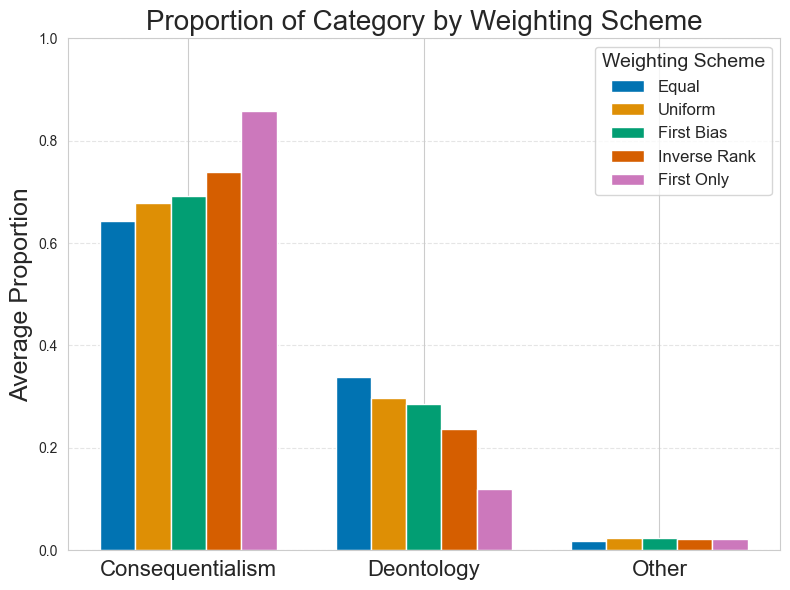

In [10]:
# — example usage —
df = dfs.query("equal_group_size == False and decision != '' and rationales != '' and reasoning_first == True").copy()
col = ['decision_category', 'phenomenon_category'][1]
w_equal      = compute_weighted_macro_props(df, col, weight_scheme='equal')
w_uniform    = compute_weighted_macro_props(df, col, weight_scheme='uniform')
w_first_bias = compute_weighted_macro_props(df, col, weight_scheme='first_bias')
w_inverse    = compute_weighted_macro_props(df, col, weight_scheme='inverse_rank')
w_first_only = compute_weighted_macro_props(df, col, weight_scheme='first_only')
# then merge back to your original dfs on ['model_id','sample_id']

macros = TAXONOMY_MACRO.keys()
methods = {'Equal': w_equal, 'Uniform': w_uniform, 'First Bias': w_first_bias, 'Inverse Rank': w_inverse, 'First Only': w_first_only}

avg_props = {
    name: np.array([
        # select all columns whose name ends with _<m>, flatten and average
        df.filter(regex=f"_{m}$").to_numpy().mean()
        for m in macros
    ])
    for name, df in methods.items()
}

# 5) plot grouped bars  (unchanged)
x     = np.arange(len(macros))
width = 0.15
cmap = sns.color_palette("colorblind", n_colors=len(avg_props))
fig, ax = plt.subplots(figsize=(8,6))
for i, (name, vals) in enumerate(avg_props.items()):
    ax.bar(x + i*width, vals, width, color=cmap[i])

n_methods = len(avg_props)
offset = (n_methods - 1) * width / 2

ax.set_xticks(x + offset)
ax.set_xticklabels(macros, fontsize=16)
ax.set_ylabel('Average Proportion', fontsize=18)
ax.set_title('Proportion of Category by Weighting Scheme', fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.legend(avg_props.keys(), title='Weighting Scheme', fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(FIGURE_SAVE_DIR, 'rationales_weighting_schemes.pdf'), bbox_inches='tight', dpi=300)
plt.show()

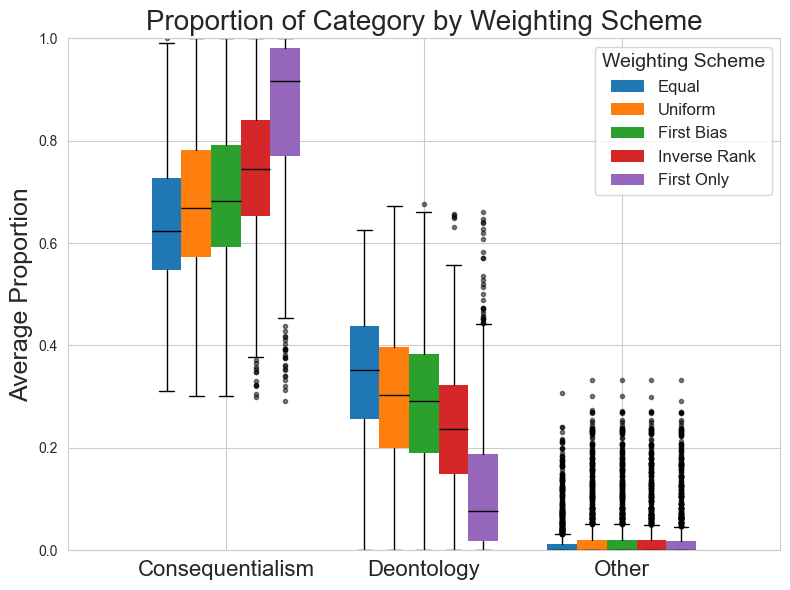

In [11]:
# 5) plot grouped boxplots of the macro props for each weighting scheme
schemes    = list(methods.keys())
n_methods  = len(schemes)
n_macros   = len(macros)
x          = np.arange(n_macros)
width      = 0.15

# build data and positions
data      = []
positions = []
for i, name in enumerate(schemes):
    dfm = methods[name]
    for j, m in enumerate(macros):
        vals = dfm.filter(regex=f"_{m}$").to_numpy().flatten()
        data.append(vals)
        positions.append(j + i*width)

fig, ax = plt.subplots(figsize=(8,6))

# draw boxplots, show black means
bp = ax.boxplot(
    data,
    positions=positions,
    widths=width,
    patch_artist=True,
    medianprops=dict(color='black', linewidth=1),
    # showmeans=True,
    # meanprops=dict(
    #     marker='D',
    #     markeredgecolor='black',
    #     markerfacecolor='black'
    # ),
    flierprops=dict(
        marker='o',
        markersize=3,           # smaller dots
        markerfacecolor='black',
        markeredgecolor='black',
        alpha=0.5
    )
)

# get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# fill each box and remove its border
for idx, box in enumerate(bp['boxes']):
    scheme_idx = idx // n_macros
    box.set_facecolor(colors[scheme_idx])
    box.set_linewidth(0)           # no edge around the box

# center the x-ticks under each macro group
ax.set_xticks(x + width*(n_methods-1)/2)
ax.set_xticklabels(macros, fontsize=16)
ax.set_ylabel('Average Proportion', fontsize=18)
ax.set_title('Proportion of Category by Weighting Scheme', fontsize=20)
plt.ylim(0, 1)

# legend proxies in the same colors
from matplotlib.patches import Patch
proxies = [
    Patch(facecolor=colors[i], edgecolor='none', label=name)
    for i, name in enumerate(schemes)
]
ax.legend(handles=proxies, title='Weighting Scheme', fontsize=12, title_fontsize=14)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURE_SAVE_DIR, 'rationales_weighting_schemes_boxplot.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [12]:
df = dfs.query("decision != '' and rationales != ''").copy()
wide_dec   = compute_weighted_macro_props(df, 'decision_category', weight_scheme='inverse_rank')
wide_pheno = compute_weighted_macro_props(df, 'phenomenon_category', weight_scheme='inverse_rank')


col = ['decision_category', 'phenomenon_category'][1]
phenomena = df[col].unique()
macros = TAXONOMY_MACRO.keys()

# 2. build lists of column names
cols_by_macro = {
    m: [f"{phen}_{m}" for phen in phenomena]
    for m in macros
}

# 3. compute the overall-average columns
wide_pheno = wide_pheno.assign(**{
    f"Overall_{m}": wide_pheno[cols_by_macro[m]].mean(axis=1)
    for m in macros
})

# 4. Compute the overall delta_CD column (delta_CD = Ovreall_Consequentialism - Overall_Deontology)
wide_pheno['delta_CD'] = (
    wide_pheno['Overall_Consequentialism'] - wide_pheno['Overall_Deontology']
)

# 4b) Compute delta for each phenomenon
wide_pheno = wide_pheno.assign(**{
    f"delta_{phen}": (wide_pheno[f"{phen}_Consequentialism"] - wide_pheno[f"{phen}_Deontology"])
    for phen in phenomena
})

cd_df = wide_dec.merge(
    wide_pheno,
    on=['model_id', 'sample_id', 'reasoning_first','equal_group_size'],
    how='left'
)

suffixes = ["Consequentialism", "Deontology", "Other"]
desired = [
    f"{base}_{suffix}"
    for base in FLAT_ORDER
    for suffix in suffixes
]
pos_map = {col: idx for idx, col in enumerate(desired)}
data_cols = [c for c in cd_df.columns if c not in ("model_id", "sample_id", "reasoning_first",'equal_group_size')]
sorted_cols = sorted(
    data_cols,
    key=lambda c: pos_map.get(c, len(pos_map))
)

# 7) Re-index your DataFrame
cd_df = cd_df[["model_id", "sample_id", "reasoning_first",'equal_group_size'] + sorted_cols]

print(f"Dataframe shape: {cd_df.shape}")
cd_df.head(2)

Dataframe shape: (1330, 48)


model_id sample_id  reasoning_first  equal_group_size  \
0  Instella-3B-Instruct        s1             True             False   
1  Instella-3B-Instruct        s1             True              True   

   Overall_Consequentialism  Overall_Deontology  Overall_Other  \
0                  0.785058            0.189388       0.025553   
1                  0.548546            0.399240       0.052215   

   Age_Consequentialism  Age_Deontology  Age_Other  Young_Consequentialism  \
0              0.831944        0.168056   0.000000                0.849697   
1              0.567071        0.363485   0.069444                0.552103   

   Young_Deontology  Young_Other  Old_Consequentialism  Old_Deontology  \
0          0.150303     0.000000              0.812648        0.187352   
1          0.407493     0.040404              0.600000        0.266667   

   Old_Other  Fitness_Consequentialism  Fitness_Deontology  Fitness_Other  \
0   0.000000                  0.794326            0.141844       0.063830   
1   0.133333                  0.549874            0.408460       0.041667   

   Unfit_Consequentialism  Unfit_Deontology  Unfit_Other  \
0                0.866667          0.133333          0.0   
1                0.641148          0.358852          0.0   

   Fit_Consequentialism  Fit_Deontology  Fit_Other  Gender_Consequentialism  \
0              0.740741        0.148148   0.111111                 0.808442   
1              0.490073        0.440961   0.068966                 0.508658   

   Gender_Deontology  Gender_Other  Female_Consequentialism  \
0           0.191558      0.000000                 0.787879   
1           0.437771      0.053571                 0.479961   

   Female_Deontology  Female_Other  Male_Consequentialism  Male_Deontology  \
0           0.212121      0.000000               0.837945         0.162055   
1           0.423265      0.096774               0.544242         0.455758   

   Male_Other  SocialValue_Consequentialism  SocialValue_Deontology  \
0         0.0                      0.705521                0.256096   
1         0.0                      0.568580                0.387244   

   SocialValue_Other  Low_Consequentialism  Low_Deontology  Low_Other  \
0           0.038384              0.670034         0.29822   0.031746   
1           0.044177              0.445753         0.48957   0.064677   

   High_Consequentialism  High_Deontology  High_Other  delta_CD  \
0               0.727439         0.230077    0.042484  0.595670   
1               0.651705         0.317992    0.030303  0.149306   

   delta_SocialValue  delta_Gender  delta_Age  delta_Fitness  
0           0.449425      0.616883   0.663889       0.652482  
1           0.181336      0.070887   0.203586       0.141414

### LLM Capabilities Evals

In [13]:
# Data from Stanford's HELM Leaderboard
evals_dir = "data/evals"
helm_lite = pd.read_csv(f"{evals_dir}/helm_lite.csv").drop(columns=['Model Name'])
helm_mmlu = pd.read_csv(f"{evals_dir}/helm_mmlu.csv").drop(columns=['Model Name'])
helm_safety = pd.read_csv(f"{evals_dir}/helm_safety.csv").drop(columns=['Model Name'])
hendrycks_mmlu = pd.read_csv(f"{evals_dir}/hendrycks_mmlu.csv").drop(columns=['Model Name'])
hendrycks_mmlu['MMLU'] = hendrycks_mmlu['MMLU'] / 100

# Data from our own GSM8K Platinum evaluation with lm-eval
def get_gsm8k_dataframe():
    MEAN_PREFIX   = "exact_match,"
    STD_PREFIX    = "exact_match_stderr,"
    def best(vals, prefix):
        # pick the maximum over all keys that start with prefix
        return max(v for k, v in vals.items() if k.startswith(prefix))
    base = Path("lm_eval_results/gsm8k_platinum")
    rows = [
        {
            "model_id": load_model_config(j["model_name"]).save_id,
            "GSM8K Platinum - Mean": best(res, MEAN_PREFIX),
            "GSM8K Platinum - Std":   best(res, STD_PREFIX),
        }
        for path in base.rglob("results_*.json")
        for j    in [json.loads(path.read_text())]
        for res  in [j["results"]["gsm8k_platinum"]]
    ]
    return pd.DataFrame(rows)
gsm_df = get_gsm8k_dataframe().sort_values("model_id")

eval_dfs = (
    helm_safety
    .merge(helm_lite,how='outer',on='model_id')
    .merge(helm_mmlu,how='outer',on='model_id')
    .merge(gsm_df,how='outer',on='model_id')
    .merge(hendrycks_mmlu,how='outer',on='model_id').
    dropna(subset=['model_id'])
)
print(f"Dataframe shape: {eval_dfs.shape}")
eval_dfs.head(2)

Dataframe shape: (93, 79)


model_id  Mean safety score  \
0  Llama-3.2-1B-Instruct                NaN   
1  Llama-3.2-3B-Instruct                NaN   

   HarmBench - LM Evaluated Safety score  \
0                                    NaN   
1                                    NaN   

   SimpleSafetyTests - LM Evaluated Safety score  BBQ - BBQ accuracy  \
0                                            NaN                 NaN   
1                                            NaN                 NaN   

   Anthropic Red Team - LM Evaluated Safety score  \
0                                             NaN   
1                                             NaN   

   XSTest - LM Evaluated Safety score  Mean win rate (Lite)  NarrativeQA - F1  \
0                                 NaN                   NaN               NaN   
1                                 NaN                   NaN               NaN   

   NaturalQuestions (open) - F1  NaturalQuestions (closed) - F1  \
0                           NaN                             NaN   
1                           NaN                             NaN   

   OpenbookQA - EM  MMLU - EM  MATH - Equivalent (CoT)  GSM8K - EM  \
0              NaN        NaN                      NaN         NaN   
1              NaN        NaN                      NaN         NaN   

   LegalBench - EM  MedQA - EM  WMT 2014 - BLEU-4  MMLU All Subjects - EM  \
0              NaN         NaN                NaN                     NaN   
1              NaN         NaN                NaN                     NaN   

   Abstract Algebra - EM  Anatomy - EM  College Chemistry - EM  \
0                    NaN           NaN                     NaN   
1                    NaN           NaN                     NaN   

   Computer Security - EM  Econometrics - EM  Global Facts - EM  \
0                     NaN                NaN                NaN   
1                     NaN                NaN                NaN   

   Jurisprudence - EM  Philosophy - EM  Professional Medicine - EM  \
0                 NaN              NaN                         NaN   
1                 NaN              NaN                         NaN   

   Us Foreign Policy - EM  Astronomy - EM  Business Ethics - EM  \
0                     NaN             NaN                   NaN   
1                     NaN             NaN                   NaN   

   Clinical Knowledge - EM  College Biology - EM  \
0                      NaN                   NaN   
1                      NaN                   NaN   

   College Computer Science - EM  College Mathematics - EM  \
0                            NaN                       NaN   
1                            NaN                       NaN   

   College Medicine - EM  College Physics - EM  Conceptual Physics - EM  \
0                    NaN                   NaN                      NaN   
1                    NaN                   NaN                      NaN   

   Electrical Engineering - EM  Elementary Mathematics - EM  \
0                          NaN                          NaN   
1                          NaN                          NaN   

   Formal Logic - EM  High School Biology - EM  High School Chemistry - EM  \
0                NaN                       NaN                         NaN   
1                NaN                       NaN                         NaN   

   High School Computer Science - EM  High School European History - EM  \
0                                NaN                                NaN   
1                                NaN                                NaN   

   High School Geography - EM  High School Government And Politics - EM  \
0                         NaN                                       NaN   
1                         NaN                                       NaN   

   High School Macroeconomics - EM  High School Mathematics - EM  \
0                              NaN                           NaN   
1                              NaN                           NaN   

   High S

#### Merge all dfs

In [14]:
all_merged_df = (
    data_df
    .merge(consistency_df, on=['model_id','sample_id','equal_group_size'], how='left')
    .merge(utility_df, on=['model_id','sample_id','reasoning_first','equal_group_size'], how='left')
    .merge(cd_df,      on=['model_id','sample_id','reasoning_first','equal_group_size'], how='left')
    .merge(helm_lite, on='model_id', how='left')
    .merge(helm_mmlu, on='model_id', how='left')
    .merge(helm_safety, on='model_id', how='left')
    .merge(gsm_df, on='model_id', how='left')
    .merge(hendrycks_mmlu, on='model_id', how='left')
)

print(f"Dataframe shape: {all_merged_df.shape}")
all_merged_df.head(2)

Dataframe shape: (1350, 156)


model_name               model_id sample_id release_date  developer  \
0  Claude 3.5 Haiku  claude-3.5-haiku:beta    after1   2024-10-22  Anthropic   
1  Claude 3.5 Haiku  claude-3.5-haiku:beta    after1   2024-10-22  Anthropic   

   parameter_count  reasoning_first  reasoning_model  equal_group_size  \
0              NaN            False            False             False   
1              NaN            False            False              True   

  model_type model_base  count  valid_equal  valid_different  avg_length  \
0      final        NaN    320            0              320   185.87500   
1      final        NaN    320          320                0   190.53125   

   response_rate  Age_consistency  Fitness_consistency  Gender_consistency  \
0            1.0         0.500000             0.458333            0.392857   
1            1.0         0.583333             0.458333            0.107143   

   SocialValue_consistency  Overall_consistency  Overall_utility  Age_utility  \
0                 0.619048               0.5375         0.636161        0.625   
1                 0.452381               0.4125              NaN          NaN   

   Young_utility  Old_utility  Fitness_utility  Unfit_utility  Fit_utility  \
0       0.708333     0.541667         0.604167          0.375     0.833333   
1            NaN          NaN              NaN            NaN          NaN   

   Gender_utility  Female_utility  Male_utility  SocialValue_utility  \
0        0.660714        0.642857      0.678571             0.654762   
1             NaN             NaN           NaN                  NaN   

   Low_utility  High_utility  Overall_Consequentialism  Overall_Deontology  \
0      0.52381      0.785714                  0.779907            0.211164   
1          NaN           NaN                  0.511259            0.477828   

   Overall_Other  Age_Consequentialism  Age_Deontology  Age_Other  \
0       0.008929              0.852367        0.147633        0.0   
1       0.010913              0.748442        0.251558        0.0   

   Young_Consequentialism  Young_Deontology  Young_Other  \
0                0.857186          0.142814          0.0   
1                0.691142          0.308858          0.0   

   Old_Consequentialism  Old_Deontology  Old_Other  Fitness_Consequentialism  \
0               0.84562         0.15438        0.0                  0.881944   
1               0.81616         0.18384        0.0                  0.596591   

   Fitness_Deontology  Fitness_Other  Unfit_Consequentialism  \
0            0.118056       0.000000                0.820513   
1            0.361742       0.041667                0.319347   

   Unfit_Deontology  Unfit_Other  Fit_Consequentialism  Fit_Deontology  \
0          0.179487     0.000000              0.904762        0.095238   
1          0.603730     0.076923              0.699567        0.271861   

   Fit_Other  Gender_Consequentialism  Gender_Deontology  Gender_Other  \
0   0.000000                  0.67803           0.286255      0.035714   
1   0.028571                  0.22658           0.773420      0.000000   

   Female_Consequentialism  Female_Deontology  Female_Other  \
0                 0.702581           0.297419           0.0   
1                 0.348752           0.651248           0.0   

   Male_Consequentialism  Male_Deontology  Male_Other  \
0               0.655172         0.275862    0.068966   
1               0.128055         0.871945    0.000000   

   SocialValue_Consequentialism  SocialValue_Deontology  SocialValue_Other  \
0                      0.707287                0.292713           0.000000   
1                      0.473422                0.524593           0.001984   

   Low_Consequentialism  Low_Deontology  Low_Other  High_Consequentialism  \
0              0.623187        0.376813        0.0               0.756478   
1              0.227196        0.772804        0.0               0.603251   

   High_Deontology  High_Other  delta_CD  delta_Soci

In [15]:
# Calculate the average across all samples for each model
all_avg_data_df = all_merged_df.groupby(['model_id', 'reasoning_first','equal_group_size']).mean(numeric_only=True).reset_index()

# Add model name and other non-numerical columns back
model_metadata = all_merged_df[['model_id', 'model_name', 'release_date', 'developer', 'model_type', 'model_base',]].drop_duplicates()
all_avg_data_df = model_metadata.merge(all_avg_data_df, on='model_id', how='left')
all_avg_data_df['reasoning_first'] = all_avg_data_df['reasoning_first'].astype(float)
all_avg_data_df['equal_group_size'] = all_avg_data_df['equal_group_size'].astype(float)

print(f"Dataframe shape: {all_avg_data_df.shape}")
all_avg_data_df.head(2)

Dataframe shape: (284, 155)


model_id        model_name release_date  developer model_type  \
0  claude-3.5-haiku:beta  Claude 3.5 Haiku   2024-10-22  Anthropic      final   
1  claude-3.5-haiku:beta  Claude 3.5 Haiku   2024-10-22  Anthropic      final   

  model_base  reasoning_first  equal_group_size  parameter_count  \
0        NaN              0.0               0.0              NaN   
1        NaN              0.0               1.0              NaN   

   reasoning_model  count  valid_equal  valid_different  avg_length  \
0              0.0  320.0          0.0            320.0  187.136875   
1              0.0  320.0        320.0              0.0  190.725625   

   response_rate  Age_consistency  Fitness_consistency  Gender_consistency  \
0            1.0         0.525000             0.591667            0.442857   
1            1.0         0.533333             0.400000            0.221429   

   SocialValue_consistency  Overall_consistency  Overall_utility  Age_utility  \
0                 0.614286              0.56750         0.634821     0.595833   
1                 0.461905              0.42125              NaN          NaN   

   Young_utility  Old_utility  Fitness_utility  Unfit_utility  Fit_utility  \
0       0.691667          0.5         0.679167       0.558333          0.8   
1            NaN          NaN              NaN            NaN          NaN   

   Gender_utility  Female_utility  Male_utility  SocialValue_utility  \
0            0.65        0.557143      0.742857             0.614286   
1             NaN             NaN           NaN                  NaN   

   Low_utility  High_utility  Overall_Consequentialism  Overall_Deontology  \
0     0.483333      0.745238                  0.762603            0.232933   
1          NaN           NaN                  0.501967            0.490345   

   Overall_Other  Age_Consequentialism  Age_Deontology  Age_Other  \
0       0.004464              0.878085        0.120527   0.001389   
1       0.007688              0.747431        0.252569   0.000000   

   Young_Consequentialism  Young_Deontology  Young_Other  \
0                0.878092          0.121908          0.0   
1                0.698631          0.301369          0.0   

   Old_Consequentialism  Old_Deontology  Old_Other  Fitness_Consequentialism  \
0              0.875894        0.120403   0.003704                  0.804798   
1              0.823708        0.176292   0.000000                  0.543439   

   Fitness_Deontology  Fitness_Other  Unfit_Consequentialism  \
0            0.191035       0.004167                0.760820   
1            0.427394       0.029167                0.318063   

   Unfit_Deontology  Unfit_Other  Fit_Consequentialism  Fit_Deontology  \
0          0.228069     0.011111              0.834977        0.165023   
1          0.609974     0.071964              0.649206        0.345080   

   Fit_Other  Gender_Consequentialism  Gender_Deontology  Gender_Other  \
0   0.000000                 0.681177           0.306918      0.011905   
1   0.005714                 0.227429           0.771381      0.001190   

   Female_Consequentialism  Female_Deontology  Female_Other  \
0                 0.718192           0.268252      0.013557   
1                 0.310905           0.686317      0.002778   

   Male_Consequentialism  Male_Deontology  Male_Other  \
0               0.655341         0.330866    0.013793   
1               0.167416         0.832584    0.000000   

   SocialValue_Consequentialism  SocialValue_Deontology  SocialValue_Other  \
0                      0.686352                0.313251           0.000397   
1                      0.489568                0.510035           0.000397   

   Low_Consequentialism  Low_Deontology  Low_Other  High_Consequentialism  \
0              0.621138        0.378862        0.0               0.724535   
1              0.238398        0.761602        0.0               0.622008   

   High_Deontology  High_Other  delta_CD  delta_SocialValue  delta_Gender  \
0         0.

In [16]:
avg_data_df = all_avg_data_df.query("reasoning_model == False & model_type == 'final'").copy()
avg_merged_df = all_merged_df.query("reasoning_model == False & model_type == 'final'").copy()

dpo_data_df = all_avg_data_df.query("model_type == 'sft' or model_type == 'dpo'")
dpo_merged_df = all_merged_df.query("model_type == 'sft' or model_type == 'dpo'")

reasoning_and_trad_models = [
    'deepseek-chat', 'deepseek-r1',
    'qwen3-32b:nothink', 'qwen3-32b:think',
    'qwen3-30b-a3b:nothink', 'qwen3-30b-a3b:think',
    'Qwen2.5-32B-Instruct', 'qwq-32b',
    'llama-3.1-8b-instruct', 'deepseek-r1-distill-llama-8b',
    'llama-3.1-70b-instruct', 'deepseek-r1-distill-llama-70b',
]
reasoning_data_df = all_avg_data_df.query("model_id in @reasoning_and_trad_models").copy()
reasoning_data_df = reasoning_data_df.query("reasoning_first == True")
reasoning_merged_df = all_merged_df.query("model_id in @reasoning_and_trad_models").copy()
reasoning_merged_df = reasoning_merged_df.query("reasoning_first == True")

## Plots

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from typing import Optional, Tuple
import pandas as pd

def plot_metric_barplot_errorbars(
    df: pd.DataFrame,
    metric: str = 'delta_CD',
    metric_label: Optional[str] = None,
    min_max_label: Optional[str] = None,
    reasoning_first: Optional[bool] = True,
    figsize: Tuple[float, float] = (8, 10),
    cmap_name: str = "coolwarm",
    save_path: Optional[str] = None,
    vmin_vmax: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper left',
    query: Optional[str] = None,
    sort: bool = True,
    sort_by_diff: bool = False,  # new arg
    group_size_colors: Optional[list[str]] = sns.color_palette('colorblind', n_colors=2),
    add_gap_between_model_base: Optional[float] = None,
    show_samples: bool = False,
    errorbar_ci: float = 1.96,
    show_developer: bool = False,
):
    # 1. Filter
    filt = df if reasoning_first is None else df[df['reasoning_first'] == reasoning_first]
    if query:
        filt = filt.query(query)

    # 2. Compute group stats for overall bars
    group_cols = ['model_id', 'model_name']
    if add_gap_between_model_base:
        group_cols += ['model_base', 'model_type']

    stats = (
        filt
        .groupby(group_cols)[metric]
        .agg(mean_metric='mean', std_metric='std', n='count')
        .reset_index()
    )
    stats['sem_metric'] = stats['std_metric'] / np.sqrt(stats['n'])

    # 3. If sorting by diff between equal_group_size levels, compute that diff
    diff_df = None
    if sort_by_diff:
        # compute per-model means for balanced vs imbalanced
        diff_df = (
            filt
            .groupby(['model_id', 'equal_group_size'])[metric]
            .mean()
            .unstack('equal_group_size')
            .rename(columns={True: 'mean_balanced', False: 'mean_imbalanced'})
            .reset_index()
        )
        diff_df['diff'] = diff_df['mean_imbalanced'] - diff_df['mean_balanced']
        # merge into stats
        stats = stats.merge(diff_df[['model_id', 'diff']], on='model_id', how='left')
        sort_col = 'diff'
        ascending = False  # largest positive diffs first
    else:
        sort_col = 'mean_metric'
        ascending = sort

    # 4. Sort
    plot_df = stats.sort_values(sort_col if sort else [], ascending=ascending)

    # 5. Colormap
    vmin, vmax = vmin_vmax if vmin_vmax else (plot_df['mean_metric'].min(), plot_df['mean_metric'].max())
    norm = plt.Normalize(vmin, vmax)
    cmap = sns.color_palette(cmap_name, as_cmap=True)
    bar_colors = cmap(norm(plot_df['mean_metric']))

    # 6. Y positions with optional gaps
    if add_gap_between_model_base:
        bases = plot_df['model_base'].values
        gap_counts = np.concatenate([[0], np.cumsum(bases[1:] != bases[:-1])])
        base_idx = np.arange(len(plot_df), dtype=float)
        y_pos = base_idx + gap_counts * add_gap_between_model_base
    else:
        y_pos = np.arange(len(plot_df), dtype=float)

    # 7. Plot bars
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(y=y_pos, width=plot_df['mean_metric'], color=bar_colors, edgecolor='none')

    sub_stats = None
    # 8a. If showing mean+errorbar
    if not show_samples:
        sub_stats = (
            filt
            .groupby(['model_id', 'equal_group_size'])[metric]
            .agg(mean='mean', std='std', count='count')
            .rename(columns={'std':'std_', 'count':'n_'})
            .assign(sem=lambda d: d['std_'] / np.sqrt(d['n_']))
            .reset_index()
        )
        y_map = dict(zip(plot_df['model_id'], y_pos))
        labels_plotted = set()

        for _, row in sub_stats.iterrows():
            mid, eq = row['model_id'], row['equal_group_size']
            xerr = row['sem'] * errorbar_ci
            y = y_map[mid]
            label = 'Size-Balanced' if eq else 'Size-Imbalanced'
            color = group_size_colors[0] if eq else group_size_colors[1]
            if label not in labels_plotted:
                ax.errorbar(x=row['mean'], y=y, xerr=xerr, fmt='o',
                            color=color, alpha=0.8, label=label,
                            capsize=5, elinewidth=1)
                labels_plotted.add(label)
            else:
                ax.errorbar(x=row['mean'], y=y, xerr=xerr, fmt='o',
                            color=color, alpha=0.8,
                            capsize=2, elinewidth=1)

    # 8b. If showing all samples
    else:
        pos_map = dict(zip(plot_df['model_id'], y_pos))
        sns.scatterplot(
            x=filt.loc[filt['equal_group_size'], metric],
            y=filt.loc[filt['equal_group_size'], 'model_id'].map(pos_map),
            ax=ax, marker='o', s=50, alpha=0.6,
            color=group_size_colors[0], label='Size-Balanced'
        )
        sns.scatterplot(
            x=filt.loc[~filt['equal_group_size'], metric],
            y=filt.loc[~filt['equal_group_size'], 'model_id'].map(pos_map),
            ax=ax, marker='o', s=50, alpha=0.6,
            color=group_size_colors[1], label='Size-Imbalanced'
        )

    # 9. Aesthetics
    metric_label = metric_label or metric.replace('_', ' ').title()
    ax.axvline(0, color='gray', linewidth=0.8)
    ax.set_xlabel(metric_label, fontsize=16)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_df['model_name'], fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    # sns.despine(fig=fig, ax=ax, left=True, bottom=True, right=True, top=True)
    ax.tick_params(axis='both', pad=-3)

    # 9a. Show developer names on the right
    if show_developer:
        # merge in developer (take first occurrence per model)
        dev = df[['model_id', 'developer']].drop_duplicates(subset='model_id').set_index('model_id')
        x_max = ax.get_xlim()[1]
        # small offset to move the text just beyond the bar
        x_offset = (x_max) * 0.05
        for mid, y in zip(plot_df['model_id'], y_pos):
            dev_name = dev.loc[mid, 'developer']
            ax.text(x_max + x_offset, y, dev_name,
                    va='center', ha='left', fontsize=10, color='gray')

        # extend right margin so the text isn’t cut off
        ax.set_xlim(ax.get_xlim()[0], x_max + x_max * 0.15)

    # y‐limits
    ylim_max = len(plot_df) - 0.6
    if add_gap_between_model_base:
        ylim_max += gap_counts.max() * add_gap_between_model_base
    ax.set_ylim(-0.6, ylim_max)

    # 10. Legends
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles=handles, labels=labels, loc=legend_loc, fontsize=12)
    if min_max_label:
        minmax_handles = [
            Patch(facecolor=cmap(norm(vmax)), label=min_max_label[0]),
            Patch(facecolor=cmap(norm(vmin)), label=min_max_label[1]),
        ]
        ax.legend(handles=minmax_handles, loc=legend_loc,
                  bbox_to_anchor=(1, 0), fontsize=12)

    x_min, x_max = ax.get_xlim()
    y_min, _     = ax.get_ylim()
    # labels as before
    palette = sns.color_palette(cmap_name, n_colors=10)
    ax.text(x_min, y_min - 1.4, r'  $\longleftarrow$Deontological', ha='left', va='top', clip_on=False, color=palette[0], alpha=1.0, fontsize=14)
    ax.text(x_max, y_min - 1.4, r'Consequentialist$\longrightarrow$  ', ha='right',va='top', clip_on=False, color=palette[-1], alpha=1.0, fontsize=14)

    plt.subplots_adjust(bottom=0.15)

    plt.tight_layout()

    # 11. Save
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()
    return diff_df

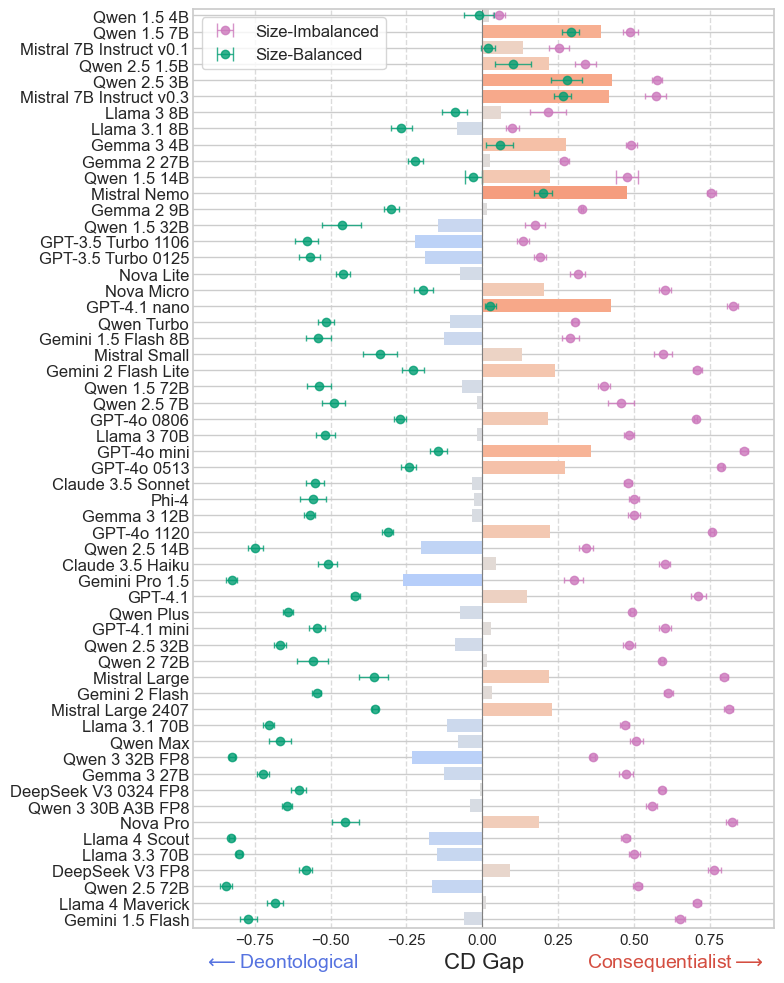

In [258]:
palette = sns.color_palette('colorblind')

diff_stats = plot_metric_barplot_errorbars(
    avg_merged_df,
    # query='Overall_consistency > 0.5',
    metric='delta_CD',
    metric_label='CD Gap',
    # min_max_label=['More Consequentialist', 'More Deontological'],
    reasoning_first=True,
    vmin_vmax=(-1, 1),
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'barWithError_deltaCD_models_sortDiff_reasoningFirst.pdf'),
    figsize=(8, 10),
    group_size_colors=[palette[2], palette[4]],
    legend_loc='upper left',
    show_samples=False,
    sort_by_diff=True,
    # show_developer=True,
)

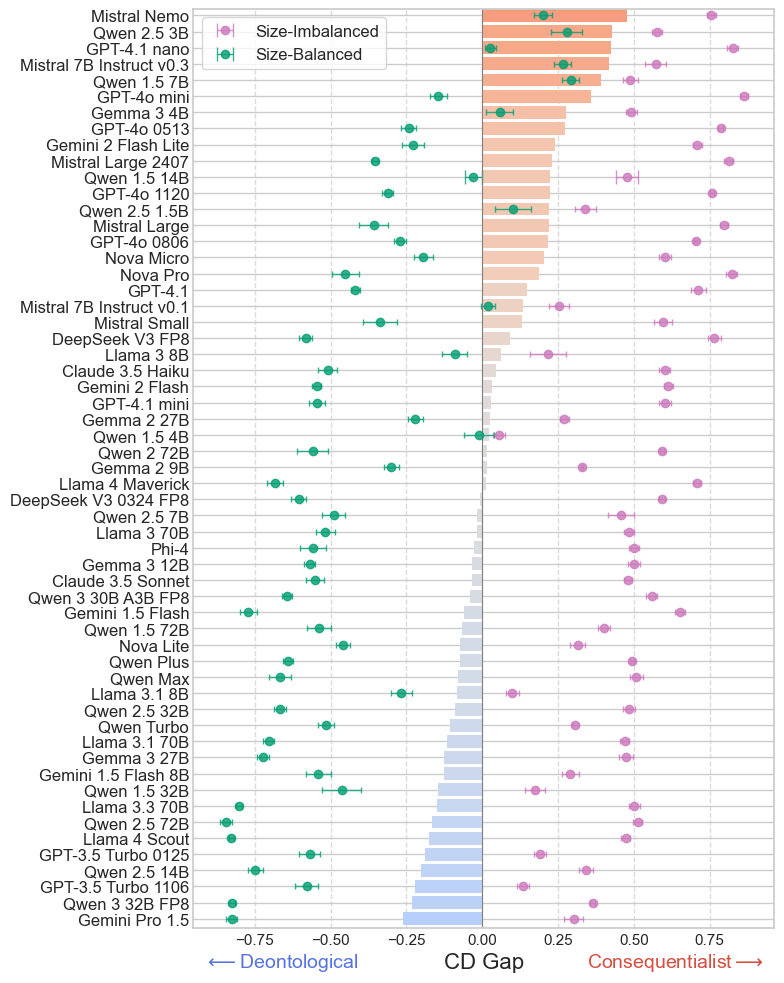

In [259]:
palette = sns.color_palette('colorblind')

diff_stats = plot_metric_barplot_errorbars(
    avg_merged_df,
    # query='Overall_consistency > 0.5',
    metric='delta_CD',
    metric_label='CD Gap',
    # min_max_label=['More Consequentialist', 'More Deontological'],
    reasoning_first=True,
    vmin_vmax=(-1, 1),
    save_path=os.path.join(FIGURE_SAVE_DIR, 'barWithError_deltaCD_models_sortCD_reasoningFirst.pdf'),
    figsize=(8, 10),
    legend_loc='upper left',
    group_size_colors=[palette[2], palette[4]],
    show_samples=False,
    # sort_by_diff=True,
)

In [108]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from typing import Optional, Tuple
import pandas as pd

def plot_metric_barplot(
    df: pd.DataFrame,
    metric: str = 'delta_CD',
    metric_label: Optional[str] = None,
    min_max_label: Optional[str] = None,
    reasoning_first: Optional[bool] = True,
    figsize: Tuple[float, float] = (8, 10),
    cmap_name: str = "coolwarm",
    save_path: Optional[str] = None,
    vmin_vmax: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'lower right',
    query: Optional[str] = None,
    sort: bool = True,
    add_gap_between_model_base: Optional[float] = None,
    add_error_bars: bool = False,
) -> Tuple[plt.Figure, plt.Axes]:
    diff_df = None
    # 1. Optional filtering
    filt = df if reasoning_first is None else df[df['reasoning_first'] == reasoning_first]
    if query:
        filt = filt.query(query)

    # 2. Aggregate means, std, count, sem
    if add_gap_between_model_base:
        group_cols = ['model_id', 'model_name', 'model_base', 'model_type']
    else:
        group_cols = ['model_id', 'model_name']

    stats = (
        filt
        .groupby(group_cols)[metric]
        .agg(
            mean_metric='mean',
            std_metric='std',
            n='count'
        )
        .reset_index()
    )
    stats['sem_metric'] = stats['std_metric'] / np.sqrt(stats['n'])

    # 3. Sort
    plot_df = stats.sort_values('mean_metric' if sort else [], ascending=sort)

    # 4. Colormap
    vmin, vmax = vmin_vmax if vmin_vmax else (plot_df['mean_metric'].min(), plot_df['mean_metric'].max())
    norm = plt.Normalize(vmin, vmax)
    cmap = sns.color_palette(cmap_name, as_cmap=True)
    colors = cmap(norm(plot_df['mean_metric']))

    # 5. Compute y‐positions (with optional gaps)
    if add_gap_between_model_base:
        bases = plot_df['model_base'].values
        gap_counts = np.concatenate([[0], np.cumsum(bases[1:] != bases[:-1])])
        idx = np.arange(len(plot_df), dtype=float)
        y_pos = idx + gap_counts * add_gap_between_model_base
    else:
        y_pos = np.arange(len(plot_df), dtype=float)

    # 6. Plot bars with errorbars
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(
        y=y_pos,
        width=plot_df['mean_metric'],
        xerr=plot_df['sem_metric'] if add_error_bars else None,
        color=colors,
        capsize=5,
    )

    # 7. Labels & aesthetics
    metric_label = metric_label or metric.replace('_',' ').title()
    ax.axvline(0, color='gray', linewidth=0.8)
    ax.set_xlabel(metric_label, fontsize=16)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_df['model_name'], fontsize=12)

    if add_gap_between_model_base:
        ax.set_ylim(
            -0.5,
            len(plot_df) - 0.5 + gap_counts.max() * add_gap_between_model_base
        )
    else:
        ax.set_ylim(-0.5, len(plot_df) - 0.5)

    ax.grid()
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    sns.despine(fig=fig, ax=ax, left=True, bottom=True, right=True, top=True)
    ax.tick_params(axis='y', pad=-3)
    ax.tick_params(axis='x', pad=-3)

    # 8. Min/max legend
    if min_max_label:
        legend_elems = [
            Patch(facecolor=cmap(norm(vmax)), label=min_max_label[0]),
            Patch(facecolor=cmap(norm(vmin)), label=min_max_label[1]),
        ]
        ax.legend(
            handles=legend_elems,
            loc=legend_loc,
            bbox_to_anchor=(1, 0),
            fontsize=12
        )

    plt.tight_layout()

    # 9. Save if requested
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

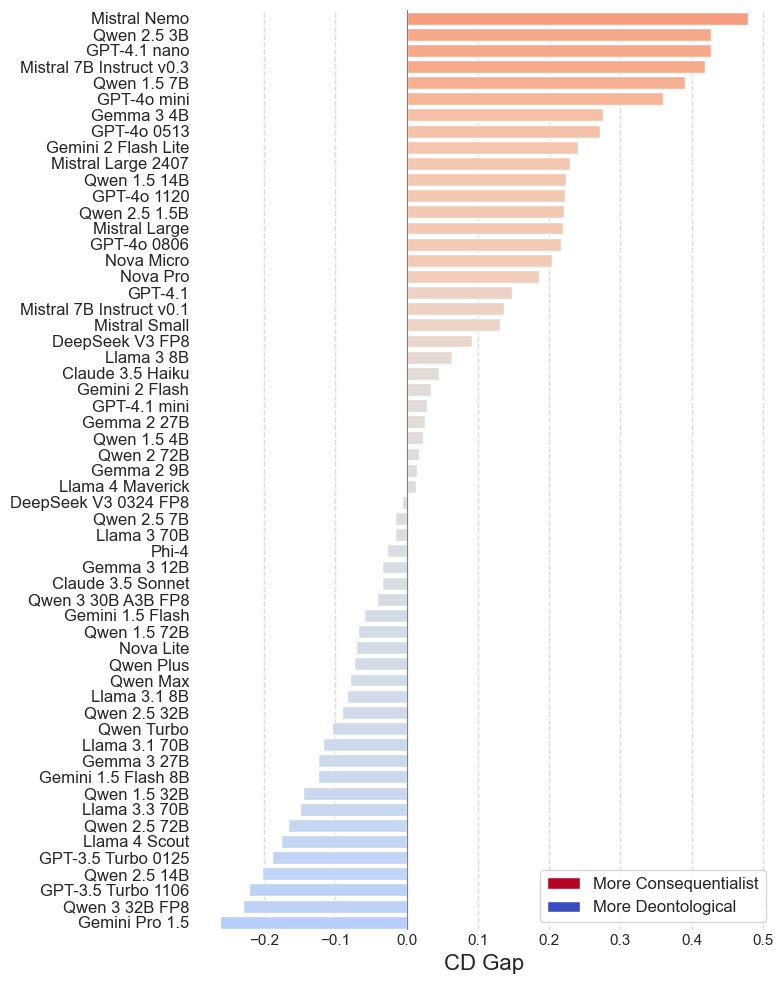

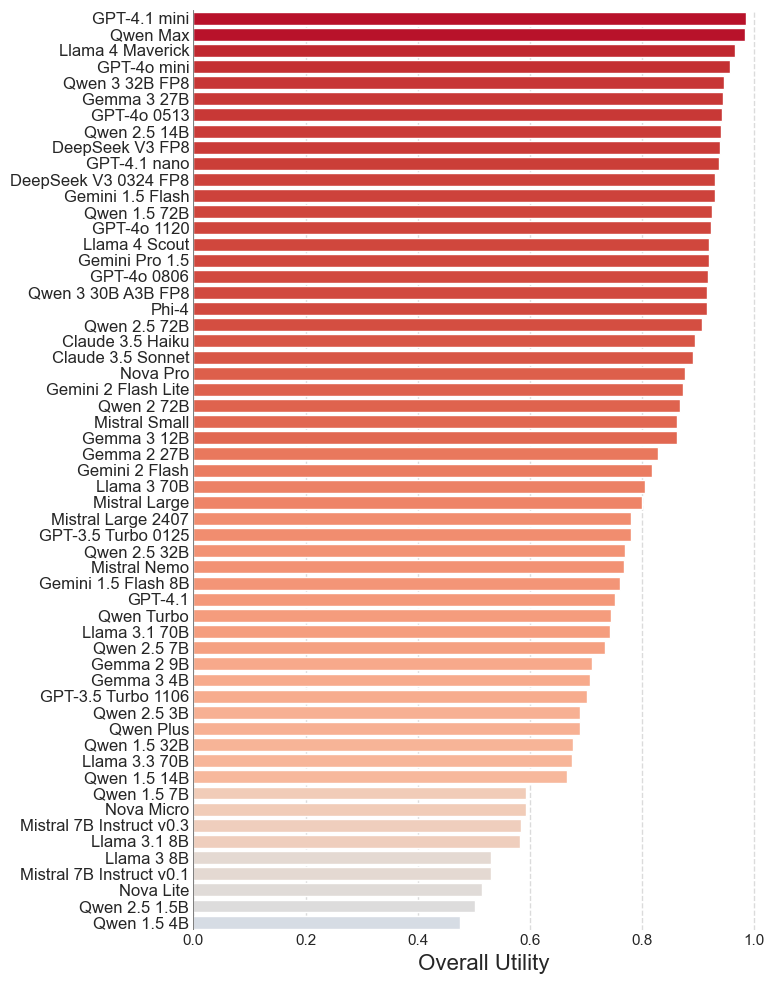

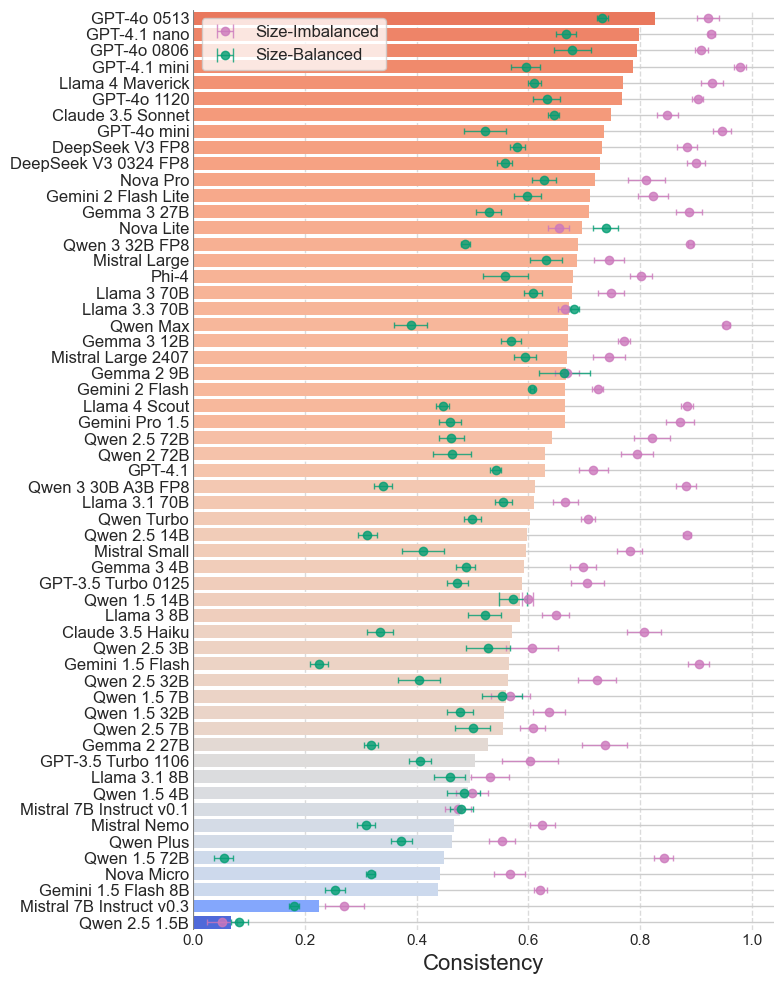

In [66]:

# blocked = [
#     'turbo-1106', '4o-2024-05-13', '4o-2024-08-06',
#     'v0.1', 'v0.3', 'mistral-large',
#     'deepseek-chat',
#     'gemma-2-9b-it', 'gemma-2-27b-it',

# ]
# lowered = avg_data_df['model_id'].str.lower()
# suffixes = tuple(tok.lower() for tok in blocked)
# mask = lowered.str.endswith(suffixes)
# filtered_df = filtered_df.loc[~mask]


plot_metric_barplot(
    avg_merged_df,
    # query='Overall_consistency > 0.5',
    metric='delta_CD',
    metric_label='CD Gap',
    min_max_label=['More Consequentialist', 'More Deontological'],
    reasoning_first=True,
    vmin_vmax=(-1, 1),
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_deltaCD_models__reasoningFirst.pdf'),
    figsize=(8, 10),
)

plot_metric_barplot(
    avg_merged_df,
    metric='Overall_utility',
    reasoning_first=True,
    vmin_vmax=(0, 1),
    cmap_name='coolwarm',
    save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_utility_models__unequalGroups.pdf'),
    figsize=(8, 10),
)

# plot_metric_barplot(
#     avg_merged_df,
#     metric='Overall_consistency',
#     reasoning_first=True,
#     vmin_vmax=(0, 1),
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_consistency_models__reasoningFirst.pdf'),
#     figsize=(8, 10),
# )
palette = sns.color_palette('colorblind')

stats = plot_metric_barplot_errorbars(
    avg_merged_df,
    # query='Overall_consistency > 0.5',
    metric='Overall_consistency',
    metric_label='Consistency',
    # min_max_label=['More Consequentialist', 'More Deontological'],
    reasoning_first=True,
    vmin_vmax=(0, 1),
    save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_consistency_models__reasoningFirst.pdf'),
    figsize=(8, 10),
    group_size_colors=[palette[2], palette[4]],
    show_samples=False,
    # sort_by_diff=True,
)

#### DPO models

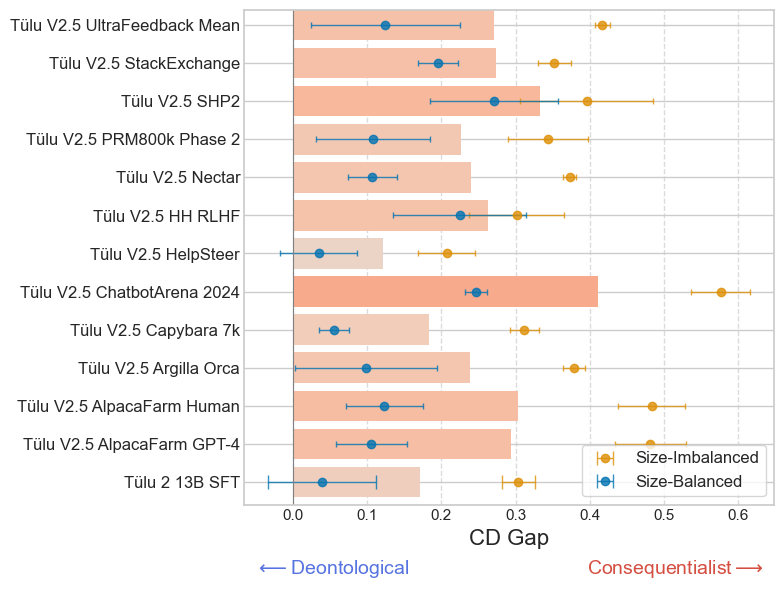

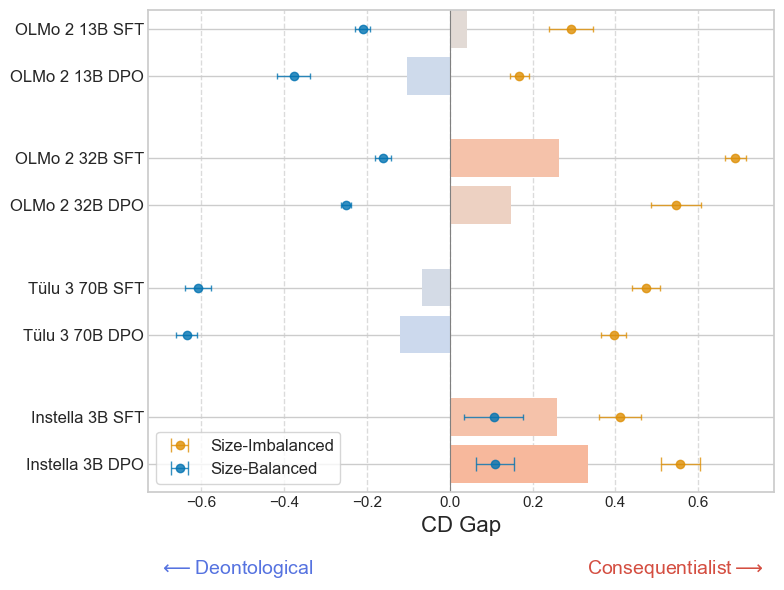

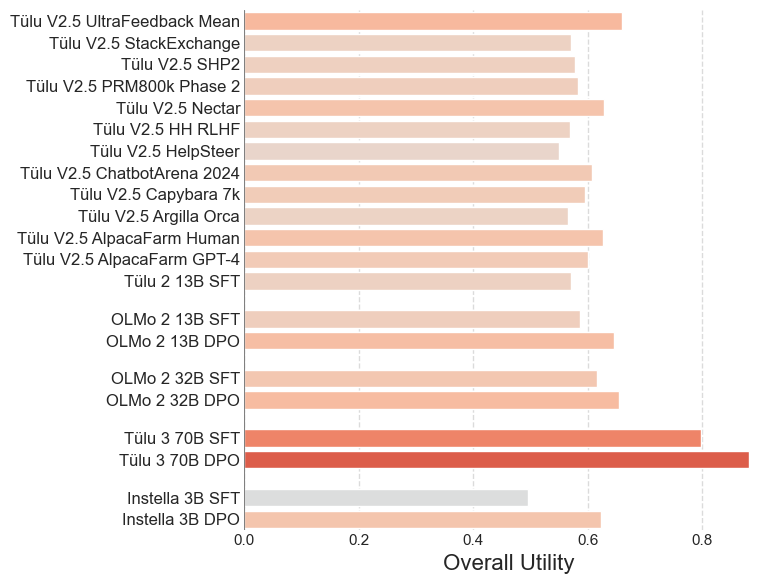

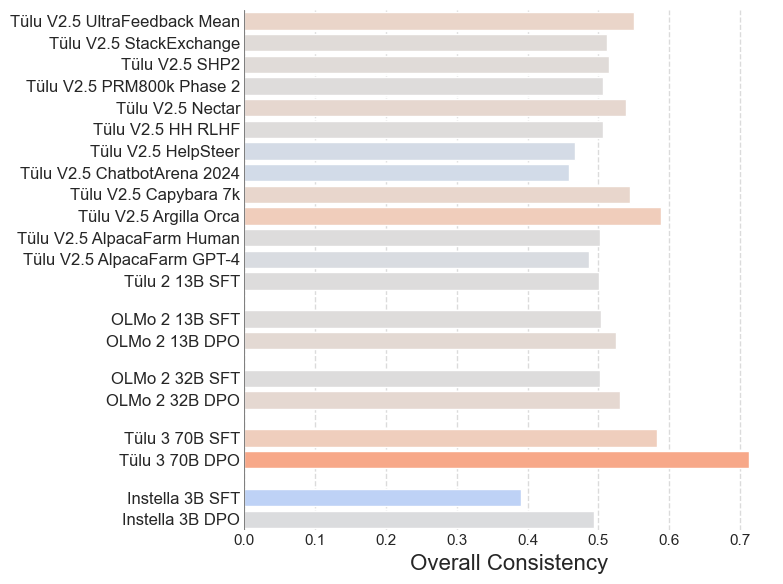

In [261]:
plot_metric_barplot_errorbars(
    dpo_merged_df[dpo_merged_df.model_base == 'tulu-2-13b'],
    # query='Overall_consistency > 0.5',
    metric='delta_CD',
    metric_label='CD Gap',
    # min_max_label=['More Consequentialist', 'More Deontological'],
    reasoning_first=True,
    vmin_vmax=(-1, 1),
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_deltaCD_dpoModels__reasoningFirst.pdf'),
    figsize=(8, 6),
    sort=False,
    add_gap_between_model_base=0.75,
    # add_error_bars=True,
    legend_loc='lower right',
    # show_samples=True,
)
plot_metric_barplot_errorbars(
    dpo_merged_df[dpo_merged_df.model_base != 'tulu-2-13b'],
    # query='Overall_consistency > 0.5',
    metric='delta_CD',
    metric_label='CD Gap',
    # min_max_label=['More Consequentialist', 'More Deontological'],
    reasoning_first=True,
    vmin_vmax=(-1, 1),
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_deltaCD_dpoModels__reasoningFirst.pdf'),
    figsize=(8, 6),
    sort=False,
    add_gap_between_model_base=0.75,
    # add_error_bars=True,
    legend_loc='lower left',
    # show_samples=True,
)

plot_metric_barplot(
    dpo_merged_df,
    metric='Overall_utility',
    reasoning_first=True,
    vmin_vmax=(0, 1),
    cmap_name='coolwarm',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_utility_dpoModels__unequalGroups.pdf'),
    figsize=(8, 6),
    sort=False,
    add_gap_between_model_base=0.75,
    # add_error_bars=True,
)

plot_metric_barplot(
    dpo_merged_df,
    metric='Overall_consistency',
    reasoning_first=True,
    vmin_vmax=(0, 1),
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_consistency_dpoModels__reasoningFirst.pdf'),
    figsize=(8, 6),
    sort=False,
    add_gap_between_model_base=0.75,
    # add_error_bars=True,
)

#### Reasoning models

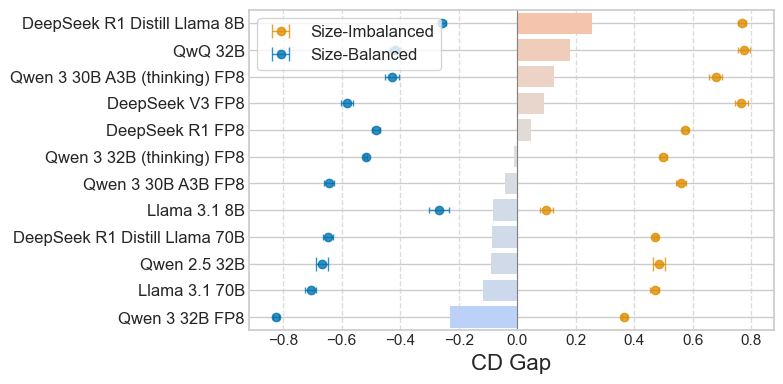

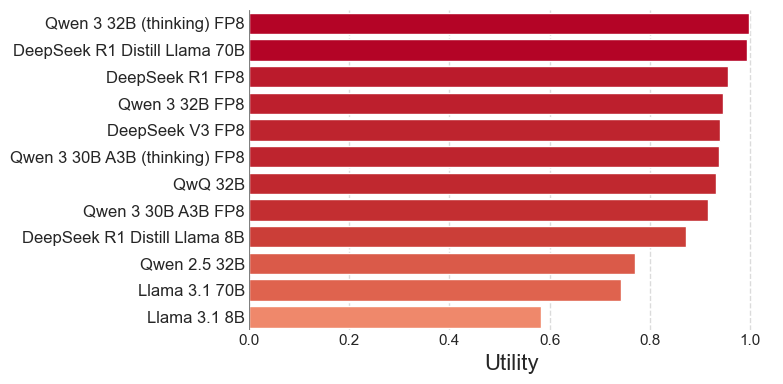

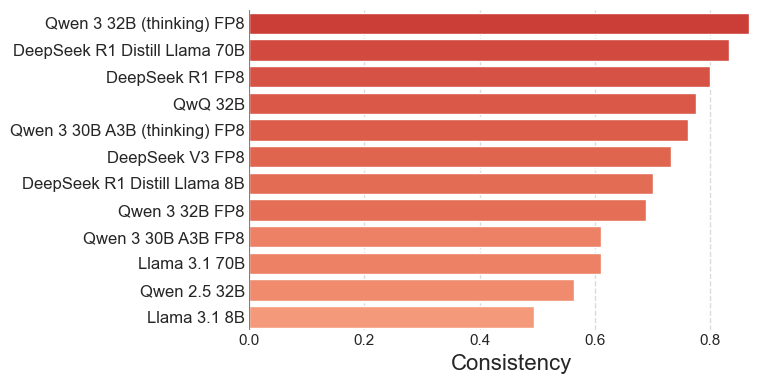

In [96]:
plot_metric_barplot_errorbars(
    reasoning_merged_df,
    # query='Overall_consistency > 0.5',
    metric='delta_CD',
    metric_label='CD Gap',
    # min_max_label=['More Consequentialist', 'More Deontological'],
    reasoning_first=True,
    vmin_vmax=(-1, 1),
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_deltaCD_reasoningModels__reasoningFirst.pdf'),
    figsize=(8, 4),
    # show_samples=True,
    # sort_by_diff=True,
)

plot_metric_barplot(
    reasoning_data_df,
    # query='Overall_consistency > 0.5',
    metric='Overall_utility',
    metric_label='Utility',
    # min_max_label=['More Consequentialist', 'More Deontological'],
    reasoning_first=True,
    vmin_vmax=(-1, 1),
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_utility_reasoningModels__reasoningFirst.pdf'),
    figsize=(8, 4),
)

plot_metric_barplot(
    reasoning_data_df,
    # query='Overall_consistency > 0.5',
    metric='Overall_consistency',
    metric_label='Consistency',
    # min_max_label=['More Consequentialist', 'More Deontological'],
    reasoning_first=True,
    vmin_vmax=(-1, 1),
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_consistency_reasoningModels__reasoningFirst.pdf'),
    figsize=(8, 4),
)



### Big correlations matrix

In [23]:
# # Find model_ids with both True and False values for reasoning_first
# filtered = avg_data_df[avg_data_df['reasoning_first'] == True]
# filtered = avg_data_df.copy()

# # 1) Select only the metric columns (i.e. numeric columns) from avg_data_df
# metrics_df = filtered.select_dtypes(include=[np.number]).drop(columns=['count'])

# # 2) Compute the pairwise correlation matrix, using only those rows
# #    where both values are non-NA (the default pearson implementation does this).
# corr = metrics_df.corr()

# # 3) (Optional) Mask the upper triangle, since it's redundant
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # 4) Plot
# plt.figure(figsize=(40, 40))            # adjust size as needed for readability
# sns.heatmap(
#     corr,
#     mask=mask,
#     # annot=True,                         # show correlation coefficients
#     fmt=".2f",                          # 2 decimal places
#     cmap="coolwarm",                    # diverging palette
#     vmin=-1, vmax=1,                    # force full correlation scale
#     square=True,                        # make cells square
#     linewidths=0.5,                     # lines between cells
#     cbar_kws={"shrink": .5, "label": "Pearson $r$"}
# )

# plt.title("Correlation Matrix of All Metrics", fontsize=18, pad=20)
# plt.xticks(rotation=90, fontsize=10)    # rotate x labels for readability
# plt.yticks(rotation=0, fontsize=10)
# ax = plt.gca()
# ax.set_facecolor('white')
# plt.grid(False)
# plt.tight_layout()
# plt.savefig(os.path.join(FIGURE_SAVE_DIR, "heatmap_allMetrics__.pdf"),bbox_inches="tight",dpi=300)
# plt.close(fig)

### Utility vs DeltaCD

In [24]:

import os
from typing import Optional, Any
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr, ttest_1samp, f_oneway
from matplotlib.lines import Line2D

fixed_positions = {
    "top_right":    (0.975, 0.975, "top",    "right"),
    "top_left":     (0.025, 0.975, "top",    "left"),
    "bottom_right": (0.975, 0.1,   "bottom", "right"),
    "bottom_left":  (0.025, 0.1,   "bottom", "left"),
}

def plot_metric_vs_metric_by_developer(
    df: pd.DataFrame,
    reasoning_first: bool = True,
    x_col: str = "Overall_utility",
    y_col: str = "delta_CD",
    palette_name: str = "colorblind",
    corr_color: Any = sns.color_palette('colorblind')[0],
    title: str = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    save_path: Optional[str] = None,
    fig_size: tuple = (8, 6),
    legend_location: str = "best",
    corr_placement: str = 'top_left',
    ylim: Optional[tuple] = None,
    xlim: Optional[tuple] = None,
    ncols: int = 2,
):
    """
    For each model/developer:
      1) take the row where equal_group_size == False (so Utility exists)
      2) take the row where equal_group_size == True
      3) average their delta_CD
      4) keep the unequal-case Overall_utility
    Then plot delta_CD_avg vs. Utility, colored by developer, plus an overall trend.
    """

    # 1) filter reasoning order
    base = df[df['reasoning_first'] == bool(reasoning_first)].copy()

    # 2) split equal vs unequal
    uneq = base[base['equal_group_size'] == False].copy()
    eq   = base[base['equal_group_size'] == True].copy()

    # 3) pick only the needed cols
    uneq = uneq[["developer", "model_name", x_col, y_col]]
    eq   = eq[["developer", "model_name", y_col]]

    # 4) concat and average delta_CD per (developer, model, utility)
    combined = pd.concat([uneq, eq], ignore_index=True)
    avg = (
        combined
        .groupby(["developer", "model_name"], as_index=False)
        .mean()
    )

    # ==== New: hypothesis tests ====

    # Prepare valid pairs for correlation
    valid = avg.dropna(subset=[x_col, y_col])

    # 1) Pearson correlation
    r_val, p_corr = pearsonr(valid[x_col], valid[y_col])
    stars_corr = p_to_stars(p_corr)
    print(f"Pearson correlation: r = {r_val:.3f}, p = {p_corr:.4g}{stars_corr}")

    # 2) One-sample t-test of y vs. zero
    t_stat, p_zero = ttest_1samp(avg[y_col].dropna(), popmean=0)
    stars_zero = p_to_stars(p_zero)
    print(f"One-sample t-test (avg y ≠ 0): t = {t_stat:.3f}, p = {p_zero:.4g}{stars_zero}")

    # 3) ANOVA across developers
    groups = [grp[y_col].dropna().values for _, grp in avg.groupby("developer")]
    f_stat, p_dev = f_oneway(*groups)
    stars_dev = p_to_stars(p_dev)
    print(f"One-way ANOVA (by developer): F = {f_stat:.3f}, p = {p_dev:.4g}{stars_dev}")

    # ==== end hypothesis tests ====

    # 5) prepare markers & colors
    devs = sorted(avg["developer"].unique())
    markers = ['o','s','>','^','v','<','D','P','X','*']
    palette = sns.color_palette(palette_name)[1:]
    marker_map = {dev: markers[i % len(markers)] for i, dev in enumerate(devs)}
    color_map  = {dev: palette[i]               for i, dev in enumerate(devs)}

    # 6) plot
    fig, ax = plt.subplots(figsize=fig_size)
    for dev in devs:
        sub = avg[avg["developer"] == dev]
        ax.scatter(
            sub[x_col],
            sub[y_col],
            marker=marker_map[dev],
            color=color_map[dev],
            alpha=0.8,
            label=dev
        )

    # 7) overall regression & corr line
    sns.regplot(
        x=x_col, y=y_col, data=avg,
        scatter=False, ax=ax,
        color=corr_color, ci=95, label="Overall Trend"
    )

    # 8) custom legend for developers
    legend_devs = [
        Line2D([0],[0],
               marker=marker_map[dev],
               linestyle="",
               markerfacecolor=color_map[dev],
               markeredgecolor="None",
               markersize=8,
               label=dev)
        for dev in devs
    ]
    ax.legend(handles=legend_devs,
              title="Developer",
              loc=legend_location,
              ncol=ncols,
              fontsize=12,
              title_fontsize=14)

    txt = f"r = {r_val:.3f}{stars_corr}"
    cx, cy, va, ha = fixed_positions[corr_placement]
    yoff = cy
    ax.text(cx, yoff, txt, transform=ax.transAxes,
            fontsize=14, va=va, ha=ha,
            color=corr_color,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray'))

    # 9) aesthetics
    ax.axhline(0, color="gray", linewidth=0.7)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(xlabel or x_col.replace("_", " ").title(), fontsize=18)
    ax.set_ylabel(ylabel or y_col.replace("_", " ").title(), fontsize=18)
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)

    ax.grid(True, linestyle="--", alpha=0.7)
    # log x scale
    # ax.set_xscale('log')
    plt.tight_layout()

    # 10) save if requested
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()

Pearson correlation: r = -0.060, p = 0.726
One-sample t-test (avg y ≠ 0): t = 1.381, p = 0.1762
One-way ANOVA (by developer): F = 2.877, p = 0.03077*


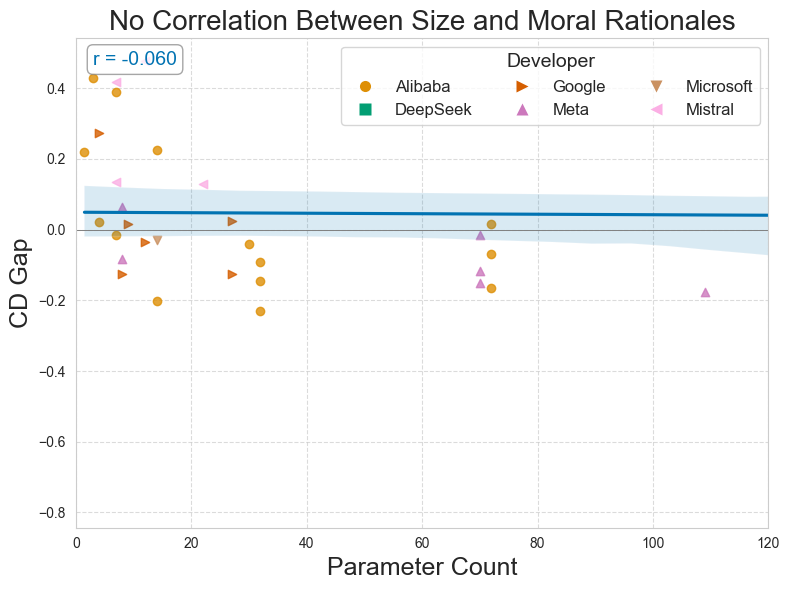

Pearson correlation: r = 0.423, p = 0.01006*
One-sample t-test (avg y ≠ 0): t = 31.784, p = 2.085e-27***
One-way ANOVA (by developer): F = 0.959, p = 0.4585


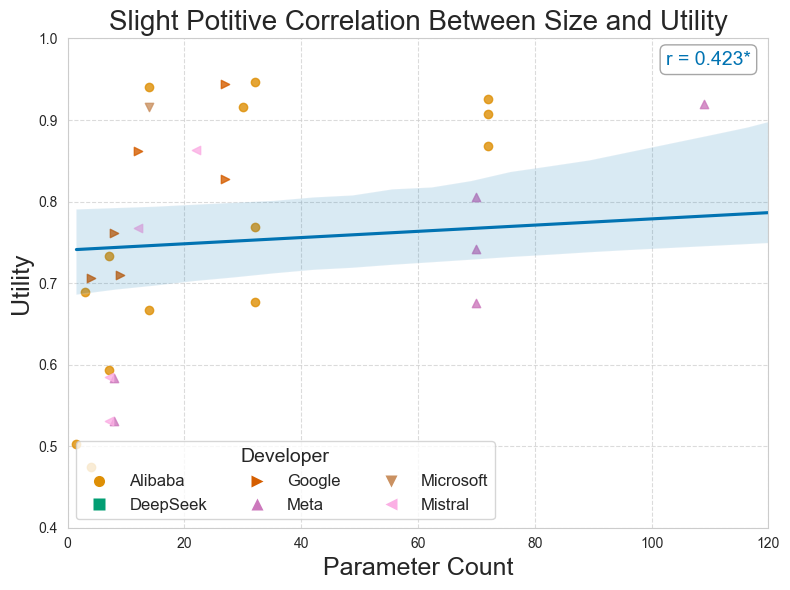

In [25]:
plot_metric_vs_metric_by_developer(
    avg_data_df.query("parameter_count < 700"),
    x_col="parameter_count",
    xlabel="Parameter Count",
    y_col="delta_CD",
    ylabel='CD Gap',
    reasoning_first=True,
    title="No Correlation Between Size and Moral Rationales",
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_utility_deltaCD_developer_reasoningFirst.pdf"),
    legend_location="upper right",
    # ylim=(-1, 1),
    xlim=(0, 120),
    ncols=3,
)

plot_metric_vs_metric_by_developer(
    avg_data_df.query("parameter_count < 700"),
    x_col="parameter_count",
    xlabel="Parameter Count",
    y_col="Overall_utility",
    ylabel="Utility",
    reasoning_first=True,
    title="Slight Potitive Correlation Between Size and Utility",
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_utility_deltaCD_developer_reasoningFirst.pdf"),
    legend_location="lower left",
    corr_placement="top_right",
    ylim=(0.4, 1),
    xlim=(0, 120),
    ncols=3,
)

Pearson correlation: r = -0.166, p = 0.2171
One-sample t-test (avg y ≠ 0): t = 1.996, p = 0.05076
One-way ANOVA (by developer): F = 2.181, p = 0.04574*


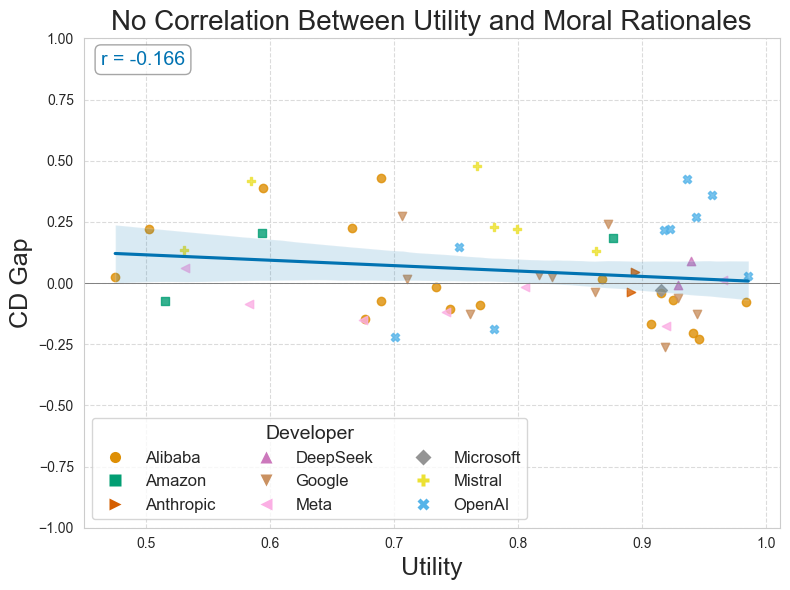

Pearson correlation: r = 0.642, p = 7.21e-08***
One-sample t-test (avg y ≠ 0): t = 34.508, p = 2.007e-39***
One-way ANOVA (by developer): F = 2.105, p = 0.05361


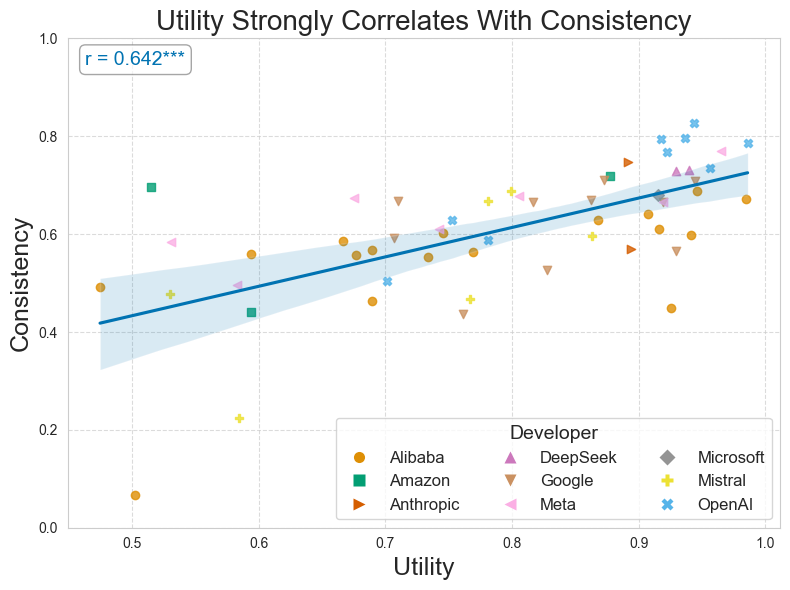

In [26]:
plot_metric_vs_metric_by_developer(
    avg_data_df,
    x_col="Overall_utility",
    xlabel="Utility",
    y_col="delta_CD",
    ylabel='CD Gap',
    reasoning_first=True,
    title="No Correlation Between Utility and Moral Rationales",
    save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_utility_deltaCD_developer_reasoningFirst.pdf"),
    legend_location="lower left",
    ylim=(-1, 1),
    ncols=3,
)

plot_metric_vs_metric_by_developer(
    avg_data_df,
    x_col="Overall_utility",
    xlabel="Utility",
    y_col="Overall_consistency",
    ylabel="Consistency",
    reasoning_first=True,
    title="Utility Strongly Correlates With Consistency",
    save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_utility_consistency_developer_reasoningFirst.pdf"),
    legend_location="lower right",
    ylim=(0, 1),
    ncols=3,
)

### Decision First vs Reasoning First

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_metric_by_reasoning_pairwise(
    df: pd.DataFrame,
    metric: str,
    ylabel: str = None,
    equal_group_size: bool = None,
    title: str = None,
    save_path: str = None,
    figsize: tuple = (8, 6),
    include_scatter: bool = True,
    include_lines: bool = True,
    paired_test: str = 'ttest',        # 'ttest' or 'wilcoxon'
    corr_method: str = 'pearson',      # 'pearson' or 'spearman'
    report: bool = True,                # if True, print test results
    print_dissenting_models: bool = False, # if True, print models with lower scores
):
    # 1) Optional filter on group size
    sub = df.copy()

    if equal_group_size is not None:
        sub = sub[sub['equal_group_size'] == equal_group_size]
        # keep only models with both conditions
        mask = sub.groupby('model_id')['reasoning_first'] \
                  .transform(lambda s: s.nunique() == 2)
        sub = sub[mask]
        before = sub[sub['reasoning_first'] == False][['model_id', metric]].copy()
        after  = sub[sub['reasoning_first'] == True][['model_id', metric]].copy()
    else:
        # average across group sizes
        agg = (
            sub
            .groupby(['model_id', 'reasoning_first'])[metric]
            .mean()
            .reset_index()
        )
        before = agg[agg['reasoning_first'] == False][['model_id', metric]].copy()
        after  = agg[agg['reasoning_first'] == True][['model_id', metric]].copy()

    # merge into paired table
    merged = pd.merge(
        before,
        after,
        on='model_id',
        suffixes=('_decision_first', '_reasoning_first')
    )

    # 2) Paired difference test
    x = merged[f"{metric}_decision_first"].values
    y = merged[f"{metric}_reasoning_first"].values

    stat, p = stats.shapiro(x - y)
    stars = p_to_stars(p)
    print(f"Shapiro-Wilk test for normality: W = {stat:.3f}, p = {p:.4g}{stars}")

    if paired_test == 'ttest':
        stat, p_pair = stats.ttest_rel(y, x, nan_policy='omit')
        test_name = 'Paired t-test'
    elif paired_test == 'wilcoxon':
        stat, p_pair = stats.wilcoxon(y, x)
        test_name = 'Wilcoxon signed-rank'
    else:
        raise ValueError("paired_test must be 'ttest' or 'wilcoxon'")
    pair_stars = p_to_stars(p_pair)

    # 3) Correlation
    if corr_method == 'pearson':
        r, p_corr = stats.pearsonr(x, y)
        corr_name = "Pearson's r"
    elif corr_method == 'spearman':
        r, p_corr = stats.spearmanr(x, y)
        corr_name = "Spearman's ρ"
    else:
        raise ValueError("corr_method must be 'pearson' or 'spearman'")
    corr_stars = p_to_stars(p_corr)

    # 4) Print results if requested
    print(f"{test_name} result: t = {stat:.3f}, p = {p_pair:.3g}{pair_stars}")
    print(f"{corr_name} result: r = {r:.3f}, p = {p_corr:.3g}{corr_stars}")

    if print_dissenting_models:
        dir1 = merged[merged[f"{metric}_decision_first"] > merged[f"{metric}_reasoning_first"]]
        dir2 = merged[merged[f"{metric}_decision_first"] < merged[f"{metric}_reasoning_first"]]
        if len(dir1) < len(dir2):
            print("Models with lower scores in left condition:")
            print('; '.join(dir1.model_id.tolist()))
        else:
            print("Models with lower scores in right condition:")
            print('; '.join(dir2.model_id.tolist()))

    # 5) Melt for plotting
    df_long = merged.melt(
        id_vars='model_id',
        value_vars=[f"{metric}_decision_first", f"{metric}_reasoning_first"],
        var_name='condition',
        value_name=metric
    )
    df_long['condition'] = df_long['condition'].map({
        f"{metric}_decision_first":  'Decide-then-Reason',
        f"{metric}_reasoning_first": 'Reason-then-Decide'
    })

    # 6) Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=figsize)

    sns.boxplot(
        data=df_long,
        x='condition', y=metric,
        color='steelblue', saturation=1,
        width=0.6, boxprops=dict(alpha=1),
        ax=ax,
    )

    if include_lines:
        sns.lineplot(
            data=df_long,
            x='condition', y=metric,
            units='model_id',
            estimator=None,
            color='black', alpha=0.5, linewidth=0.5,
            ax=ax,
        )
    if include_scatter:
        sns.scatterplot(
            data=df_long,
            x='condition', y=metric,
            color='black', edgecolor='black',
            alpha=0.5, s=30,
            ax=ax,
            zorder=3,
        )

    # labels & style
    ax.set_xlabel('')
    ax.set_ylabel(metric if not ylabel else ylabel, fontsize=18)
    ax.set_title(title or f"{metric.replace('_', ' ').title()} by Reasoning Order", fontsize=20)
    ax.tick_params(axis='x', labelsize=18)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

### Decision First vs Reasoning First

Shapiro-Wilk test for normality: W = 0.948, p = 0.01533*
Paired t-test result: t = -8.746, p = 4.65e-12***
Pearson's r result: r = 0.732, p = 1.02e-10***
Models with lower scores in right condition:
Qwen1.5-4B-Chat; gemma-2-27b-it; gemma-2-9b-it; llama-3-70b-instruct; llama-3.1-70b-instruct; qwen-2.5-7b-instruct


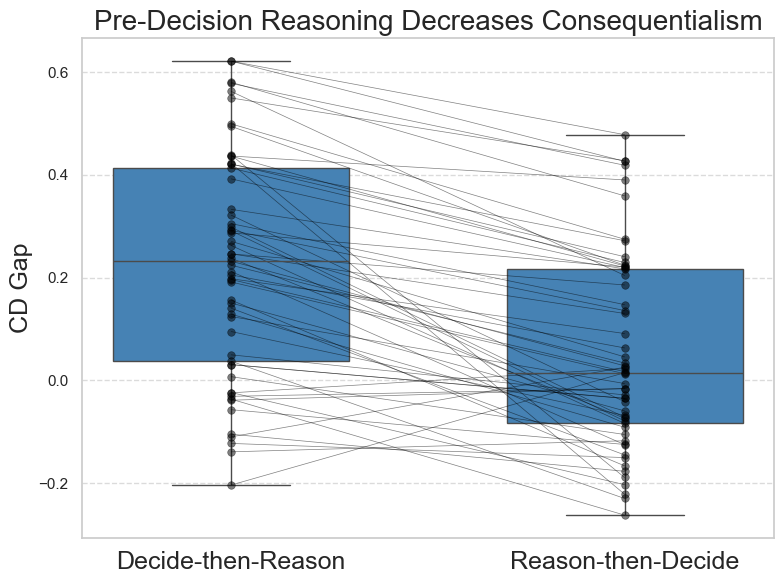

Shapiro-Wilk test for normality: W = 0.991, p = 0.9355
Paired t-test result: t = 8.667, p = 6.25e-12***
Pearson's r result: r = 0.671, p = 1.16e-08***
Models with lower scores in left condition:
gpt-4.1-2025-04-14; gpt-4.1-mini-2025-04-14; gemma-3-4b-it; mistral-large; mistral-large-2407; Qwen1.5-4B-Chat; Qwen2.5-1.5B-Instruct


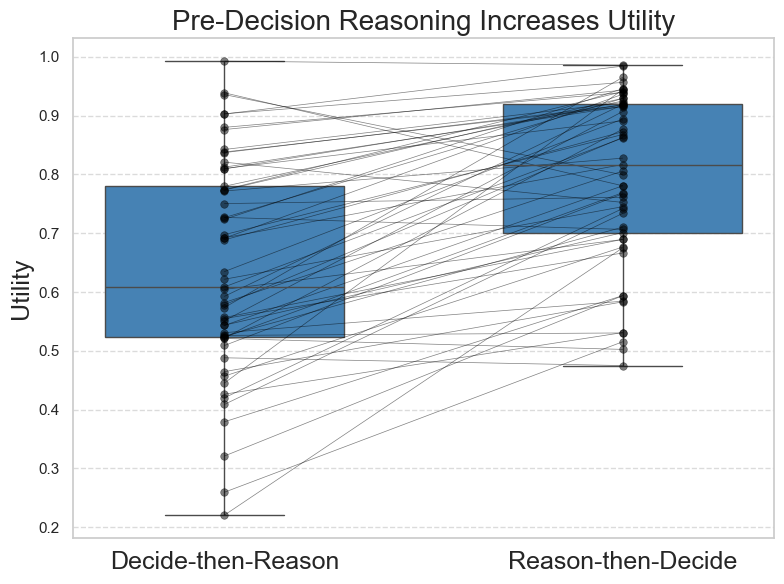

Shapiro-Wilk test for normality: W = 0.923, p = 0.001439**
Wilcoxon signed-rank result: t = 531.500, p = 0.0191*
Pearson's r result: r = 0.722, p = 2.33e-10***
Models with lower scores in left condition:
Qwen1.5-4B-Chat; Qwen2.5-3B-Instruct; deepseek-chat; gemini-2.0-flash-001; gemini-flash-1.5; gemini-flash-1.5-8b; gemini-pro-1.5; gemma-2-27b-it; gemma-2-9b-it; gemma-3-27b-it; gemma-3-4b-it; gpt-4.1-2025-04-14; gpt-4.1-mini-2025-04-14; gpt-4o-2024-08-06; gpt-4o-2024-11-20; llama-3.1-70b-instruct; llama-3.3-70b-instruct; mistral-large-2407; nova-lite-v1; nova-micro-v1; qwen-2-72b-instruct; qwen-max; qwen-plus; qwen3-30b-a3b:nothink


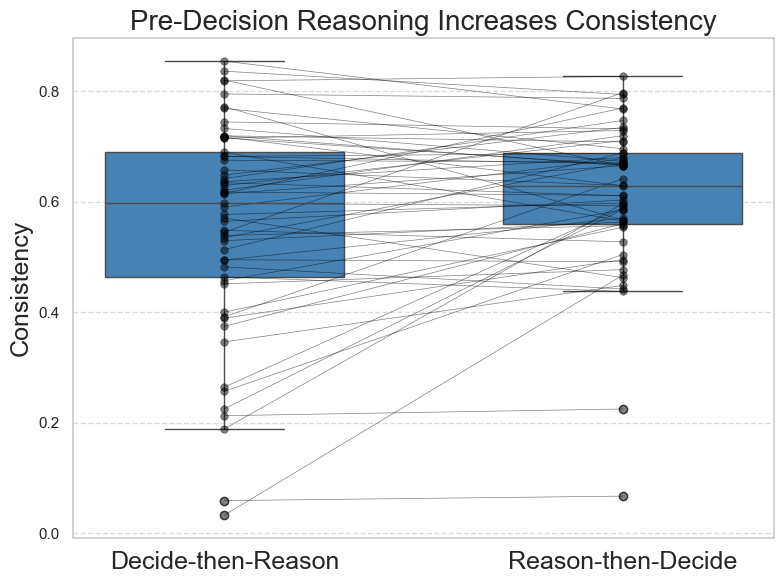

In [28]:
plot_metric_by_reasoning_pairwise(
    df=avg_data_df,
    metric='delta_CD',
    ylabel='CD Gap',
    # equal_group_size=False,
    title='Pre-Decision Reasoning Decreases Consequentialism',
    save_path=os.path.join(FIGURE_SAVE_DIR, "boxWithLines_reasoningOrder_deltaCD__.pdf"),
    paired_test='ttest',
    corr_method='pearson',
    include_scatter=True,
    include_lines=True,
    print_dissenting_models=True,
)

plot_metric_by_reasoning_pairwise(
    df=avg_data_df,
    metric='Overall_utility',
    ylabel='Utility',
    equal_group_size=False,
    title='Pre-Decision Reasoning Increases Utility',
    save_path=os.path.join(FIGURE_SAVE_DIR, "boxWithLines_reasoningOrder_utility__unequalGroups.pdf"),
    paired_test='ttest',
    corr_method='pearson',
    include_scatter=True,
    include_lines=True,
    print_dissenting_models=True,
)

plot_metric_by_reasoning_pairwise(
    df=avg_data_df,
    metric='Overall_consistency',
    ylabel='Consistency',
    # equal_group_size=False,
    title='Pre-Decision Reasoning Increases Consistency',
    # save_path=os.path.join(FIGURE_SAVE_DIR, "boxWithLines_reasoningOrder_consistency__.pdf"),
    paired_test='wilcoxon',
    corr_method='pearson',
    include_scatter=True,
    include_lines=True,
    print_dissenting_models=True,
)


#### DPO and Reasoning models

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_metric_by_model_type(
    df: pd.DataFrame,
    metric: str,
    ylabel: str = None,
    equal_group_size: bool = None,
    x_col: str = 'model_type',
    bar1: str = 'sft',
    bar2: str = 'dpo',
    title: str = None,
    save_path: str = None,
    figsize: tuple = (8, 6),
    include_connecting_lines: bool = True,
    paired_test: str = 'ttest',        # 'ttest' or 'wilcoxon'
    report: bool = True,               # if True, print test results
):
    # 1) Optional filter on equal_group_size
    sub = df.copy()
    if equal_group_size is not None:
        sub = sub[sub['equal_group_size'] == equal_group_size]

    # 2) Stats on the two groups
    bar1_rows = sub[sub[x_col] == bar1][metric].dropna()
    bar2_rows = sub[sub[x_col] == bar2][metric].dropna()

    if report:
        # normality checks
        stat_s, p_s = stats.shapiro(bar1_rows)
        stat_d, p_d = stats.shapiro(bar2_rows)
        print(f"{x_col}={bar1} normality Shapiro-Wilk: W={stat_s:.3f}, p={p_s:.3g}")
        print(f"{x_col}={bar2} normality Shapiro-Wilk: W={stat_d:.3f}, p={p_d:.3g}")

        if paired_test == 'ttest':
            stat, pval = stats.ttest_ind(bar1_rows, bar2_rows,
                                          equal_var=False, nan_policy='omit')
            print(f"Welch's t-test: t={stat:.3f}, p={pval:.3g}")
        elif paired_test == 'wilcoxon':
            if len(bar1_rows) == len(bar2_rows):
                stat, pval = stats.wilcoxon(bar1_rows, bar2_rows)
                print(f"Wilcoxon signed-rank: W={stat:.3f}, p={pval:.3g}")
            else:
                stat, pval = stats.mannwhitneyu(bar1_rows, bar2_rows,
                                                alternative='two-sided')
                print(f"Mann-Whitney U: U={stat:.3f}, p={pval:.3g}")
        else:
            raise ValueError("paired_test must be 'ttest' or 'wilcoxon'")

    # 3) Prepare long-form DataFrame for plotting
    df_long = sub[[x_col, metric]].dropna()

    # 4) Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=figsize)

    sns.boxplot(
        data=df_long,
        x=x_col, y=metric,
        color='b', saturation=1,
        width=0.6, boxprops=dict(alpha=1),
        ax=ax,
    )
    sns.scatterplot(
        data=df_long,
        x=x_col, y=metric,
        color='black', edgecolor='black',
        alpha=0.5, s=30,
        ax=ax,
        zorder=3,
    )

    # 5) Connecting lines
    if include_connecting_lines:
        # get actual x‐positions for each category
        xticks = ax.get_xticks()
        xticklabels = [lbl.get_text() for lbl in ax.get_xticklabels()]
        x_pos = dict(zip(xticklabels, xticks))
        x1, x2 = x_pos[bar1], x_pos[bar2]

        # subset to rows that have model_base and metric present
        sub2 = sub[[x_col, 'model_base', metric]].dropna(subset=[metric, 'model_base'])
        # for each base, connect every bar1 point to every bar2 point
        for mb, grp in sub2.groupby('model_base'):
            vals1 = grp.loc[grp[x_col] == bar1, metric].tolist()
            vals2 = grp.loc[grp[x_col] == bar2, metric].tolist()
            for v1 in vals1:
                for v2 in vals2:
                    ax.plot([x1, x2], [v1, v2],
                            color='gray', alpha=0.5, zorder=1)

    # 6) Labels & style
    ax.set_xlabel('')
    ax.set_ylabel(metric if ylabel is None else ylabel, fontsize=18)
    ax.set_title(
        title or f"{metric.replace('_',' ').title()} by Model Type",
        fontsize=20
    )
    ax.tick_params(axis='x', labelsize=18)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

model_type=sft normality Shapiro-Wilk: W=0.888, p=0.345
model_type=dpo normality Shapiro-Wilk: W=0.693, p=0.00014
Welch's t-test: t=-0.146, p=0.89


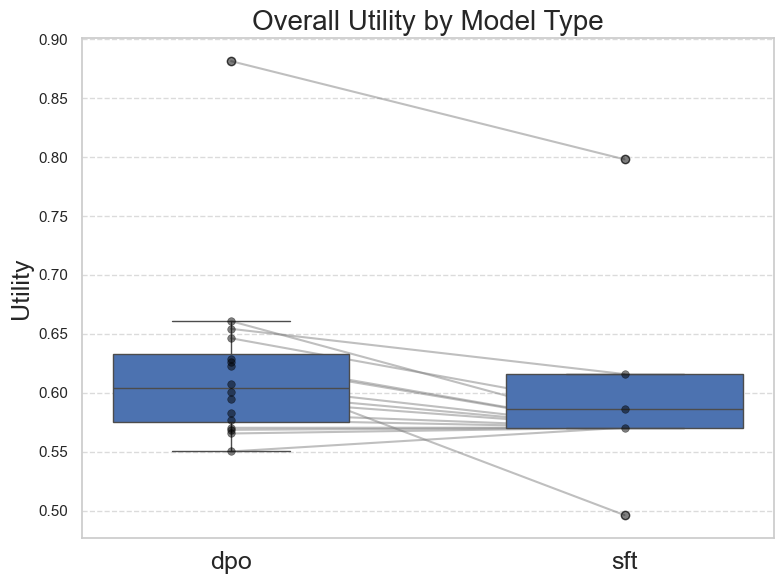

In [30]:
plot_metric_by_model_type(
    dpo_data_df,
    metric="Overall_utility",
    x_col="model_type",
    bar1="sft",
    bar2="dpo",
    ylabel="Utility",
    # title="Utility Scores Are Similar Across Phenomena",
    # equal_group_size=False,
    # save_path=os.path.join(FIGURE_SAVE_DIR, "bar_category_utility__unequalGroupsAndReasoningFirst.pdf"),
    # include_connecting_lines=False,
)

### DPO and Reasoning model barplots

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel


def plot_model_comparison(
    df,
    y_col='Overall_utility',
    y_label=None,
    title=None,
    figsize=(8, 6),
    left_color='steelblue',
    right_color='orange',
    ylim=None,
    save_path=None,
    add_error_bar=False,
):
    # 1) Aggregate: compute mean, std, count, and sem
    agg_df = (
        df
        .groupby(
            ['model_base', 'reasoning_model', 'model_id', 'model_name'],
            as_index=False
        )[y_col]
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
    agg_df['sem'] = agg_df['std'] / np.sqrt(agg_df['count'])

    # 2) Pivot on means for t-test
    pivot = agg_df.pivot(index='model_base', columns='reasoning_model', values='mean')
    cols = list(pivot.columns)
    if len(cols) != 2:
        raise ValueError(f"Expected exactly two reasoning_model values, found: {cols}")
    pivot = pivot.dropna(subset=cols)
    t_stat, p_val = ttest_rel(pivot[cols[0]], pivot[cols[1]])


    # # pivot so each row is one sample-pair
    # pivot_raw = (
    #     df
    #     .pivot_table(
    #         index=['model_base', 'sample_id'],      # align samples by scenario
    #         columns='reasoning_model',                # two cols: Traditional, Reasoning
    #         values=y_col
    #     )
    #     .dropna()  # drop any incomplete sample pairs
    # )

    # # extract the two aligned vectors
    # col1, col2 = pivot_raw.columns
    # t_stat, p_val = ttest_rel(pivot_raw[col1], pivot_raw[col2])


    stars = p_to_stars(p_val)
    print(f"Paired t-test on '{y_col}' — t = {t_stat:.4f}{stars}, p = {p_val:.4e}")

    # 3) Color & legend mappings
    color_map = {cols[0]: left_color, cols[1]: right_color}
    label_map = {cols[0]: 'Traditional', cols[1]: 'Reasoning'}

    # 4) Setup plotting
    bases = sorted(agg_df['model_base'].unique())
    width = 0.35
    fig, ax = plt.subplots(figsize=figsize)
    tick_positions, tick_labels = [], []

    # 5) Bars with errorbars
    for i, base in enumerate(bases):
        for j, rm in enumerate(cols):
            row = agg_df[
                (agg_df['model_base'] == base) &
                (agg_df['reasoning_model'] == rm)
            ].iloc[0]
            x = i + (j - 0.5) * width
            tick_positions.append(x)
            tick_labels.append(row['model_name'])
            ax.bar(
                x,
                row['mean'],
                width,
                color=color_map[rm],
                label=label_map[rm] if i == 0 else None,
                yerr=row['sem'] if add_error_bar else None,
                capsize=5
            )

    # 6) Ticks and labels
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=30, ha='right')

    if y_label is None:
        y_label = y_col.replace('_', ' ').title()
    ax.set_ylabel(y_label, fontsize=18)
    ax.set_title(title or y_label, fontsize=20)

    # 7) Legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title='Model Type',
              fontsize=12, title_fontsize=14, ncol=2)

    # 8) Y‐limit and layout
    if ylim:
        ax.set_ylim(ylim)

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

Paired t-test on 'Overall_utility' — t = -2.7020*, p = 4.2682e-02


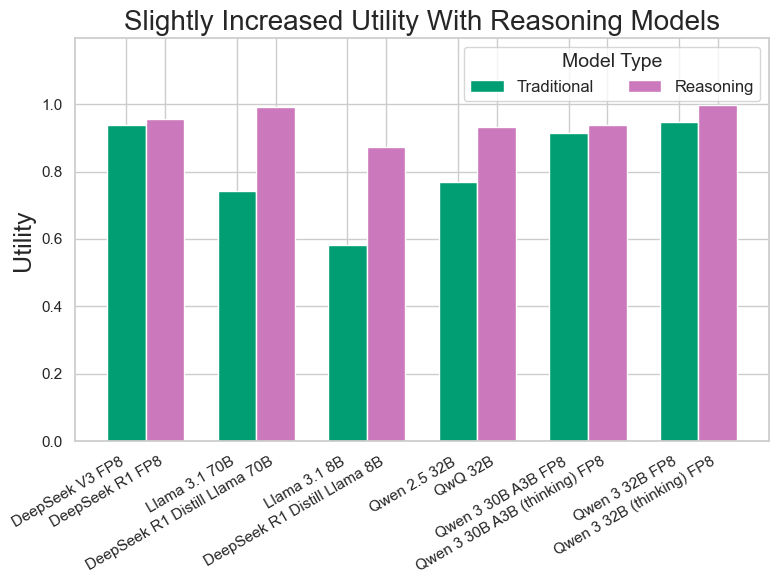

In [32]:
palette = sns.color_palette('colorblind')
plot_model_comparison(
    reasoning_merged_df,
    y_col='Overall_utility',
    y_label='Utility',
    title='Slightly Increased Utility With Reasoning Models',
    ylim=(0, 1.195),
    left_color=palette[2],
    right_color=palette[4],
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_reasoningModel_utility__reasoningFirst.pdf'),
    # add_error_bar=True,
)


Paired t-test on 'delta_CD' — t = -2.7395*, p = 4.0818e-02


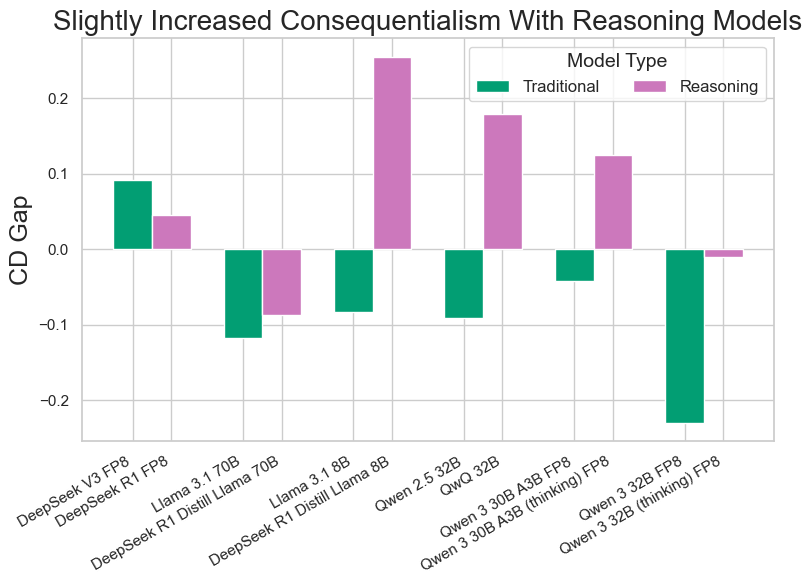

In [33]:
palette = sns.color_palette('colorblind')
plot_model_comparison(
    reasoning_merged_df,
    # reasoning_merged_df.query("equal_group_size == True"),
    y_col='delta_CD',
    y_label='CD Gap',
    title='Slightly Increased Consequentialism With Reasoning Models',
    left_color=palette[2],
    right_color=palette[4],
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_reasoningModel_deltaCD__reasoningFirst.pdf'),
    # add_error_bar=True,
    # ylim=(-1, 1.2),
)


Paired t-test on 'delta_CD' — t = -1.4285, p = 2.1251e-01


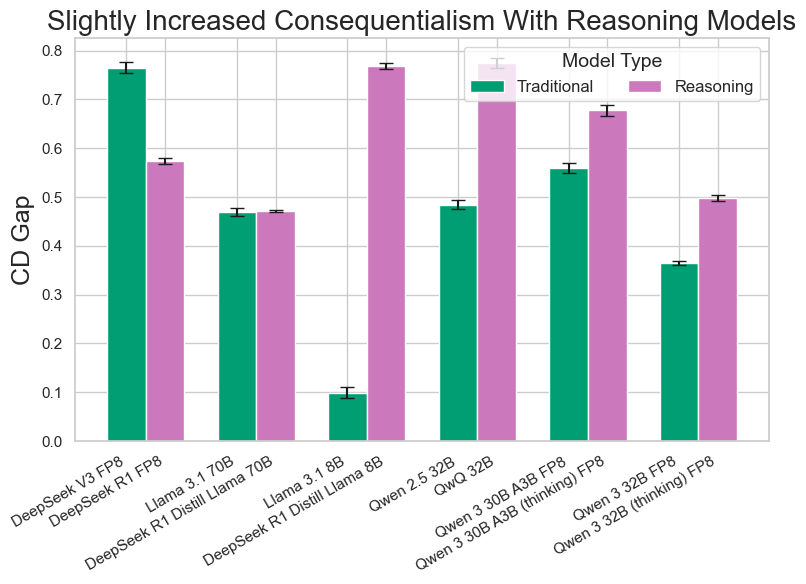

In [34]:
palette = sns.color_palette('colorblind')
plot_model_comparison(
    reasoning_merged_df.query("equal_group_size == False"),
    # reasoning_merged_df.query("equal_group_size == True"),
    y_col='delta_CD',
    y_label='CD Gap',
    title='Slightly Increased Consequentialism With Reasoning Models',
    left_color=palette[2],
    right_color=palette[4],
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_reasoningModel_deltaCD__reasoningFirst.pdf'),
    add_error_bar=True,
    # ylim=(-1, 1.2),
)


Paired t-test on 'delta_CD' — t = -3.2546*, p = 2.2580e-02


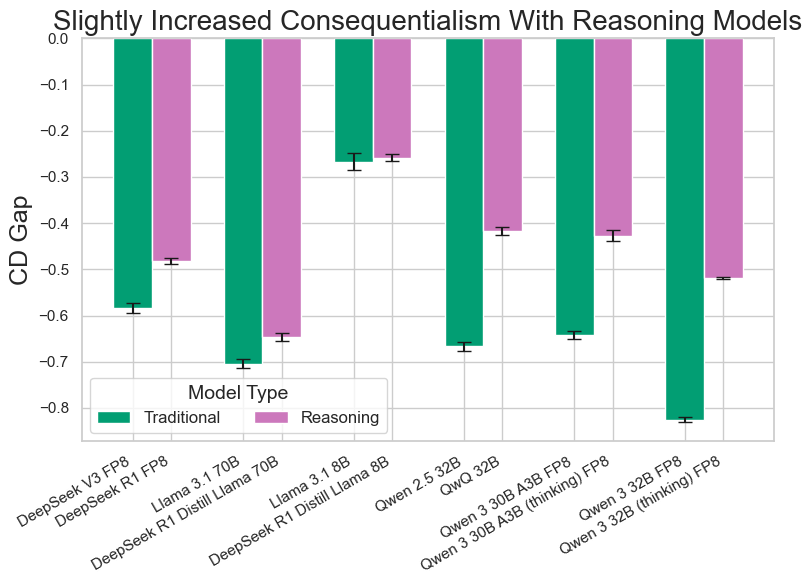

In [35]:
palette = sns.color_palette('colorblind')
plot_model_comparison(
    reasoning_merged_df.query("equal_group_size == True"),
    # reasoning_merged_df.query("equal_group_size == True"),
    y_col='delta_CD',
    y_label='CD Gap',
    title='Slightly Increased Consequentialism With Reasoning Models',
    left_color=palette[2],
    right_color=palette[4],
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'bar_reasoningModel_deltaCD__reasoningFirst.pdf'),
    add_error_bar=True,
    # ylim=(-1, 1.2),
)


### SFT Tables

In [36]:
# 1) Aggregate mean metrics and carry one model_name forward
mask = ~dpo_merged_df['model_id'].str.contains('tulu-2|tulu-v2.5', regex=True)
filtered = dpo_merged_df[mask]

agg = (
    filtered
      .groupby(['model_base', 'model_type'], as_index=False)
      .agg({
          'delta_CD': 'mean',
          'Overall_utility': 'mean',
          'model_name': 'first'
      })
      .rename(columns={
          'delta_CD': 'mean_delta_CD',
          'Overall_utility': 'mean_utility',
          'model_name': 'model_name'
      })
)

# 2) Pivot to one row per base, with separate columns for sft vs dpo
pivot = agg.pivot(
    index='model_base',
    columns='model_type',
    values=['model_name', 'mean_delta_CD', 'mean_utility']
)

# flatten the MultiIndex
pivot.columns = [
    f"{model_type}_{metric}"
    for metric, model_type in pivot.columns
]
pivot = pivot.reset_index()

# 2b) Compute the shifts: dpo minus sft
pivot['delta_CD']      = pivot['dpo_mean_delta_CD']  - pivot['sft_mean_delta_CD']
pivot['delta_utility'] = pivot['dpo_mean_utility']   - pivot['sft_mean_utility']

# 2c) Build a short display name by dropping the last word of the SFT model_name
pivot['short_name'] = (
    pivot['sft_model_name']
      .str.split()
      .apply(lambda L: ' '.join(L[:-1]))
)
pivot = pivot.sort_values('delta_utility').reset_index(drop=True)
# 3) Build the LaTeX table with a multirow for the name
latex_table = r"""
\begin{table}[ht]
    \centering
    \setlength{\tabcolsep}{3pt} % extra-tight columns
    \begin{tabularx}{\columnwidth}{l l *{2}{>{\arraybackslash}X}}
    \toprule
    Model & Type & \CD~($\boldsymbol\Delta$) & \util~($\boldsymbol\Delta$) \\
    \midrule
"""

for i, row in pivot.iterrows():
    name  = row['short_name']
    cd_s  = row['sft_mean_delta_CD']
    u_s   = row['sft_mean_utility']
    cd_d  = row['dpo_mean_delta_CD']
    du    = row['delta_CD']
    u_d   = row['dpo_mean_utility']
    duu   = row['delta_utility']
    # multirow cell for the name, spanning 2 rows, vertically centered
    latex_table += (
        f"    \\multirow{{2}}{{*}}{{{name}}} & SFT & "
        f"{cd_s:.2f} & {u_s:.2f} \\\\\n"
    )
    # second row: empty first cell (continued multirow), then DPO
    latex_table += (
        f"    & DPO & "
        f"{cd_d:.2f} (\\textbf{{{du:+.2f}}}) & "
        f"{u_d:.2f} (\\textbf{{{duu:+.2f}}}) \\\\\n"
    )
    if i < len(pivot) - 1:
        latex_table += "    \\midrule\n"

latex_table += r"""    \bottomrule
    \end{tabularx}
    \caption{Comparison of SFT vs DPO models. Raw means shown in plain font;
    bold‐face deltas are DPO–SFT shifts.}
    \label{tab:sft_vs_dpo_models}
\end{table}
"""

print(latex_table)


\begin{table}[ht]
    \centering
    \setlength{\tabcolsep}{3pt} % extra-tight columns
    \begin{tabularx}{\columnwidth}{l l *{2}{>{\arraybackslash}X}}
    \toprule
    Model & Type & \CD~($\boldsymbol\Delta$) & \util~($\boldsymbol\Delta$) \\
    \midrule
    \multirow{2}{*}{OLMo 2 32B} & SFT & 0.26 & 0.62 \\
    & DPO & 0.15 (\textbf{-0.12}) & 0.65 (\textbf{+0.04}) \\
    \midrule
    \multirow{2}{*}{OLMo 2 13B} & SFT & 0.04 & 0.59 \\
    & DPO & -0.10 (\textbf{-0.15}) & 0.65 (\textbf{+0.06}) \\
    \midrule
    \multirow{2}{*}{Tülu 3 70B} & SFT & -0.07 & 0.80 \\
    & DPO & -0.12 (\textbf{-0.05}) & 0.88 (\textbf{+0.08}) \\
    \midrule
    \multirow{2}{*}{Instella 3B} & SFT & 0.26 & 0.50 \\
    & DPO & 0.33 (\textbf{+0.07}) & 0.62 (\textbf{+0.13}) \\
    \bottomrule
    \end{tabularx}
    \caption{Comparison of SFT vs DPO models. Raw means shown in plain font;
    bold‐face deltas are DPO–SFT shifts.}
    \label{tab:sft_vs_dpo_models}
\end{table}



### Reasoning model tables

In [37]:
# 1) Aggregate mean metrics and carry the model_name forward
agg = (
    reasoning_merged_df
      .groupby(['model_base', 'reasoning_model'], as_index=False)
      .agg({
          'delta_CD': 'mean',
          'Overall_utility': 'mean',
          'model_name': 'first'
      })
      .rename(columns={
          'delta_CD': 'mean_delta_CD',
          'Overall_utility': 'mean_utility',
          'model_name': 'model_name'
      })
)

# 2) Pivot so we have one row per base, with separate columns
pivot = agg.pivot(
    index='model_base',
    columns='reasoning_model',
    values=['model_name', 'mean_delta_CD', 'mean_utility']
)
pivot.columns = [
    f"{'trad' if not rm else 'reason'}_{col}"
    for col, rm in pivot.columns
]
pivot = pivot.reset_index()

# 2b) Compute the delta_CD Gap and sort by it
pivot['delta_utility'] = pivot['reason_mean_utility'] - pivot['trad_mean_utility']
pivot['delta_CD'] = pivot['reason_mean_delta_CD'] - pivot['trad_mean_delta_CD']
pivot = pivot.sort_values('delta_utility').reset_index()  # ascending: smallest shift first

# 3) Build the LaTeX table, using the carried-through model_name fields
latex_table = r"""
\begin{table}
    \centering
    \setlength{\tabcolsep}{4pt}
    \begin{tabularx}{\columnwidth}{l *{2}{>{arraybackslash}X}}
    \toprule
    Model & \CD~($\boldsymbol\Delta$) & \util~($\boldsymbol\Delta$) \\
    \midrule
"""

for row_num, row in pivot.iterrows():
    # Traditional row: just the raw means
    latex_table += (
        f"    {row['trad_model_name'].strip()} & "
        f"{row['trad_mean_delta_CD']:.2f} & "
        f"{row['trad_mean_utility']:.2f} \\\\\n"
    )
    # Reasoning row: raw + (delta)
    latex_table += (
        "    \\rotatebox[origin=c]{180}{$\\Lsh$}"
        f"{row['reason_model_name'].strip()} & "
        f"{row['reason_mean_delta_CD']:.2f} "
        f"(\\textbf{{{row['delta_CD']:+.2f}}}) & "
        f"{row['reason_mean_utility']:.2f} "
        f"(\\textbf{{{row['delta_utility']:+.2f}}}) \\\\\n"
    )
    if row_num < len(pivot) - 1:
        latex_table += "    \\midrule\n"

latex_table += r"""    \bottomrule
    \end{tabularx}
    \caption{Your caption here}
    \label{tab:reasoning_models}
\end{table}
"""

# Optional name cleanups
latex_table = latex_table.replace(' FP8', '')
latex_table = latex_table.replace('DeepSeek R1 Distill', 'R1')
latex_table = latex_table.replace('Qwen 3', 'Qwen3')
latex_table = latex_table.replace('(thinking)', 'T')

print(latex_table)


\begin{table}
    \centering
    \setlength{\tabcolsep}{4pt}
    \begin{tabularx}{\columnwidth}{l *{2}{>{arraybackslash}X}}
    \toprule
    Model & \CD~($\boldsymbol\Delta$) & \util~($\boldsymbol\Delta$) \\
    \midrule
    DeepSeek V3 & 0.09 & 0.94 \\
    \rotatebox[origin=c]{180}{$\Lsh$}DeepSeek R1 & 0.05 (\textbf{-0.05}) & 0.96 (\textbf{+0.02}) \\
    \midrule
    Qwen3 30B A3B & -0.04 & 0.92 \\
    \rotatebox[origin=c]{180}{$\Lsh$}Qwen3 30B A3B T & 0.13 (\textbf{+0.17}) & 0.94 (\textbf{+0.02}) \\
    \midrule
    Qwen3 32B & -0.23 & 0.95 \\
    \rotatebox[origin=c]{180}{$\Lsh$}Qwen3 32B T & -0.01 (\textbf{+0.22}) & 1.00 (\textbf{+0.05}) \\
    \midrule
    Qwen 2.5 32B & -0.09 & 0.77 \\
    \rotatebox[origin=c]{180}{$\Lsh$}QwQ 32B & 0.18 (\textbf{+0.27}) & 0.93 (\textbf{+0.16}) \\
    \midrule
    Llama 3.1 70B & -0.12 & 0.74 \\
    \rotatebox[origin=c]{180}{$\Lsh$}R1 Llama 70B & -0.09 (\textbf{+0.03}) & 0.99 (\textbf{+0.25}) \\
    \midrule
    Llama 3.1 8B & -0.08 & 0.58 \\
   

### Boxplots across phenomenon categories

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, ttest_1samp

def plot_metric_by_phenomenon(
    df: pd.DataFrame,
    metric_prefix: str,
    phenomena: list[str],
    ylabel: str = None,
    title: str = None,
    equal_group_size: bool | None = None,
    reasoning_first: bool | None = None,
    include_scatter: bool = False,
    include_lines: bool = False,           # NEW: whether to draw connecting lines
    save_path: str = None,
    figsize: tuple = (8, 6),
):
    """
    Plot boxplots (with optional strip points and connecting lines) of "<phenomenon>_<metric_prefix>"
    for each phenomenon category.
    """
    # 1) Pick up available columns
    if metric_prefix == "delta":
        metric_cols = [f"delta_{p}" for p in phenomena if f"delta_{p}" in df.columns]
    else:
        metric_cols = [f"{p}_{metric_prefix}" for p in phenomena if f"{p}_{metric_prefix}" in df.columns]

    # 2) Apply equal_group_size filter if requested
    sub = df[df["equal_group_size"] == equal_group_size].copy() if equal_group_size is not None else df.copy()

    # 3) Average per model
    summary = (
        sub
        .groupby("model_id")[metric_cols]
        .mean()
        .reset_index()
    )

    # 4) Melt to long format
    df_long = summary.melt(
        id_vars="model_id",
        value_vars=metric_cols,
        var_name="Phenomenon",
        value_name=metric_prefix
    )
    # clean up names
    suffix = "delta_" if metric_prefix=="delta" else f"_{metric_prefix}"
    df_long["Phenomenon"] = df_long["Phenomenon"].str.replace(suffix, "", regex=False)

    # ─── HYPOTHESIS TESTS ────────────────────────────────────────────────
    print("One-sample t-tests against 0:")
    groups = {ph: grp[metric_prefix].dropna() for ph, grp in df_long.groupby("Phenomenon")}
    for ph, vals in groups.items():
        if len(vals)>1:
            t_stat, p_val = ttest_1samp(vals, 0.0)
            print(f"  {ph:15s}: t = {t_stat:.3f}, p = {p_val:.4g}")
        else:
            print(f"  {ph:15s}: not enough data")

    # ANOVA
    samples = [v for v in groups.values() if len(v)>1]
    if len(samples)>1:
        f_stat, p_val = f_oneway(*samples)
        print(f"\nOne-way ANOVA: F = {f_stat:.3f}, p = {p_val:.4g}")
    else:
        print("\nOne-way ANOVA: insufficient groups")

    # Pairwise
    print("\nPairwise t-tests:")
    phs = list(groups.keys())
    for i in range(len(phs)):
        for j in range(i+1, len(phs)):
            a, b = phs[i], phs[j]
            va, vb = groups[a], groups[b]
            if len(va)>1 and len(vb)>1:
                t_stat, p_val = ttest_ind(va, vb, equal_var=False)
                print(f"  {a:15s} vs {b:15s}: t = {t_stat:.3f}, p = {p_val:.4g}")
            else:
                print(f"  {a:15s} vs {b:15s}: insufficient data")

    # ─── PLOTTING ─────────────────────────────────────────────────────────
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=figsize)

    # 1) Boxplot
    sns.boxplot(
        data=df_long,
        x="Phenomenon",
        y=metric_prefix,
        ax=ax,
        color="steelblue",
        saturation=1,
        width=0.6,
        showcaps=True,
        boxprops=dict(linewidth=0.5),
        whiskerprops=dict(linewidth=0.5),
        medianprops=dict(linewidth=0.5),
        flierprops=dict(markersize=4, markeredgewidth=0.5),
        notch=False,
    )

    # 2) Connecting lines (one line per model)
    if include_lines:
        sns.lineplot(
            data=df_long,
            x="Phenomenon",
            y=metric_prefix,
            units="model_id",
            estimator=None,
            color="black",
            alpha=0.3,
            linewidth=0.7,
            ax=ax,
        )

    # 3) Scatter points
    if include_scatter:
        sns.stripplot(
            data=df_long,
            x="Phenomenon",
            y=metric_prefix,
            size=4,
            color="black",
            alpha=0.6,
            jitter=False,
            dodge=False,
            ax=ax,
            zorder=2,
        )

    # Labels & styling
    ax.set_xlabel("Demographic Dimension", fontsize=18)
    ax.set_ylabel(
        ylabel or metric_prefix.replace("_", " ").title(),
        fontsize=18
    )
    ax.set_title(
        title or f"{metric_prefix.replace('_', ' ').title()} by Demographic Dimension",
        fontsize=20
    )
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

### Metrics across phenomenon categories

One-sample t-tests against 0:
  Age            : t = 10.049, p = 3.832e-14
  Fitness        : t = 0.745, p = 0.4595
  Gender         : t = -5.532, p = 8.666e-07
  SocialValue    : t = -1.768, p = 0.08251

One-way ANOVA: F = 55.360, p = 8.21e-27

Pairwise t-tests:
  Age             vs Fitness        : t = 7.213, p = 7.717e-11
  Age             vs Gender         : t = 11.382, p = 7.113e-20
  Age             vs SocialValue    : t = 9.331, p = 3.465e-15
  Fitness         vs Gender         : t = 4.178, p = 5.937e-05
  Fitness         vs SocialValue    : t = 1.685, p = 0.09495
  Gender          vs SocialValue    : t = -2.862, p = 0.005036


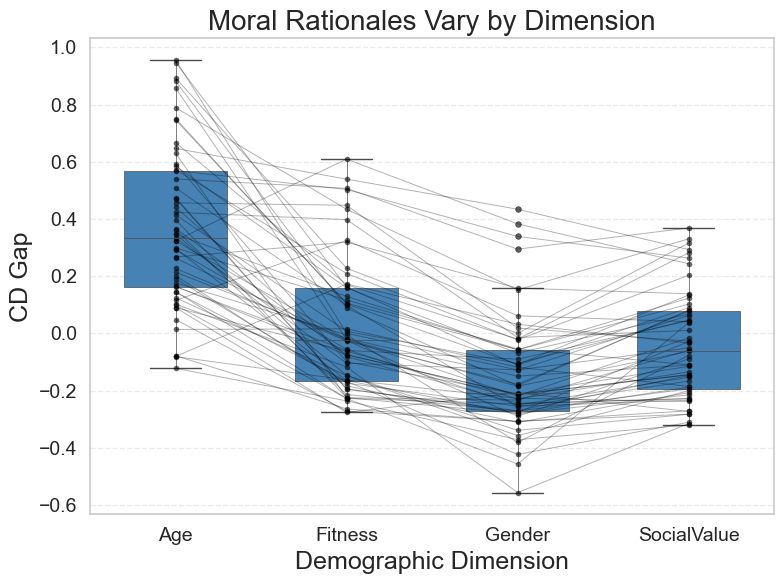

One-sample t-tests against 0:
  Age            : t = 40.197, p = 5.412e-43
  Fitness        : t = 38.073, p = 1.017e-41
  Gender         : t = 41.922, p = 5.544e-44
  SocialValue    : t = 42.045, p = 4.725e-44

One-way ANOVA: F = 1.185, p = 0.3161

Pairwise t-tests:
  Age             vs Fitness        : t = -0.417, p = 0.6777
  Age             vs Gender         : t = -1.326, p = 0.1876
  Age             vs SocialValue    : t = 0.510, p = 0.6112
  Fitness         vs Gender         : t = -0.863, p = 0.3898
  Fitness         vs SocialValue    : t = 0.919, p = 0.3599
  Gender          vs SocialValue    : t = 1.875, p = 0.06337


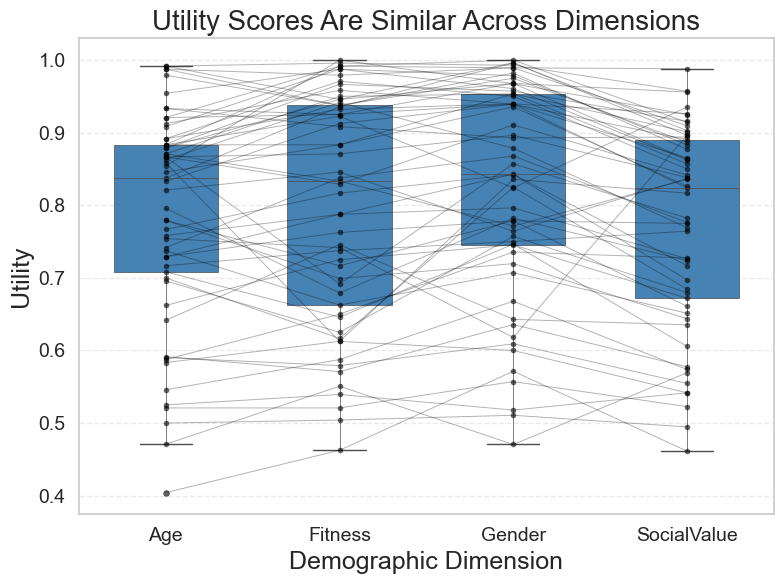

One-sample t-tests against 0:
  Age            : t = 27.156, p = 6.37e-34
  Fitness        : t = 30.489, p = 1.46e-36
  Gender         : t = 32.131, p = 9.04e-38
  SocialValue    : t = 34.077, p = 3.934e-39

One-way ANOVA: F = 34.125, p = 3.33e-18

Pairwise t-tests:
  Age             vs Fitness        : t = 2.598, p = 0.01071
  Age             vs Gender         : t = 8.960, p = 6.439e-14
  Age             vs SocialValue    : t = 0.612, p = 0.5418
  Fitness         vs Gender         : t = 7.239, p = 1.008e-10
  Fitness         vs SocialValue    : t = -2.294, p = 0.02368
  Gender          vs SocialValue    : t = -9.984, p = 1.189e-16


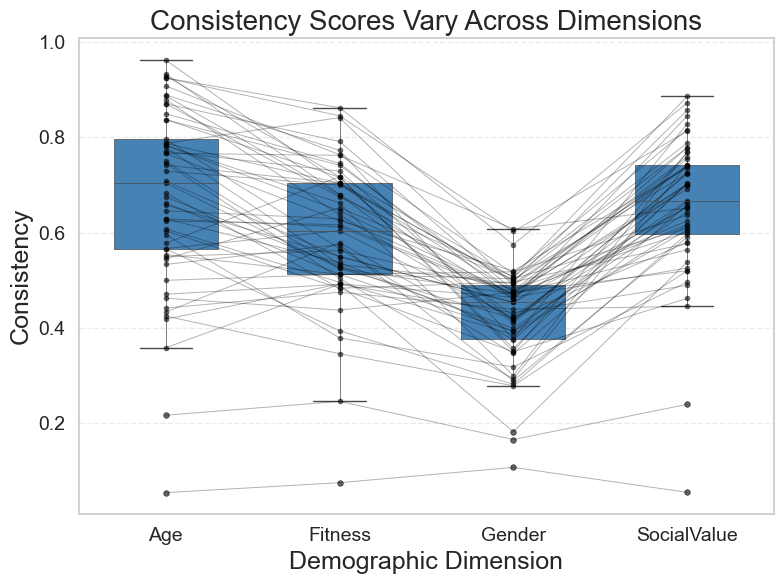

In [86]:
phenomena = list(ORDER.keys())

sub = avg_data_df[avg_data_df['reasoning_first'] == True]

# Overall (no group-size restriction)
plot_metric_by_phenomenon(
    df=sub,
    metric_prefix="delta",
    phenomena=phenomena,
    ylabel='CD Gap',
    title="Moral Rationales Vary by Dimension",
    # equal_group_size=False,
    include_scatter=True,
    include_lines=True,
    save_path=os.path.join(FIGURE_SAVE_DIR, "boxWithLines_category_deltaCD__reasoningFirst.pdf"),
)

# filter to equal_group_size = False:
plot_metric_by_phenomenon(
    df=sub,
    metric_prefix="utility",
    phenomena=phenomena,
    ylabel="Utility",
    title="Utility Scores Are Similar Across Dimensions",
    equal_group_size=False,
    include_scatter=True,
    include_lines=True,
    save_path=os.path.join(FIGURE_SAVE_DIR, "boxWithLines_category_utility__unequalGroupsAndReasoningFirst.pdf"),
)

plot_metric_by_phenomenon(
    df=sub,
    metric_prefix="consistency",
    phenomena=phenomena,
    ylabel="Consistency",
    title="Consistency Scores Vary Across Dimensions",
    # equal_group_size=False,
    include_scatter=True,
    include_lines=True,
    # save_path=os.path.join(FIGURE_SAVE_DIR, "bar_category_consistency__ReasoningFirst.pdf"),
)

In [40]:
import pandas as pd

def generate_scenario_comparison_latex_table(
    df: pd.DataFrame,
    phenomena_names: list[str],
    phenomena_short_names: list[str] = None,
    caption: str = "Comparison of Mean Utility and CD Gap Metrics by Scenario.",
    label: str = "tab:scenario_comparison",
    value_precision: int = 3,
    delta_precision: int = 3,
) -> str:
    """
    Generates a LaTeX table comparing metrics for 'Decision First' vs. 'Reasoning First' scenarios.

    The table will show:
    - Rows: Post-Decision (Decision First), Pre-Decision (Reasoning First), Delta (Pre - Post)
    - Main Columns: Utility, CD Gap (deltaCD)
    - Sub-columns: Overall, and one for each phenomenon category.
    - The Delta row shows (Pre-Decision - Post-Decision) values, bolded and signed.

    Args:
        df (pd.DataFrame): DataFrame containing the data. Expected columns include:
                           'reasoning_first' (bool),
                           'Overall_utility', 'delta_CD',
                           and for each phenomenon 'P' in phenomena_names:
                           'P_utility', 'delta_P'.
                           This DataFrame should have one row per unique unit of observation
                           (e.g., model) for each 'reasoning_first' condition.
                           The function will then average these metrics across units.
        phenomena_names (list[str]): List of full phenomenon names. These are used to
                                     find the corresponding data columns (e.g., "Age_utility", "delta_Age").
        phenomena_short_names (list[str], optional): List of short names for phenomena,
                                                     used as headers in the table.
                                                     If None, phenomena_names will be used.
                                                     Must match the order and length of
                                                     phenomena_names after filtering for
                                                     existing columns.
        caption (str): Caption for the LaTeX table.
        label (str): Label for the LaTeX table.
        value_precision (int): Number of decimal places for regular metric values.
        delta_precision (int): Number of decimal places for delta values.

    Returns:
        str: The LaTeX table code as a string.
    """

    # 0) Prepare phenomenon names and column lists
    if phenomena_short_names is None:
        phenomena_short_names_to_use = list(phenomena_names)
    else:
        if len(phenomena_names) != len(phenomena_short_names):
            raise ValueError("phenomena_names and phenomena_short_names must have the same length.")
        phenomena_short_names_to_use = list(phenomena_short_names)

    actual_phenomena_full = []
    actual_phenomena_short = []
    utility_phenom_cols = []
    delta_cd_phenom_cols = []

    for i, p_full in enumerate(phenomena_names):
        util_col = f"{p_full}_utility"
        delta_col = f"delta_{p_full}"
        if util_col in df.columns and delta_col in df.columns:
            actual_phenomena_full.append(p_full)
            actual_phenomena_short.append(phenomena_short_names_to_use[i])
            utility_phenom_cols.append(util_col)
            delta_cd_phenom_cols.append(delta_col)
        else:
            print(f"Warning: Data for phenomenon '{p_full}' (columns {util_col} or {delta_col}) not found. Skipping.")

    if not actual_phenomena_full and (utility_phenom_cols or delta_cd_phenom_cols):
        print("Warning: Mismatch in processed phenomenon lists. Breakdown might be incomplete.")
    elif not actual_phenomena_full:
        print("Warning: No phenomenon data found to include in breakdown.")

    # 1) Aggregate mean metrics
    all_metrics_to_agg = ['Overall_utility', 'delta_CD'] + utility_phenom_cols + delta_cd_phenom_cols

    missing_essential_cols = [col for col in ['Overall_utility', 'delta_CD'] if col not in df.columns]
    if missing_essential_cols:
        raise ValueError(f"Missing essential columns in DataFrame: {missing_essential_cols}")

    if 'reasoning_first' not in df.columns:
        raise ValueError("Missing 'reasoning_first' column in DataFrame.")

    aggregated_data = (
        df.groupby('reasoning_first')[all_metrics_to_agg]
        .mean()
    )

    if True not in aggregated_data.index or False not in aggregated_data.index:
        raise ValueError("Data for one or both 'reasoning_first' conditions (True/False) is missing after aggregation.")

    post_decision_metrics = aggregated_data.loc[False]
    pre_decision_metrics = aggregated_data.loc[True]
    delta_values = pre_decision_metrics - post_decision_metrics

    # 2) Build the LaTeX table
    num_phenomena = len(actual_phenomena_short)
    num_util_cols = 1 + num_phenomena
    num_cd_cols = 1 + num_phenomena

    col_spec = "@{}l"
    col_spec += " | " + "r" * num_util_cols
    col_spec += " | " + "r" * num_cd_cols + "@{}"

    latex_table = f"""\\begin{{table*}}[htbp!]
    \\centering
    \\setlength{{\\tabcolsep}}{{3pt}} % Adjust column separation as needed
    \\begin{{tabular}}{{{col_spec}}}
    \\toprule
"""

    latex_table += (
        "     & "
        rf"\multicolumn{{{num_util_cols}}}{{c}}{{\util}} & "
        rf"\multicolumn{{{num_cd_cols}}}{{c}}{{\CD}} \\" + "\n"
    )

    phenom_header_str = ""
    if actual_phenomena_short:
        phenom_header_str = " & ".join(s.replace("_", "\\_") for s in actual_phenomena_short)

    latex_table += "    \\multicolumn{1}{c|}{\\textbf{Reasoning}}"
    latex_table += " & \\textbf{Overall}"
    if actual_phenomena_short: latex_table += " & " + phenom_header_str
    latex_table += " & \\textbf{Overall}"
    if actual_phenomena_short: latex_table += " & " + phenom_header_str
    latex_table += r" \\" + "\n"

    util_col_start_idx = 2
    util_col_end_idx = util_col_start_idx + num_util_cols -1
    cd_col_start_idx = util_col_end_idx + 1
    cd_col_end_idx = cd_col_start_idx + num_cd_cols -1

    latex_table += f"    \\cmidrule(lr){{{util_col_start_idx}-{util_col_end_idx}}} "
    latex_table += f"\\cmidrule(lr){{{cd_col_start_idx}-{cd_col_end_idx}}}\n"
    latex_table += r"    \midrule" + "\n"

    # Helper function to format a row segment for base metric values
    def format_base_metrics_segment(metrics_series, overall_col_name, phenom_cols_list_ordered, precision):
        segment_str = f"\\textbf{{{metrics_series[overall_col_name]:.{precision}f}}}"
        for p_col in phenom_cols_list_ordered:
            if p_col in metrics_series:
                segment_str += f" & {metrics_series[p_col]:.{precision}f}"
            else:
                segment_str += " & --"
        return segment_str

    # Helper function to format a row segment for Delta values
    def format_delta_metrics_segment(delta_metrics_series, overall_col_name, phenom_cols_list_ordered, precision):
        delta_val_overall = delta_metrics_series[overall_col_name]
        segment_str = f"\\textbf{{{delta_val_overall:+.{precision}f}}}" # Bold and signed

        for p_col in phenom_cols_list_ordered:
            if p_col in delta_metrics_series:
                delta_val_phenom = delta_metrics_series[p_col]
                segment_str += f" & {delta_val_phenom:+.{precision}f}"
            else:
                segment_str += " & --"
        return segment_str

    # Data row: Post-Decision
    row_str_post = "    Post-decision & "
    row_str_post += format_base_metrics_segment(post_decision_metrics, 'Overall_utility', utility_phenom_cols, value_precision)
    row_str_post += " & "
    row_str_post += format_base_metrics_segment(post_decision_metrics, 'delta_CD', delta_cd_phenom_cols, value_precision)
    row_str_post += r" \\" + "\n"
    latex_table += row_str_post

    # Data row: Pre-Decision
    row_str_pre = "    Pre-decision & "
    row_str_pre += format_base_metrics_segment(pre_decision_metrics, 'Overall_utility', utility_phenom_cols, value_precision)
    row_str_pre += " & "
    row_str_pre += format_base_metrics_segment(pre_decision_metrics, 'delta_CD', delta_cd_phenom_cols, value_precision)
    row_str_pre += r" \\" + "\n"
    latex_table += row_str_pre

    # Mid-rule before delta row for visual separation
    latex_table += r"    \midrule" + "\n"

    # Data row: Delta (Pre - Post)
    row_str_delta = "    $\\Delta$ (Pre - Post) & " # Bold the row label
    row_str_delta += format_delta_metrics_segment(delta_values, 'Overall_utility', utility_phenom_cols, delta_precision)
    row_str_delta += " & "
    row_str_delta += format_delta_metrics_segment(delta_values, 'delta_CD', delta_cd_phenom_cols, delta_precision)
    row_str_delta += r" \\" + "\n"
    latex_table += row_str_delta

    latex_table += f"""    \\bottomrule
    \\end{{tabular}}
    \\caption{{{caption}}}
    \\label{{{label}}}
\\end{{table*}}
"""
    return latex_table

In [41]:
phenomena_actual = ['Age', 'Gender', 'SocialValue', 'Fitness']
phenomena_display = ['Age', 'Gender', 'S.Value', 'Fitness']

table = generate_scenario_comparison_latex_table(
    df=avg_merged_df,
    phenomena_names=phenomena_actual,
    phenomena_short_names=phenomena_display,
    caption="Comparison of mean \\util and \\CD in Decide-then-Reason (top) and Reason-then-Decide (bottom) scenarios.",
    label="tab:reasoning_order_util_and_cd",
)
print(table)

\begin{table*}[htbp!]
    \centering
    \setlength{\tabcolsep}{3pt} % Adjust column separation as needed
    \begin{tabular}{@{}l | rrrrr | rrrrr@{}}
    \toprule
     & \multicolumn{5}{c}{\util} & \multicolumn{5}{c}{\CD} \\
    \multicolumn{1}{c|}{\textbf{Reasoning}} & \textbf{Overall} & Age & Gender & S.Value & Fitness & \textbf{Overall} & Age & Gender & S.Value & Fitness \\
    \cmidrule(lr){2-6} \cmidrule(lr){7-11}
    \midrule
    Post-decision & \textbf{0.641} & 0.610 & 0.672 & 0.632 & 0.648 & \textbf{0.230} & 0.576 & -0.003 & 0.103 & 0.243 \\
    Pre-decision & \textbf{0.792} & 0.783 & 0.820 & 0.769 & 0.795 & \textbf{0.052} & 0.364 & -0.143 & -0.042 & 0.028 \\
    \midrule
    $\Delta$ (Pre - Post) & \textbf{+0.151} & +0.173 & +0.147 & +0.138 & +0.146 & \textbf{-0.178} & -0.212 & -0.140 & -0.145 & -0.215 \\
    \bottomrule
    \end{tabular}
    \caption{Comparison of mean \util and \CD in Decide-then-Reason (top) and Reason-then-Decide (bottom) scenarios.}
    \label{tab:reason

### Big grid of correlation scatter plots

In [42]:
import os
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd

fixed_positions = {
    "top_right":    (0.975, 0.975, "top",    "right"),
    "top_left":     (0.025, 0.975, "top",    "left"),
    "bottom_right": (0.975, 0.1,   "bottom", "right"),
    "bottom_left":  (0.025, 0.1,   "bottom", "left"),
}

def plot_metrics_grid(
    df,
    x_metrics: list,
    y_metric: str = 'delta_CD',
    y_label: str = None,
    separate_group_size: bool = False,
    separate_reasoning_order: bool = False,
    filter_group_size: str = None,
    filter_reasoning_order: str = None,
    ncols: int = 3,
    figsize: tuple = (15, 10),
    title: str = None,
    save_path: str = None,
    show: bool = True,
    corr_placement: str = 'top_left',
    label_points: bool = False,
):
    """
    Plot y_metric vs. multiple x_metrics in a grid.

    Args:
        df: DataFrame containing columns for grouping flags and metrics.
        x_metrics: list of column names for x-axes.
        y_metric: column name for y-axis.
        separate_group_size: if True, splits by equal_group_size.
        separate_reasoning_order: if True, splits by reasoning_first.
        filter_group_size: 'equal' or 'unequal' to filter group size.
        filter_reasoning_order: 'reasoning first' or 'decision first' to filter.
        ncols: number of columns in grid.
        figsize: overall figure size.
        title: super-title.
        save_path: path to save figure.
        show: whether to plt.show().
        corr_placement: where to place correlation text.
        label_points: whether to annotate points with model names.
    """
    # Sanity checks
    if separate_group_size and separate_reasoning_order:
        raise ValueError("Only one of separate_group_size or separate_reasoning_order can be True.")
    if not any([separate_group_size, separate_reasoning_order]) and not filter_group_size and not filter_reasoning_order:
        print("WARNING: No separation or filtering specified; will plot overall regression.")

    df_proc = df.copy()

    def annotate_pts(df_points, xcol, ycol, names):
        """Helper to annotate points with their model_name."""
        for x, y, name in zip(df_points[xcol], df_points[ycol], df_points[names]):
            ax.text(
                x, y, name,
                fontsize=9,
                ha='right', va='bottom',
                transform=ax.transData
            )

    # Preprocess date metrics
    if 'release_date' in x_metrics:
        df_proc['release_date'] = pd.to_datetime(df_proc['release_date'])
        df_proc['release_date_num'] = mdates.date2num(df_proc['release_date'])

    # Apply filters
    if filter_reasoning_order:
        key = filter_reasoning_order.lower()
        if key == 'reasoning first':
            df_proc = df_proc[df_proc['reasoning_first'] == True]
        elif key == 'decision first':
            df_proc = df_proc[df_proc['reasoning_first'] == False]
    if filter_group_size:
        key = filter_group_size.lower()
        if key == 'equal':
            df_proc = df_proc[df_proc['equal_group_size'] == True]
        elif key == 'unequal':
            df_proc = df_proc[df_proc['equal_group_size'] == False]

    palette = sns.color_palette("colorblind")
    color_map = {True: palette[0], False: palette[4]}

    # Grid setup
    n = len(x_metrics)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    # Plot each metric
    for idx, x_metric in enumerate(x_metrics):
        ax = axes[idx]
        # handle date x
        x_col = 'release_date_num' if x_metric == 'release_date' else x_metric

        if separate_group_size or separate_reasoning_order:
            group_col = 'equal_group_size' if separate_group_size else 'reasoning_first'
            true_label = 'Equal' if separate_group_size else 'Reasoning First'
            false_label = 'Unequal' if separate_group_size else 'Decision First'

            for flag in [True, False]:
                sub = df_proc[df_proc[group_col] == flag]
                sns.regplot(
                    x=x_col, y=y_metric, data=sub,
                    scatter=True, fit_reg=True, ci=95, ax=ax,
                    scatter_kws=dict(marker='o', alpha=0.8, color=color_map[flag]),
                    line_kws=dict(color=color_map[flag], linewidth=1.5)
                )
                if label_points:
                    annotate_pts(avg_df, x_metric, f'{y_metric}_avg', 'model_name')
                valid = sub[[x_col, y_metric]].dropna()
                r_val = pearsonr(valid[x_col], valid[y_metric])[0] if len(valid) > 1 else float('nan')
                px, py, va, ha = fixed_positions[corr_placement]
                y_off = py if flag else (py - 0.07)
                txt = f"Correlation ({true_label if flag else false_label}): {r_val:.3f}"
                ax.text(
                    px, y_off, txt,
                    transform=ax.transAxes, fontsize=12,
                    va=va, ha=ha,
                    color=color_map[flag],
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
                )
        else:
            # overall
            # group by x to average y
            avg_df = (
                df_proc.groupby(x_col)[y_metric]
                       .mean()
                       .reset_index(name=f"{y_metric}_avg")
            )
            sns.regplot(
                x=x_col, y=f"{y_metric}_avg", data=avg_df,
                scatter=True, fit_reg=True, ci=95, ax=ax,
                scatter_kws=dict(marker='o', alpha=0.8), color=color_map[True],
                line_kws=dict(color=color_map[True], linewidth=1.5)
            )
            if label_points:
                annotate_pts(avg_df, x_metric, f'{y_metric}_avg', 'model_name')
            valid = avg_df.dropna()
            r_val = pearsonr(valid[x_col], valid[f"{y_metric}_avg"])[0] if len(valid) > 1 else float('nan')
            ax.text(
                0.02, 0.98, f"Correlation: {r_val:.3f}",
                transform=ax.transAxes, fontsize=12, va='top', ha='left',
                color=color_map[True], bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
            )

        # styling
        ax.axhline(0, color='gray', linewidth=0.8)
        if x_metric == 'release_date':
            ax.xaxis_date()
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
            ax.set_xlabel('Release Date', fontsize=12)
        else:
            ax.set_xlabel(x_metric, fontsize=12)
        ax.set_ylabel(y_metric if not y_label else y_label, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)

    # remove extra axes
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    if title:
        fig.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else:
        plt.close(fig)


In [43]:
# metrics = eval_dfs.columns[1:]

# plot_metrics_grid(
#     df=avg_data_df,
#     x_metrics=metrics,
#     y_metric='delta_CD', y_label='CD Gap',
#     # y_metric='Overall_utility', y_label='Utility',
#     # y_metric='parameter_count', y_label='Parameter Count (Billions)',
#     separate_group_size=True,
#     # separate_reasoning_order=True,
#     filter_reasoning_order='reasoning first',
#     # filter_reasoning_order='decision first',
#     # filter_group_size='equal',
#     # filter_group_size='unequal',
#     ncols=7,
#     figsize=(40, 60),
#     save_path=os.path.join(FIGURE_SAVE_DIR, 'gridScatter_variousMetrics_deltaCD_groupSize_reasoningFirst.pdf'),
#     show=False,
# )

# plot_metrics_grid(
#     df=avg_data_df,
#     x_metrics=metrics,
#     y_metric='delta_CD', y_label='CD Gap',
#     # y_metric='Overall_utility', y_label='Utility',
#     # y_metric='parameter_count', y_label='Parameter Count (Billions)',
#     # separate_group_size=True,
#     # separate_reasoning_order=True,
#     filter_reasoning_order='reasoning first',
#     # filter_reasoning_order='decision first',
#     # filter_group_size='equal',
#     # filter_group_size='unequal',
#     ncols=7,
#     figsize=(40, 60),
#     save_path=os.path.join(FIGURE_SAVE_DIR, 'gridScatter_variousMetrics_deltaCD__reasoningFirst.pdf'),
#     show=False,
# )

### Various Scatter Plots

In [44]:
import os
from typing import Optional
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
from scipy.stats import pearsonr, ttest_1samp, ttest_ind
from matplotlib.lines import Line2D

fixed_positions = {
    "top_right":    (0.975, 0.975, "top",    "right"),
    "top_left":     (0.025, 0.975, "top",    "left"),
    "bottom_right": (0.975, 0.15,   "bottom", "right"),
    "bottom_left":  (0.025, 0.15,   "bottom", "left"),
}
cmap = sns.color_palette("colorblind")

def plot_scatter(
    df,
    x_metric: str,
    y_metric: str,
    x_label: str = None,
    y_label: str = None,
    query: Optional[str] = None,
    separate_group_size: bool = False,
    separate_reasoning_order: bool = False,
    filter_reasoning_order: Optional[str] = None,
    filter_group_size: Optional[str] = None,
    colors = [cmap[2], cmap[4]],
    ungrouped_color = cmap[0],
    title: str = None,
    save_path: str = None,
    corr_placement: str = 'top_left',
    label_points: bool = False,
    order: int = 1,
    ylim: Optional[tuple] = None,
    logx: bool = False,
    logy: bool = False,
):
    # 0) sanity check
    if separate_group_size and separate_reasoning_order:
        raise ValueError("Only one of separate_group_size or separate_reasoning_order can be True.")
    elif not any([separate_group_size, separate_reasoning_order, filter_reasoning_order, filter_group_size]):
        print("WARNING: Consider separating or filtering, otherwise you're averaging everything together.")

    if query:
        df = df.query(query).copy()

    if filter_reasoning_order:
        key = filter_reasoning_order.lower()
        df = df[df['reasoning_first'] == (key == "reasoning first")].copy()
    if filter_group_size:
        key = filter_group_size.lower()
        df = df[df['equal_group_size'] == (key == "equal")].copy()

    # if date x, convert to numeric
    if x_metric == 'release_date':
        df['release_date'] = pd.to_datetime(df['release_date'])
        df['date_num'] = mdates.date2num(df['release_date'])
        x_metric = 'date_num'

    # decide grouping column
    if separate_group_size:
        group_col = 'equal_group_size'
        true_label, false_label = 'Balanced', 'Imbalanced'
    elif separate_reasoning_order:
        group_col = 'reasoning_first'
        true_label, false_label = 'Reason-then-Decide', 'Decide-then-Reason'
    else:
        group_col = None

    # pre‐compute the averaged DataFrames for testing & plotting
    if group_col:
        df_t = df[df[group_col] == True]
        df_f = df[df[group_col] == False]
        avg_t = df_t.groupby([x_metric, 'model_name'], as_index=False).agg(y_avg=(y_metric, 'mean'))
        avg_f = df_f.groupby([x_metric, 'model_name'], as_index=False).agg(y_avg=(y_metric, 'mean'))
        avg_all = pd.concat([avg_t, avg_f], ignore_index=True)
    else:
        avg_all = df.groupby([x_metric, 'model_name'], as_index=False).agg(y_avg=(y_metric, 'mean'))

    # ─── HYPOTHESIS TESTS ────────────────────────────────────────────────
    # 1) overall Pearson
    if not group_col:
        # 1) overall Pearson
        valid = avg_all.dropna(subset=[x_metric, 'y_avg'])
        if len(valid) > 1:
            r_all, p_all = pearsonr(valid[x_metric], valid['y_avg'])
            stars = p_to_stars(p_all)
            print(f"Overall Pearson: r = {r_all:.3f}{stars}, p = {p_all:.4g}")
        else:
            print("Not enough points for overall Pearson.")
    else:
        # 1) overall Pearson, average over both groups
        avg_all = avg_all.groupby(x_metric).agg(y_avg=('y_avg', 'mean')).reset_index()
        valid = avg_all.dropna(subset=[x_metric, 'y_avg'])
        if len(valid) > 1:
            r_all, p_all = pearsonr(valid[x_metric], valid['y_avg'])
            stars = p_to_stars(p_all)
            print(f"Overall Pearson: r = {r_all:.3f}{stars}, p = {p_all:.4g}")
        else:
            print("Not enough points for overall Pearson.")

    if group_col:
        # 2) independent t-test between the two groups
        y_t = avg_t['y_avg'].dropna()
        y_f = avg_f['y_avg'].dropna()
        if len(y_t) > 1 and len(y_f) > 1:
            t_ind, p_ind = ttest_ind(y_t, y_f, equal_var=False)
            stars = p_to_stars(p_ind)
            print(f"{true_label} vs {false_label}: t = {t_ind:.3f}{stars}, p = {p_ind:.4g}")
        else:
            print("Not enough points for group comparison t-test.")
    else:
        # 2) one-sample t-test vs zero
        y0 = avg_all['y_avg'].dropna()
        if len(y0) > 1:
            t0, p0 = ttest_1samp(y0, popmean=0.0)
            stars = p_to_stars(p0)
            print(f"One-sample t-test (y_avg ≠ 0): t = {t0:.3f}{stars}, p = {p0:.4g}")
        else:
            print("Not enough points for one-sample t-test.")

    # ─── PLOTTING ─────────────────────────────────────────────────────────
    color_map = {True: colors[0], False: colors[1]}

    fig, ax = plt.subplots(figsize=(8,6))

    def annotate_pts(dfr, x, y, nm):
        for xi, yi, nm_i in zip(dfr[x], dfr[y], dfr[nm]):
            ax.text(xi, yi, nm_i, fontsize=9, ha='right', va='bottom')

    if group_col:
        # plot each group with its own regression
        for flag, avg_df, lbl in [(True, avg_t, true_label), (False, avg_f, false_label)]:
            sns.regplot(
                x=x_metric, y='y_avg', data=avg_df,
                scatter=True, fit_reg=True, ci=95, ax=ax, order=order,
                scatter_kws=dict(marker='o', alpha=0.8, color=color_map[flag]),
                line_kws=dict(color=color_map[flag], linewidth=1.5),
            )
            if label_points:
                annotate_pts(avg_df, x_metric, 'y_avg', 'model_name')

            # Pearson r only (we already printed p)
            valid_g = avg_df.dropna(subset=[x_metric, 'y_avg'])
            if len(valid_g) > 1:
                r_g, p_g = pearsonr(valid_g[x_metric], valid_g['y_avg'])
                stars = p_to_stars(p_g)
                print(f"{lbl} Pearson: r = {r_g:.3f}{stars}, p = {p_g:.4g}")
            else:
                r_g = float('nan')
                stars = ''
            txt = f"{lbl} r = {r_g:.3f}{stars}"
            cx, cy, va, ha = fixed_positions[corr_placement]
            yoff = cy - (0.07 if not flag else 0.0)
            ax.text(cx, yoff, txt, transform=ax.transAxes,
                    fontsize=14, va=va, ha=ha,
                    color=color_map[flag],
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray'))
    else:
        # single regression
        sns.regplot(
            x=x_metric, y='y_avg', data=avg_all,
            scatter=True, fit_reg=True, ci=95, ax=ax, order=order,
            scatter_kws=dict(marker='o', alpha=0.8), color=ungrouped_color,
            line_kws=dict(color=ungrouped_color, linewidth=1.5),
        )
        if label_points:
            annotate_pts(avg_all, x_metric, 'y_avg', 'model_name')

        valid0 = avg_all.dropna(subset=[x_metric, 'y_avg'])
        r0, p0 = pearsonr(valid0[x_metric], valid0['y_avg']) if len(valid0) > 1 else (float('nan'), float('nan'))
        stars = p_to_stars(p0)
        txt = f"r = {r0:.3f}{stars}"
        cx, cy, va, ha = fixed_positions[corr_placement]
        cy = cy - 0.07 if 'bottom' in corr_placement else cy
        ax.text(cx, cy, txt, transform=ax.transAxes,
                fontsize=16, va=va, ha=ha,
                color=ungrouped_color,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray'))

    # finalize axes
    if x_metric == 'date_num':
        ax.xaxis_date()
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    if logx: ax.set_xscale('log')
    if logy: ax.set_yscale('log')

    ax.axhline(0, color='gray', linewidth=0.8)
    ax.set_xlabel(x_label or x_metric, fontsize=18)
    ax.set_ylabel(y_label or y_metric, fontsize=18)
    if title: ax.set_title(title, fontsize=20)
    if ylim:  ax.set_ylim(ylim)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

## CDgap Differences

Overall Pearson: r = 0.776***, p = 4.631e-07
One-sample t-test (y_avg ≠ 0): t = 13.794***, p = 2.859e-14


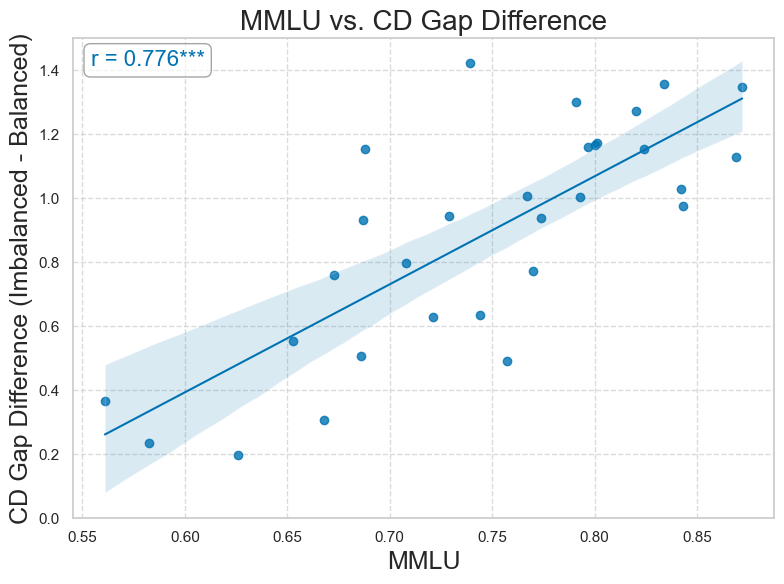

Overall Pearson: r = 0.702***, p = 1.543e-05
One-sample t-test (y_avg ≠ 0): t = 13.794***, p = 2.859e-14


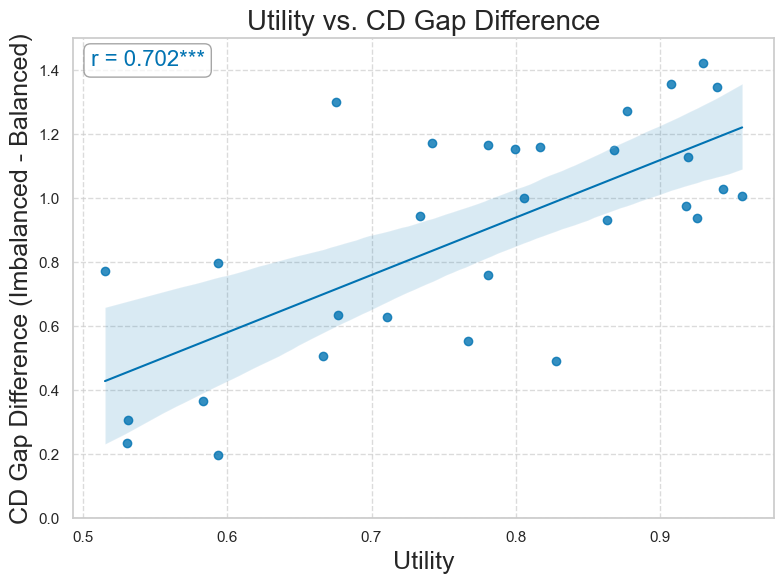

Overall Pearson: r = -0.233, p = 0.2156
One-sample t-test (y_avg ≠ 0): t = 1.920, p = 0.06471


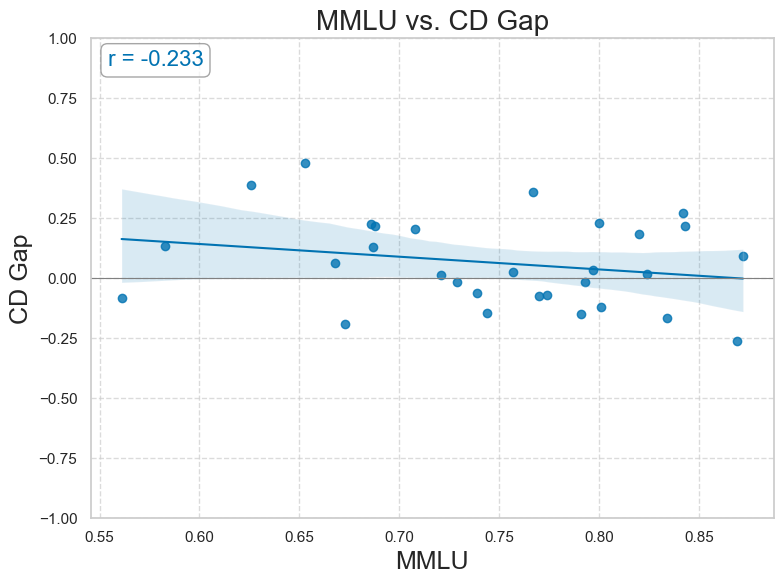

In [45]:
import seaborn as sns

# Merge stats (from plot_metric_barplot with sort_by_diff=True) into avg_data_df on model_id
plot_df = avg_data_df.merge(diff_stats[['model_id', 'diff']], on='model_id', how='inner')
plot_df = plot_df.dropna(subset=['MMLU All Subjects - EM'])


plot_scatter(
    plot_df,
    x_metric='MMLU All Subjects - EM',
    x_label='MMLU',
    y_metric='diff',
    y_label='CD Gap Difference (Imbalanced - Balanced)',
    title='MMLU vs. CD Gap Difference',
    filter_reasoning_order='reasoning first',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'scatter_MMLU_vs_CD_gap_diff.pdf'),
    # xlim=(0, 1),
    # label_points=True,
    ylim=(0, 1.5),
)

plot_scatter(
    plot_df,
    x_metric='Overall_utility',
    x_label='Utility',
    y_metric='diff',
    y_label='CD Gap Difference (Imbalanced - Balanced)',
    title='Utility vs. CD Gap Difference',
    filter_reasoning_order='reasoning first',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'scatter_MMLU_vs_CD_gap_diff.pdf'),
    # xlim=(0, 1),
    # label_points=True,
    ylim=(0, 1.5),
)

plot_scatter(
    plot_df,
    x_metric='MMLU All Subjects - EM',
    x_label='MMLU',
    y_metric='delta_CD',
    y_label='CD Gap',
    title='MMLU vs. CD Gap',
    filter_reasoning_order='reasoning first',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'scatter_MMLU_vs_CD_gap_diff.pdf'),
    # xlim=(0, 1),
    # label_points=True,
    ylim=(-1, 1),
)

### Capability vs Consistency

Overall Pearson: r = 0.662***, p = 6.824e-05
One-sample t-test (y_avg ≠ 0): t = 34.288***, p = 5.06e-25


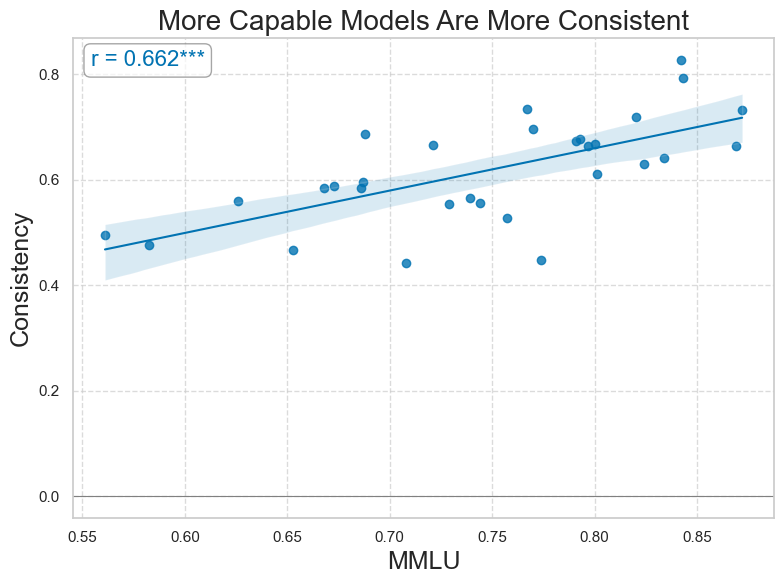

Overall Pearson: r = 0.692***, p = 1.619e-05
Reason-then-Decide vs Decide-then-Reason: t = 1.660, p = 0.1044
Reason-then-Decide Pearson: r = 0.662***, p = 6.824e-05
Decide-then-Reason Pearson: r = 0.639***, p = 0.000145


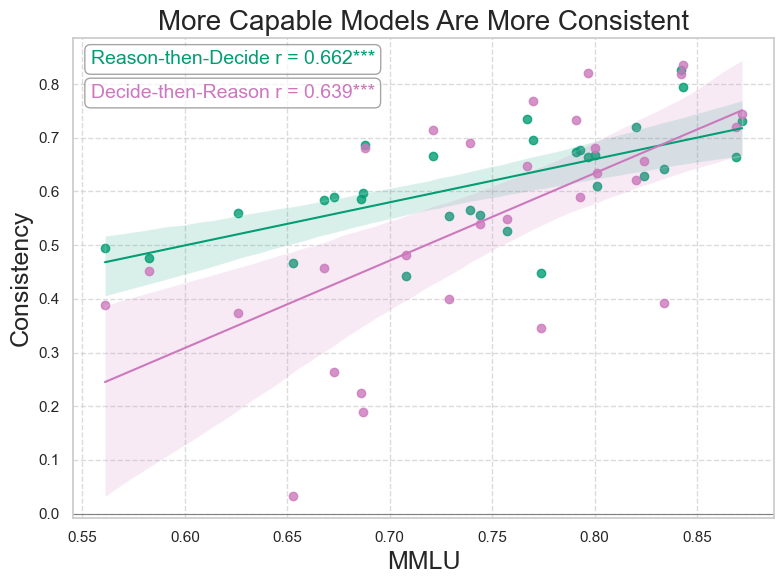

In [46]:
plot_scatter(
    df=avg_data_df,
    y_metric='Overall_consistency',
    y_label='Consistency',

    x_metric='MMLU All Subjects - EM',
    x_label='MMLU',

    # separate_reasoning_order=True,
    # separate_group_size=True,

    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',

    # filter_group_size='equal',
    # filter_group_size='unequal',

    title='More Capable Models Are More Consistent',
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_consistency__reasoningFirst.pdf"),
    # corr_placement='bottom_left',
    # label_points=True,
    # logx=True,
    # ylim=(-1,1),
)

plot_scatter(
    df=avg_data_df,
    y_metric='Overall_consistency',
    y_label='Consistency',

    x_metric='MMLU All Subjects - EM',
    x_label='MMLU',

    separate_reasoning_order=True,
    # separate_group_size=True,

    # filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',

    # filter_group_size='equal',
    # filter_group_size='unequal',

    title='More Capable Models Are More Consistent',
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_consistency_reasoningOrder_.pdf"),
    # corr_placement='bottom_left',
    # label_points=True,
    # logx=True,
    # ylim=(-1,1),
)

### Capability vs Utility

In [47]:
cmap

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

Overall Pearson: r = 0.674***, p = 4.43e-05
One-sample t-test (y_avg ≠ 0): t = 30.616***, p = 1.24e-23


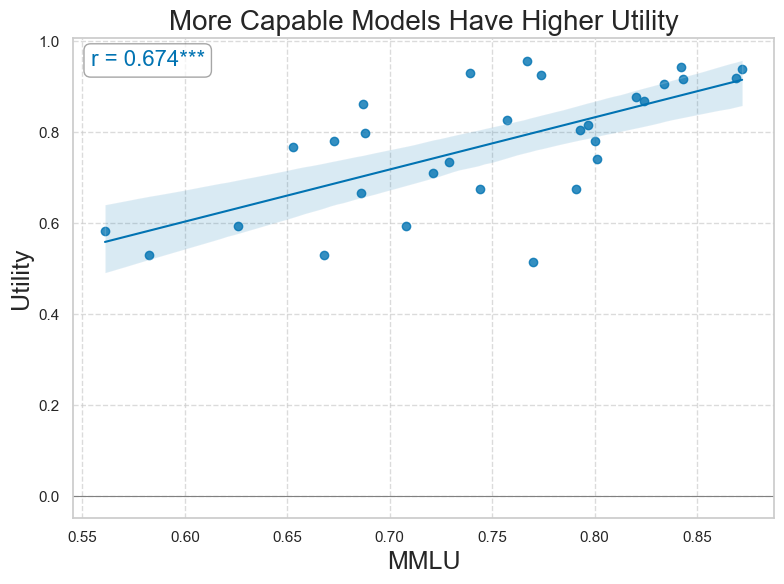

Overall Pearson: r = 0.510**, p = 0.003396
Reason-then-Decide vs Decide-then-Reason: t = 3.739***, p = 0.0004703
Reason-then-Decide Pearson: r = 0.674***, p = 4.43e-05
Decide-then-Reason Pearson: r = 0.407*, p = 0.0255


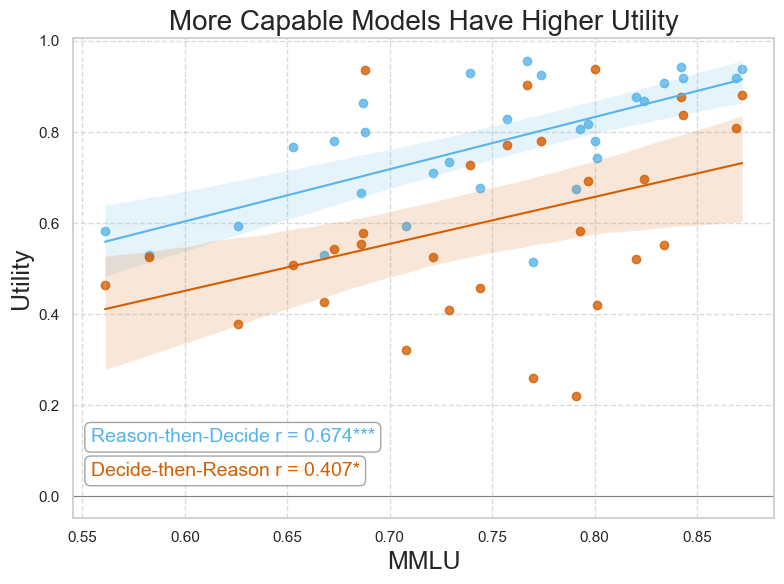

In [48]:
plot_scatter(
    df=avg_data_df,
    y_metric='Overall_utility',
    y_label='Utility',

    x_metric='MMLU All Subjects - EM',
    x_label='MMLU',

    # separate_reasoning_order=True,
    # separate_group_size=True,

    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',

    # filter_group_size='equal',
    # filter_group_size='unequal',

    title='More Capable Models Have Higher Utility',
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_utility__reasoningFirst.pdf"),
    corr_placement='top_left',
    # label_points=True,
    # logx=True,
    # ylim=(-1,1),
)

plot_scatter(
    df=avg_data_df,
    y_metric='Overall_utility',
    y_label='Utility',

    x_metric='MMLU All Subjects - EM',
    x_label='MMLU',

    separate_reasoning_order=True,
    # separate_group_size=True,

    # filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',

    # filter_group_size='equal',
    # filter_group_size='unequal',

    title='More Capable Models Have Higher Utility',
    save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_utility_reasoningOrder_.pdf"),
    corr_placement='bottom_left',
    colors=[cmap[-1], cmap[3]],
    # label_points=True,
    # logx=True,
    # ylim=(-1,1),
)

### Capability vs DeltaCD

Overall Pearson: r = -0.233, p = 0.2156
One-sample t-test (y_avg ≠ 0): t = 1.920, p = 0.06471


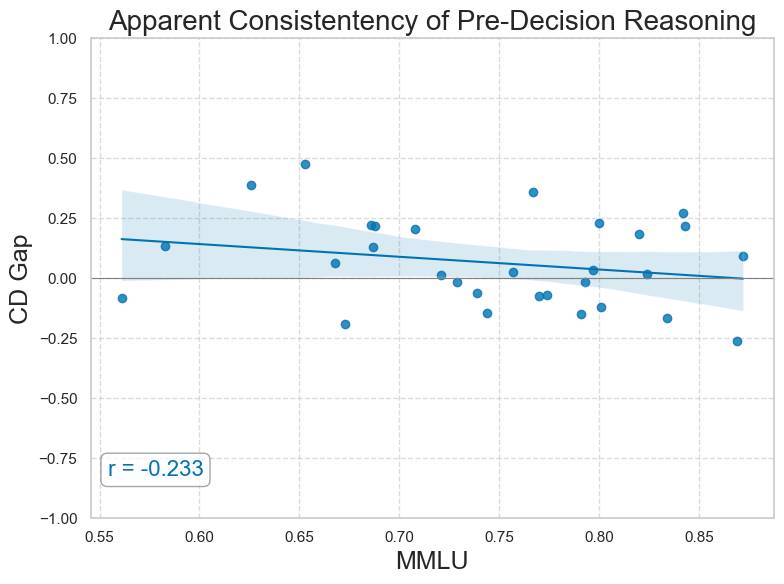

Overall Pearson: r = -0.233, p = 0.2156
Balanced vs Imbalanced: t = -13.479***, p = 5.494e-19
Balanced Pearson: r = -0.629***, p = 0.000197
Imbalanced Pearson: r = 0.426*, p = 0.01879


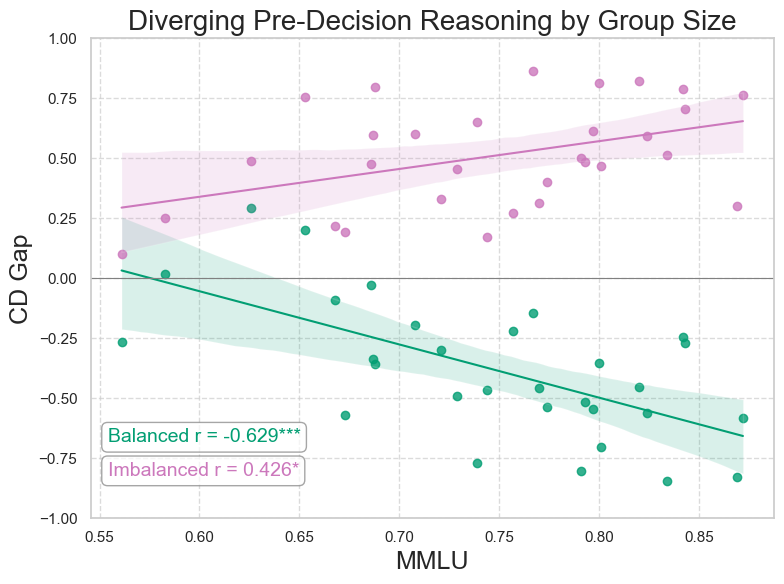

Overall Pearson: r = -0.315, p = 0.0901
One-sample t-test (y_avg ≠ 0): t = 5.442***, p = 7.422e-06


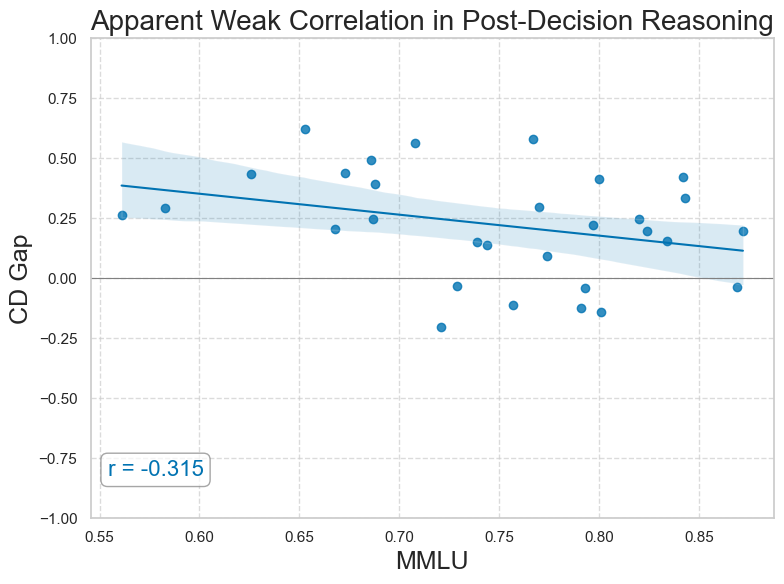

Overall Pearson: r = -0.315, p = 0.0901
Balanced vs Imbalanced: t = -9.810***, p = 5.441e-13
Balanced Pearson: r = -0.582***, p = 0.0007443
Imbalanced Pearson: r = 0.279, p = 0.1359


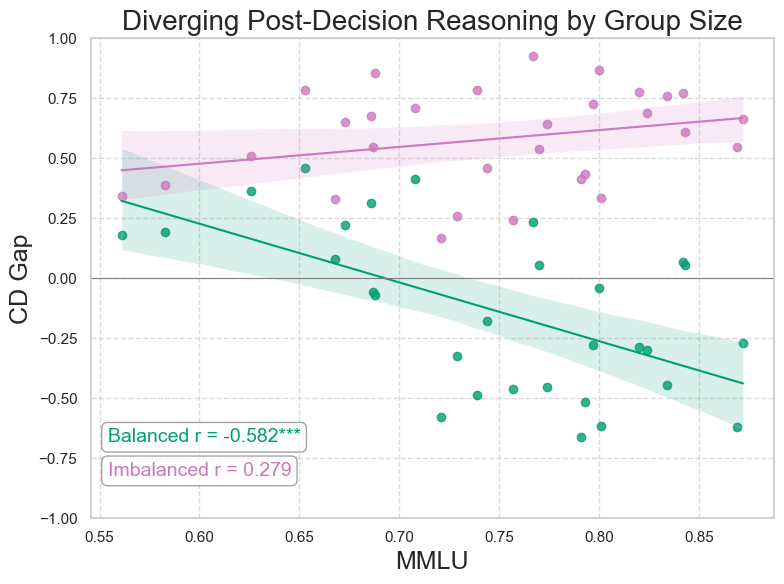

In [49]:
plot_scatter(
    df=avg_data_df,
    x_metric='MMLU All Subjects - EM', x_label='MMLU',
    # x_metric='release_date', x_label='Release Date',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Apparent Consistentency of Pre-Decision Reasoning',
    save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_deltaCD__reasoningFirst.pdf"),
    corr_placement='bottom_left',
    # label_points=True,
    # logx=True,
    # order=2,
    ylim=(-1, 1),
)

plot_scatter(
    df=avg_data_df,
    x_metric='MMLU All Subjects - EM', x_label='MMLU',
    # x_metric='release_date', x_label='Release Date',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Diverging Pre-Decision Reasoning by Group Size',
    save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_deltaCD_groupSize_reasoningFirst.pdf"),
    corr_placement='bottom_left',
    # label_points=True,
    # logx=True,
    # order=2,
    ylim=(-1, 1),
)

plot_scatter(
    df=avg_data_df,
    x_metric='MMLU All Subjects - EM', x_label='MMLU',
    # x_metric='release_date', x_label='Release Date',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    # filter_reasoning_order='reasoning first',
    filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Apparent Weak Correlation in Post-Decision Reasoning',
    save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_deltaCD__decisionFirst.pdf"),
    corr_placement='bottom_left',
    # label_points=True,
    # logx=True,
    # order=2,
    ylim=(-1, 1),
)

plot_scatter(
    df=avg_data_df,
    x_metric='MMLU All Subjects - EM', x_label='MMLU',
    # x_metric='release_date', x_label='Release Date',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    separate_group_size=True,
    # filter_reasoning_order='reasoning first',
    filter_reasoning_order='decision first',
    # filter_group_size='equal',x
    # filter_group_size='unequal',
    title='Diverging Post-Decision Reasoning by Group Size',
    save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_deltaCD_groupSize_decisionFirst.pdf"),
    corr_placement='bottom_left',
    # label_points=True,
    # logx=True,
    # order=2,
    ylim=(-1, 1),
)

### Release Date vs DeltaCD

Overall Pearson: r = -0.093, p = 0.4896
One-sample t-test (y_avg ≠ 0): t = 1.996, p = 0.05076


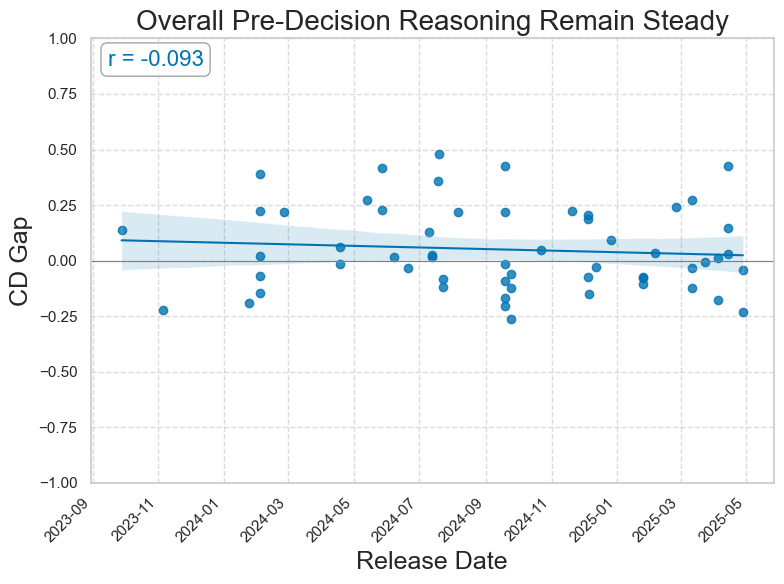

Overall Pearson: r = -0.071, p = 0.6987
Balanced vs Imbalanced: t = -18.720***, p = 7.217e-34
Balanced Pearson: r = -0.355**, p = 0.006687
Imbalanced Pearson: r = 0.368**, p = 0.004915


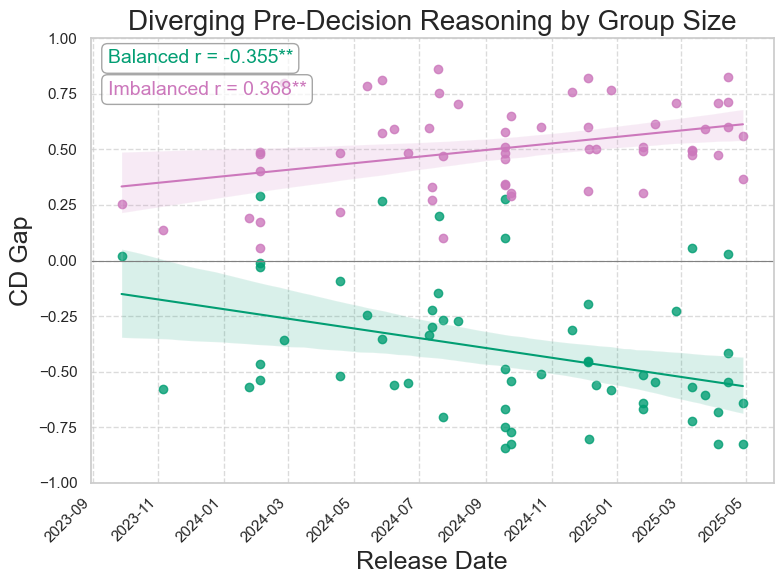

Overall Pearson: r = -0.116, p = 0.3919
One-sample t-test (y_avg ≠ 0): t = 7.855***, p = 1.337e-10


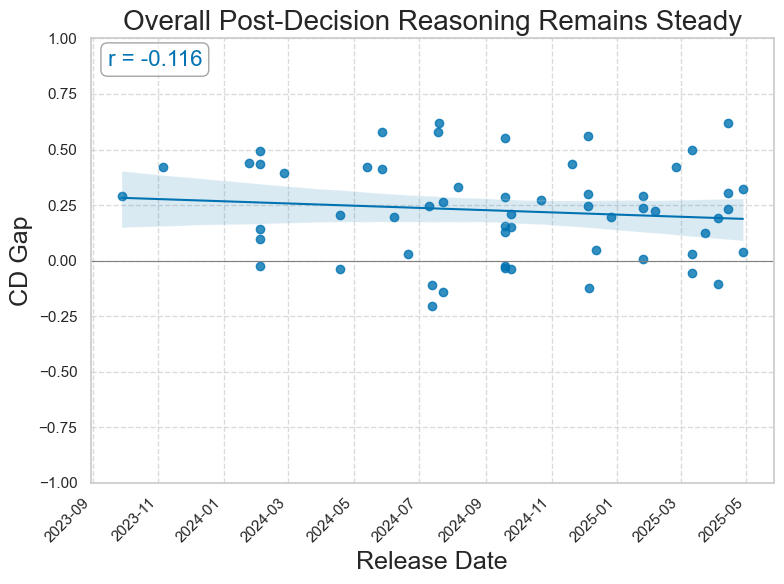

Overall Pearson: r = -0.255, p = 0.1593
Balanced vs Imbalanced: t = -14.035***, p = 1.397e-24
Balanced Pearson: r = -0.248, p = 0.06258
Imbalanced Pearson: r = 0.159, p = 0.236


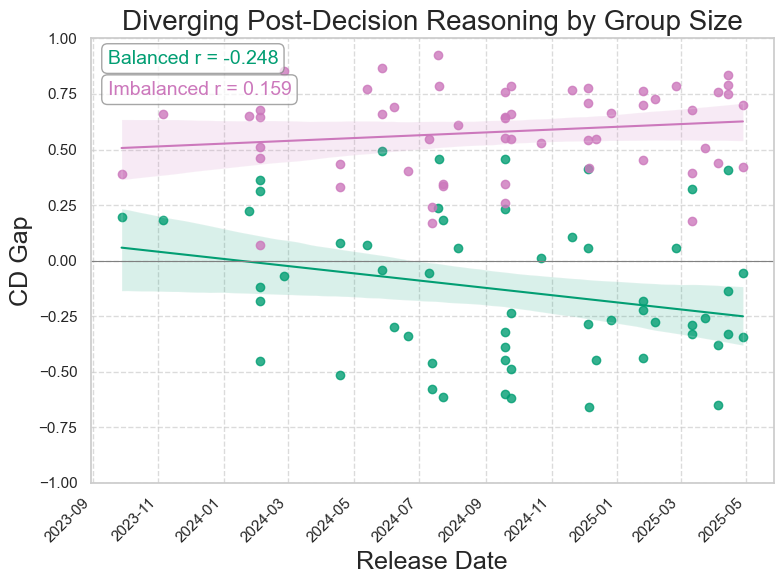

In [50]:
plot_scatter(
    df=avg_data_df,
    x_metric='release_date', x_label='Release Date',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Overall Pre-Decision Reasoning Remain Steady',
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_releaseDate_deltaCD__reasoningFirst.pdf"),
    corr_placement='top_left',
    # label_points=True,
    ylim=(-1, 1),
)

plot_scatter(
    df=avg_data_df,
    x_metric='release_date', x_label='Release Date',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Diverging Pre-Decision Reasoning by Group Size',
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_releaseDate_deltaCD_groupSize_reasoningFirst.pdf"),
    corr_placement='top_left',
    # label_points=True,
    ylim=(-1, 1),
)

plot_scatter(
    df=avg_data_df,
    x_metric='release_date', x_label='Release Date',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    # filter_reasoning_order='reasoning first',
    filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Overall Post-Decision Reasoning Remains Steady',
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_releaseDate_deltaCD__decisionFirst.pdf"),
    corr_placement='top_left',
    # label_points=True,
    ylim=(-1, 1),
)

plot_scatter(
    df=avg_data_df,
    x_metric='release_date', x_label='Release Date',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    separate_group_size=True,
    # filter_reasoning_order='reasoning first',
    filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Diverging Post-Decision Reasoning by Group Size',
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_releaseDate_deltaCD_groupSize_decisionFirst.pdf"),
    corr_placement='top_left',
    # label_points=True,
    ylim=(-1, 1),
)

## Misc Plots

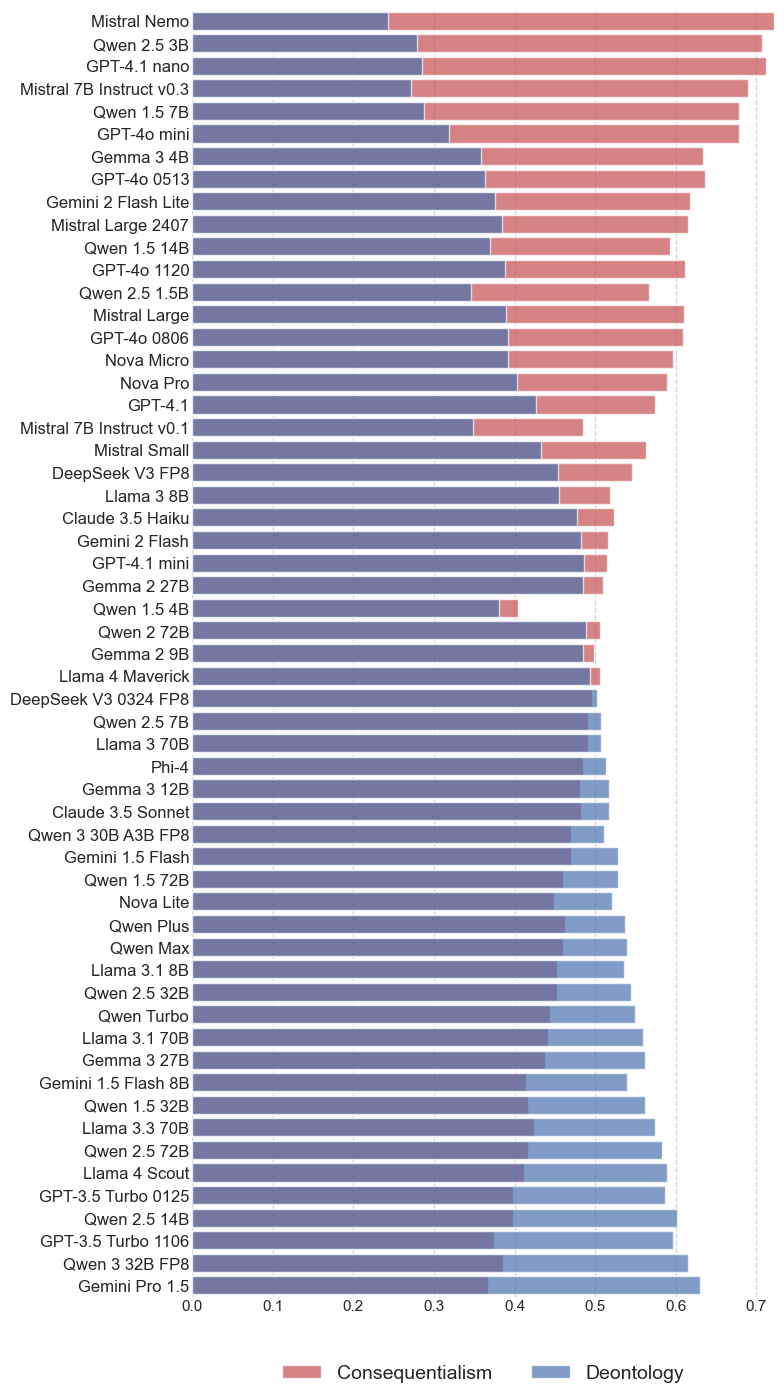

In [51]:
# Sort the data by delta_CD
filtered = avg_data_df[avg_data_df['reasoning_first'] == True]
filtered = filtered.groupby(['model_id', 'model_name']).mean(numeric_only=True).reset_index()
plot_df = filtered.sort_values('delta_CD')

# Create horizontal bar chart sized for one-column ACL (~3.3in wide)
fig, ax = plt.subplots(figsize=(8, 14))

# Horizontal bars
y_pos = range(len(plot_df))
ax.barh(y_pos, plot_df['Overall_Consequentialism'], color='r', alpha=0.7)
ax.barh(y_pos, plot_df['Overall_Deontology'], color='b', alpha=0.7)

# Create custom legend patches
legend_elements = [
    Patch(facecolor='r', alpha=0.7, label='Consequentialism'),
    Patch(facecolor='b', alpha=0.7, label='Deontology')
]

# Add legend at the bottom, 2 columns centered
ax.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=2,
    frameon=False,
    fontsize=14
)

# Aesthetics
# add y tick markers
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df['model_name'], fontsize=12)
# ax.set_title('Consequentialism vs. Deontology', fontsize=20)
ax.set_ylim(-0.5, len(plot_df) - 0.5)
ax.grid()
ax.grid(axis='x', linestyle='--', alpha=0.8)
ax.set_xlim(0, plot_df['Overall_Consequentialism'].max())
sns.despine(fig=fig, ax=ax, left=True, bottom=True, right=True, top=True)
ax.tick_params(axis='y', which='major', pad=-4)
ax.tick_params(axis='x', which='major', pad=-4)

plt.tight_layout()
# plt.savefig(os.path.join(FIGURE_SAVE_DIR, 'bar_CD_models__.pdf'), bbox_inches='tight', dpi=300)
plt.show()

Overall Pearson: r = -0.060, p = 0.7548
One-sample t-test (y_avg ≠ 0): t = 13.857***, p = 2.549e-14


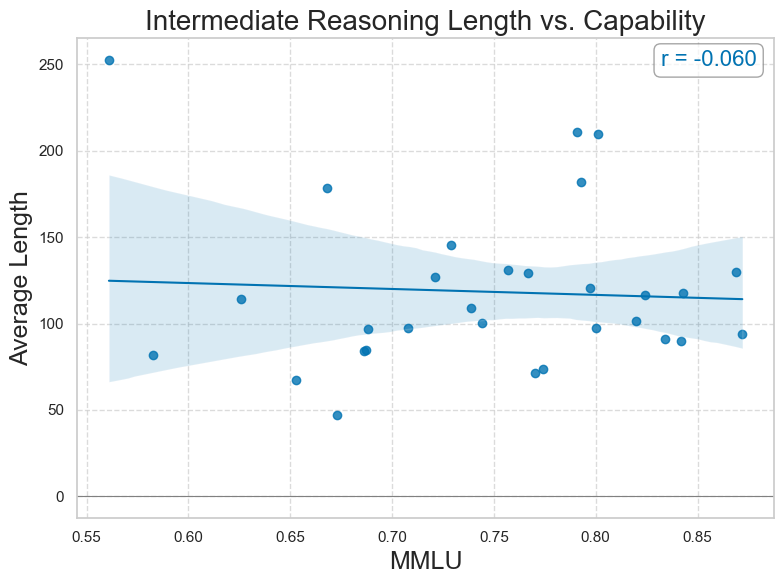

Overall Pearson: r = 0.386**, p = 0.003008
One-sample t-test (y_avg ≠ 0): t = 18.927***, p = 5.285e-26


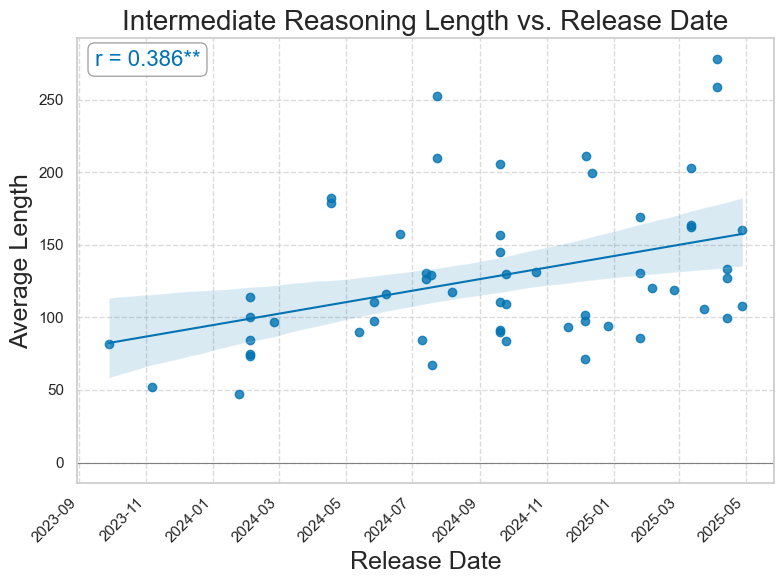

Overall Pearson: r = 0.167, p = 0.3763
One-sample t-test (y_avg ≠ 0): t = 11.607***, p = 2.024e-12


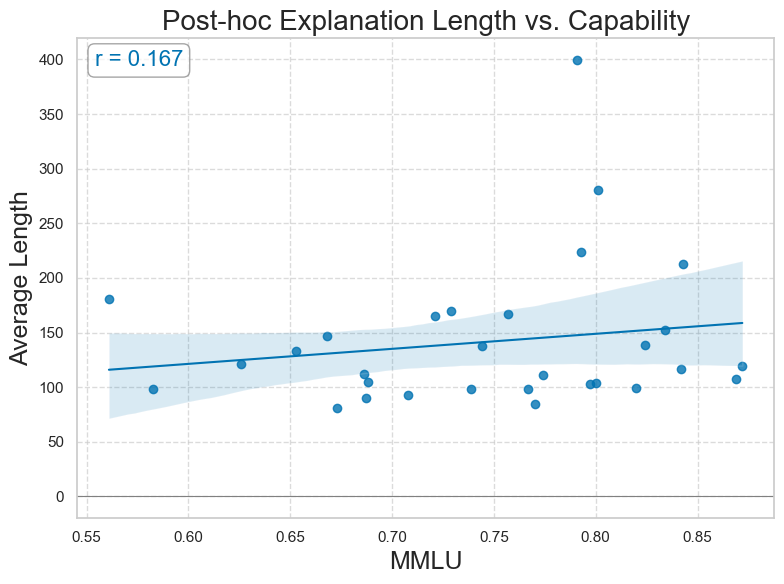

Overall Pearson: r = 0.284*, p = 0.0322
One-sample t-test (y_avg ≠ 0): t = 15.405***, p = 8.6e-22


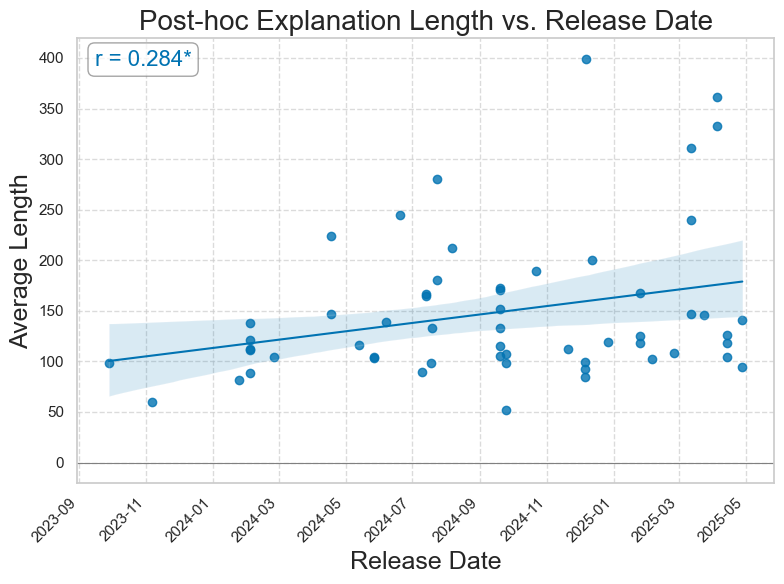

In [52]:
plot_scatter(
    df=avg_data_df,
    query="reasoning_model == False",
    x_metric='MMLU All Subjects - EM', x_label='MMLU',
    y_metric='avg_length', y_label='Average Length',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title="Intermediate Reasoning Length vs. Capability",
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_responseLength__reasoningFirst.pdf"),
    corr_placement='top_right',
    # label_points=True,
)

plot_scatter(
    df=avg_data_df,
    query="reasoning_model == False",
    x_metric='release_date', x_label='Release Date',
    y_metric='avg_length', y_label='Average Length',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title="Intermediate Reasoning Length vs. Release Date",
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_releaseDate_responseLength__reasoningFirst.pdf"),
    corr_placement='top_left',
    # label_points=True,
)

plot_scatter(
    df=avg_data_df,
    query="reasoning_model == False",
    x_metric='MMLU All Subjects - EM', x_label='MMLU',
    y_metric='avg_length', y_label='Average Length',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    # filter_reasoning_order='reasoning first',
    filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title="Post-hoc Explanation Length vs. Capability",
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_mmlu_responseLength__decisionFirst.pdf"),
    corr_placement='top_left',
    # label_points=True,
)

plot_scatter(
    df=avg_data_df,
    query="reasoning_model == False",
    x_metric='release_date', x_label='Release Date',
    y_metric='avg_length', y_label='Average Length',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    # filter_reasoning_order='reasoning first',
    filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title="Post-hoc Explanation Length vs. Release Date",
    # save_path=os.path.join(FIGURE_SAVE_DIR, "scatter_releaseDate_responseLength__decisionFirst.pdf"),
    corr_placement='top_left',
    # label_points=True,
)

Overall Pearson: r = -0.249, p = 0.1562
One-sample t-test (y_avg ≠ 0): t = 0.887, p = 0.3814


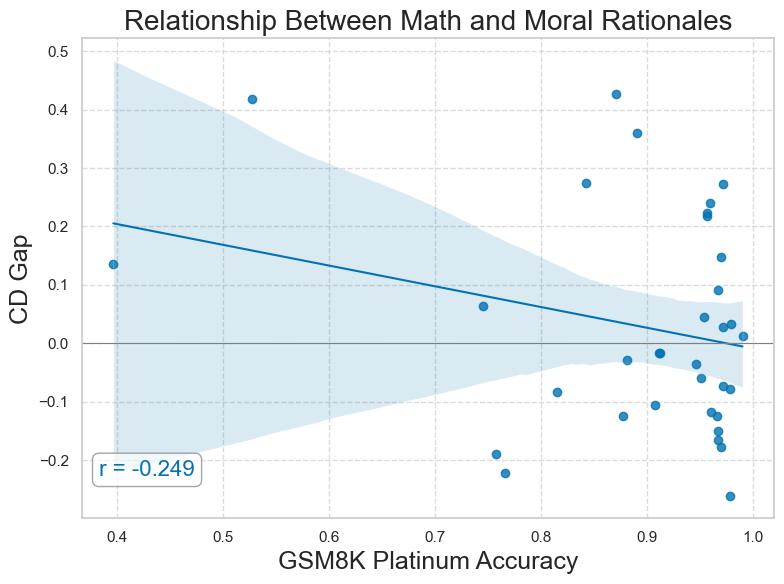

Overall Pearson: r = -0.271, p = 0.1713
Balanced vs Imbalanced: t = -16.300***, p = 1.328e-23
Balanced Pearson: r = -0.636***, p = 5.301e-05
Imbalanced Pearson: r = 0.440**, p = 0.009146


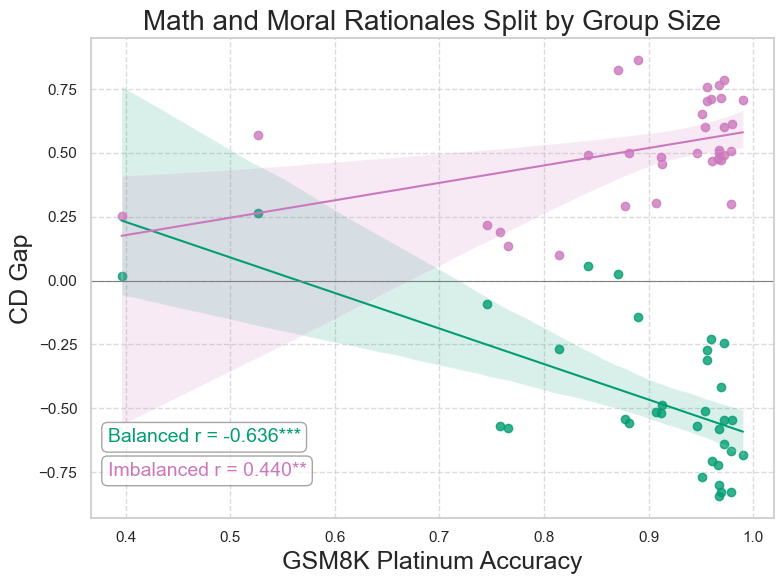

In [53]:
plot_scatter(
    df=avg_data_df,
    x_metric='GSM8K Platinum - Mean', x_label='GSM8K Platinum Accuracy',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Relationship Between Math and Moral Rationales',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'delta_CD_by_gsm8k.pdf'),
    corr_placement='bottom_left',
    # label_points=True,
)

plot_scatter(
    df=avg_data_df,
    x_metric='GSM8K Platinum - Mean', x_label='GSM8K Platinum Accuracy',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Math and Moral Rationales Split by Group Size',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'delta_CD_by_gsm8k_and_group_size.pdf'),
    corr_placement='bottom_left',
    # label_points=True,
)

Overall Pearson: r = -0.008, p = 0.97
One-sample t-test (y_avg ≠ 0): t = 0.982, p = 0.3367


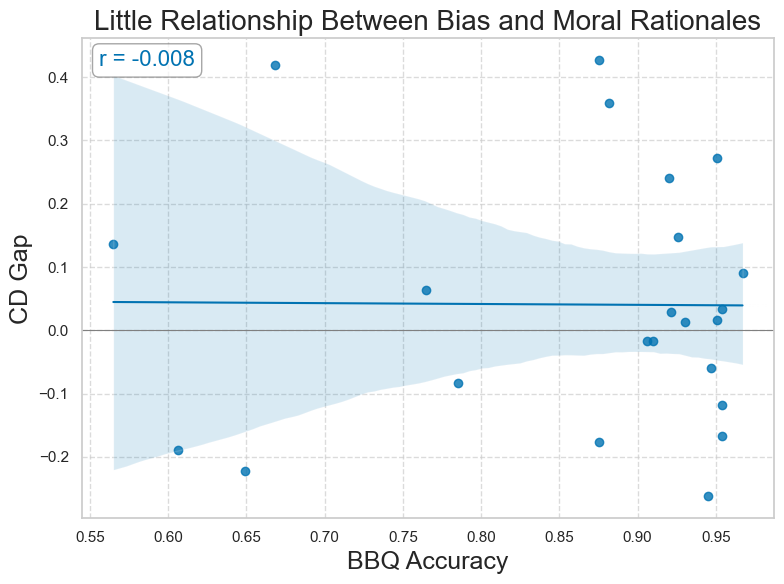

Overall Pearson: r = 0.021, p = 0.9317
Balanced vs Imbalanced: t = -12.098***, p = 4.603e-15
Balanced Pearson: r = -0.486*, p = 0.01882
Imbalanced Pearson: r = 0.636**, p = 0.00111


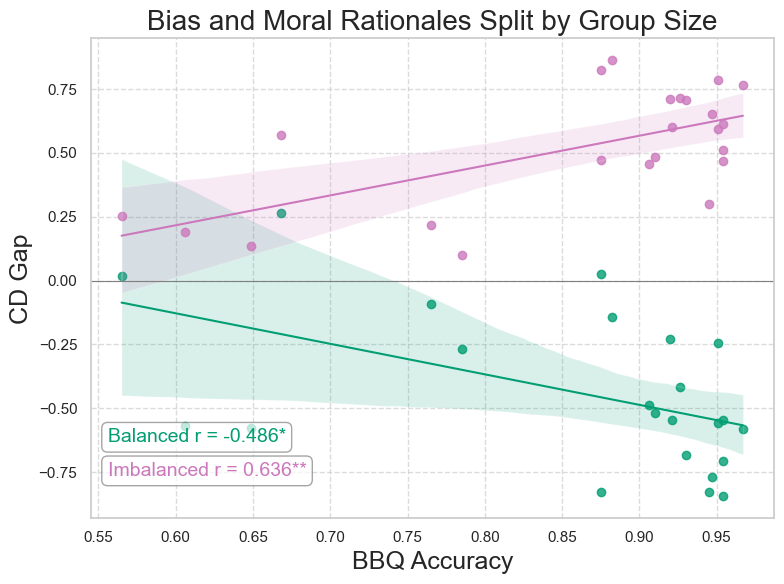

In [54]:
plot_scatter(
    df=avg_data_df,
    x_metric='BBQ - BBQ accuracy', x_label='BBQ Accuracy',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Little Relationship Between Bias and Moral Rationales',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'delta_CD_by_bbq.pdf'),
    # corr_placement='bottom_left',
    # label_points=True,
)

plot_scatter(
    df=avg_data_df,
    x_metric='BBQ - BBQ accuracy', x_label='BBQ Accuracy',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Bias and Moral Rationales Split by Group Size',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'delta_CD_by_bbq_and_group_size.pdf'),
    corr_placement='bottom_left',
    # label_points=True,
)

Overall Pearson: r = -0.131, p = 0.1642
Balanced vs Imbalanced: t = -18.720***, p = 7.217e-34
Balanced Pearson: r = -0.245, p = 0.06618
Imbalanced Pearson: r = -0.067, p = 0.6195


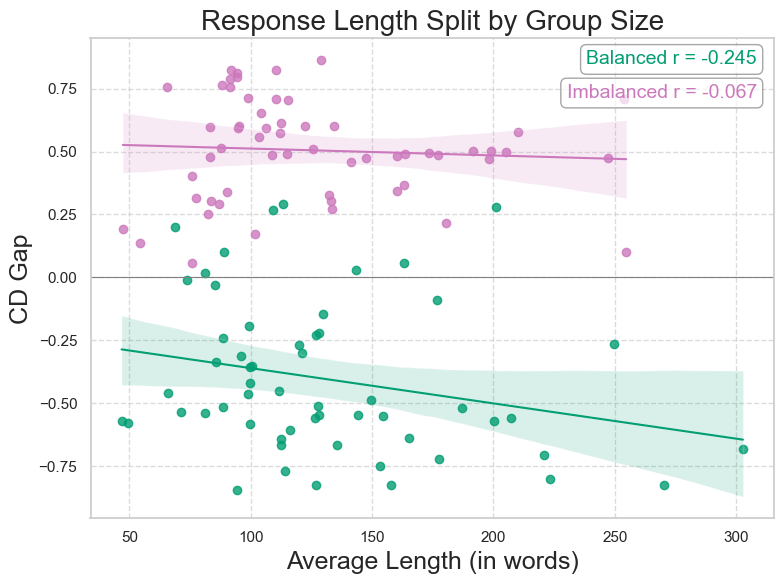

Overall Pearson: r = -0.131, p = 0.1642
One-sample t-test (y_avg ≠ 0): t = 1.021, p = 0.3094


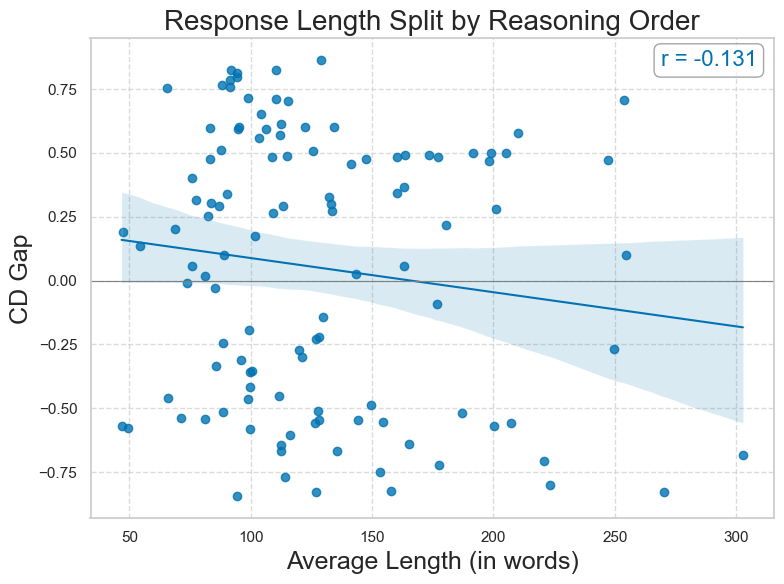

In [55]:
plot_scatter(
    df=avg_data_df,
    query="reasoning_model == False",
    x_metric='avg_length', x_label='Average Length (in words)',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Response Length Split by Group Size',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'delta_CD_by_response_length_and_group_size.pdf'),
    corr_placement='top_right',
    # label_points=True,
)

plot_scatter(
    df=avg_data_df,
    query="reasoning_model == False",
    x_metric='avg_length', x_label='Average Length (in words)',
    y_metric='delta_CD', y_label='CD Gap',
    # separate_reasoning_order=True,
    # separate_group_size=True,
    filter_reasoning_order='reasoning first',
    # filter_reasoning_order='decision first',
    # filter_group_size='equal',
    # filter_group_size='unequal',
    title='Response Length Split by Reasoning Order',
    # save_path=os.path.join(FIGURE_SAVE_DIR, 'delta_CD_by_response_length_and_reasoning_order.pdf'),
    corr_placement='top_right',
    # label_points=True,
)

reasoning_first
0.0    148.519868
1.0    128.425811
Name: avg_length, dtype: float64


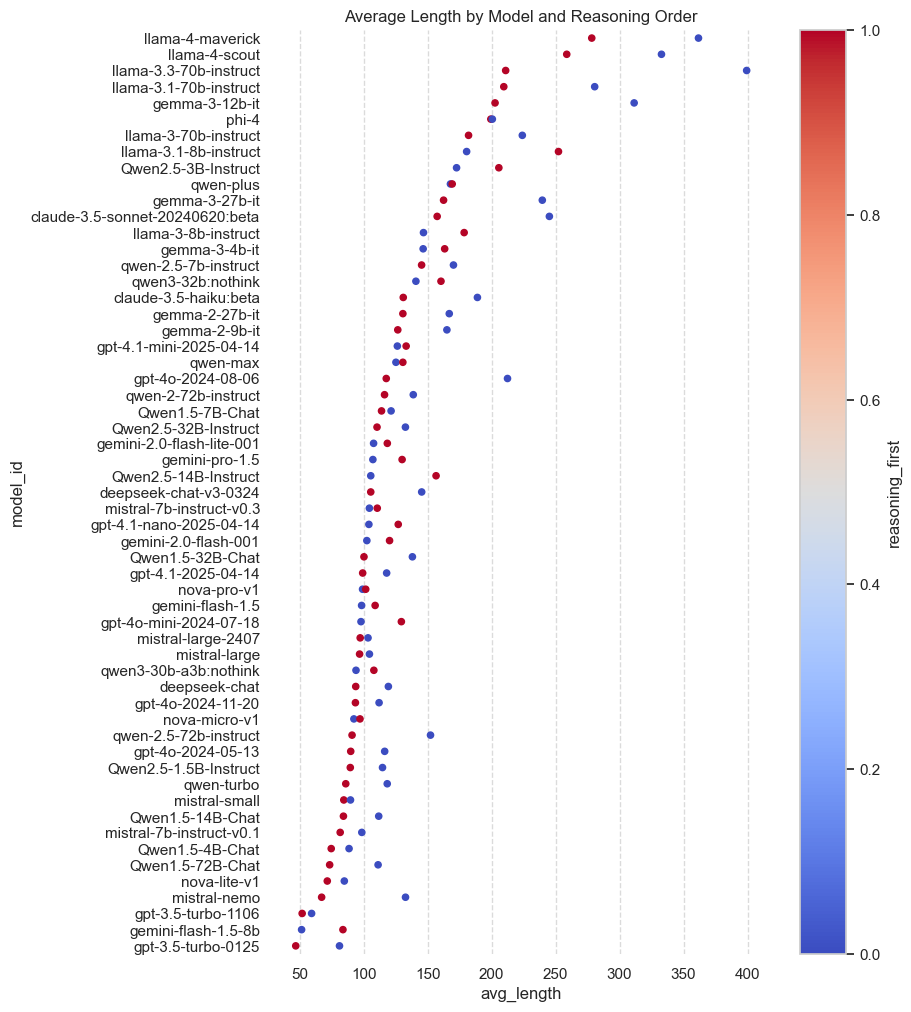

In [56]:
sub = avg_data_df[avg_data_df['reasoning_model'] == False]
sub = sub.groupby(['model_id', 'reasoning_first'])['avg_length'].mean().reset_index()


sub = sub.sort_values('avg_length')

print(sub.groupby(['reasoning_first'])['avg_length'].mean())

sub.plot(
    x='avg_length',
    y='model_id',
    c='reasoning_first',
    cmap='coolwarm',
    kind='scatter',
    figsize=(8, 12),
    title='Average Length by Model and Reasoning Order'
)
plt.ylim(-0.5, len(sub.model_id.unique()) - 0.5)
plt.grid()
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True, right=True, top=True)
plt.show()

<Axes: title={'center': 'MMLU Scores by Model and Reasoning Order'}, xlabel='MMLU', ylabel='MMLU All Subjects - EM'>

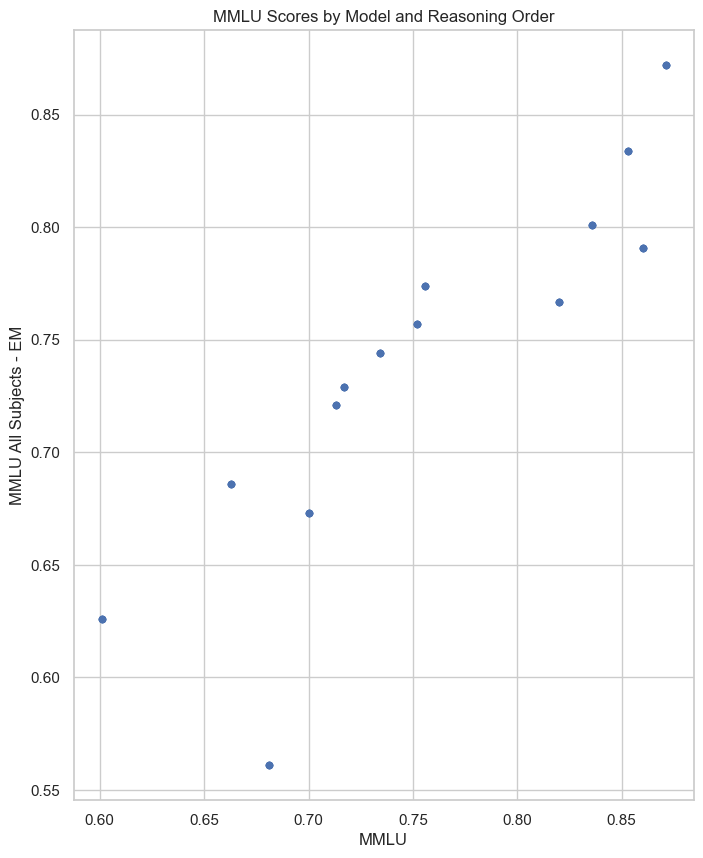

In [57]:
mmlu = avg_data_df[['model_name', 'MMLU All Subjects - EM', 'MMLU']]
mmlu.plot(
    x='MMLU',
    y='MMLU All Subjects - EM',
    # y='MMLU - EM',
    kind='scatter',
    figsize=(8, 10),
    title='MMLU Scores by Model and Reasoning Order'
)